# 1. Imports

In [1]:
import json
import math
import scipy
import ast
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statistics 
import seaborn as sns
from statsmodels.stats.proportion import proportions_ztest
from numpy.random import randn
from random import *
from statistics import mode
from scipy import stats
%matplotlib inline

In [2]:
scipy.__version__

'1.6.2'

# 2. Preparations
## 2.1 Load Data

In [90]:
classrooms = json.load(open('data/raw_data/classrooms.json', 'r'))
pupils = json.load(open('data/raw_data/pupils.json', 'r'))

df = pd.read_pickle('data/processed/df.pkl')
chat_df = pd.read_pickle("data/processed/chat.pkl")
surveysliders = pd.read_pickle('data/processed/surveySlider.pkl')
inputfields = pd.read_pickle('data/processed/inputFields.pkl')
multipleChoice = pd.read_pickle('data/processed/multipleChoice.pkl')
freetext = pd.read_pickle('data/processed/freetext.pkl')
task_df = pd.read_pickle('data/processed/task_df.pkl')
pupil_performance_df = pd.read_pickle('data/processed/pupil_performance.pkl')
# Laden der Datei, in der händisch alle Freitext-Antworten bewertet wurden
pupil_performance_df_rated = pd.read_csv('data/processed/pupil_performance_3.csv', delimiter=';')
pupil_performance_df_rated = pupil_performance_df_rated.set_index('pupilId')

# set the duration columns to numeric
df['duration'] = pd.to_numeric(df['duration'])
surveysliders['duration'] = pd.to_numeric(surveysliders['duration'])
inputfields['duration'] = pd.to_numeric(inputfields['duration'])
multipleChoice['duration'] = pd.to_numeric(multipleChoice['duration'])
freetext['duration'] = pd.to_numeric(freetext['duration'])

pupil_performance_df_rated.head()

nr_tasks_per_pupil  total_duration in minutes  \
pupilId                                                            
Ay6mfswm3SFcQdNJg                  66                 120.116667   
Z9DkQMmtiPiHtteME                   4                  25.950000   
sqBXKssFvS8pFYAMv                  66                  66.650000   
Kd6FuRsrq6QvPrkKp                   6                  37.383333   
jRT6yzZ2ip5ab5ZFM                  66                  66.566667   

                   average duration per task in minutes  AI-1-v2-1-1  \
pupilId                                                                
Ay6mfswm3SFcQdNJg                              1.819949         62.0   
Z9DkQMmtiPiHtteME                              6.487500         43.0   
sqBXKssFvS8pFYAMv                              1.009848         89.0   
Kd6FuRsrq6QvPrkKp                              6.230556         78.0   
jRT6yzZ2ip5ab5ZFM                              1.008586         90.0   

                   AI-4-v2-1-4  EvalML-1-1  ML-2-1-1  EvalML-1-5  AI-4-v2-1-5  \
pupilId                                                                         
Ay6mfswm3SFcQdNJg         91.0        81.0      71.0        75.0         90.0   
Z9DkQMmtiPiHtteME          NaN         NaN       NaN         NaN          NaN   
sqBXKssFvS8pFYAMv         99.0        96.0      79.0        93.0        100.0   
Kd6FuRsrq6QvPrkKp          NaN         NaN       NaN         NaN          NaN   
jRT6yzZ2ip5ab5ZFM         88.0        76.0      71.0        69.0         72.0   

                   EvalML-1-2  ...  AIClosing-1-8_eval  \
pupilId                        ...                       
Ay6mfswm3SFcQdNJg        90.0  ...             pending   
Z9DkQMmtiPiHtteME         NaN  ...                 NaN   
sqBXKssFvS8pFYAMv        98.0  ...             correct   
Kd6FuRsrq6QvPrkKp         NaN  ...                 NaN   
jRT6yzZ2ip5ab5ZFM       100.0  ...             correct   

                   AIClosing-1-8_null_answer  AIClosing-1-8_unknown  \
pupilId                                                               
Ay6mfswm3SFcQdNJg                        NaN                    NaN   
Z9DkQMmtiPiHtteME                        NaN                    NaN   
sqBXKssFvS8pFYAMv                        NaN                    NaN   
Kd6FuRsrq6QvPrkKp                        NaN                    NaN   
jRT6yzZ2ip5ab5ZFM                        NaN                    NaN   

                   AIClosing-1-8_correct_points  \
pupilId                                           
Ay6mfswm3SFcQdNJg                           NaN   
Z9DkQMmtiPiHtteME                           NaN   
sqBXKssFvS8pFYAMv                           NaN   
Kd6FuRsrq6QvPrkKp                           NaN   
jRT6yzZ2ip5ab5ZFM                           NaN   

                  AIClosing-1-8_incorrect_points  \
pupilId                                            
Ay6mfswm3SFcQdNJg                            NaN   
Z9DkQMmtiPiHtteME                            NaN   
sqBXKssFvS8pFYAMv                            NaN   
Kd6FuRsrq6QvPrkKp                            NaN   
jRT6yzZ2ip5ab5ZFM                            NaN   

                  AIClosing-1-8_irrelevant_points  \
pupilId                                             
Ay6mfswm3SFcQdNJg                             NaN   
Z9DkQMmtiPiHtteME                             NaN   
sqBXKssFvS8pFYAMv                             NaN   
Kd6FuRsrq6QvPrkKp                             NaN   
jRT6yzZ2ip5ab5ZFM                             NaN   

                  AIClosing-1-8_rating_content AIClosing-1-8_rating_format  \
pupilId                                                                      
Ay6mfswm3SFcQdNJg                          NaN                         NaN   
Z9DkQMmtiPiHtteME                          NaN                         NaN   
sqBXKssFvS8pFYAMv                          5.0                         5.0   
Kd6FuRsrq6QvPrkKp                          NaN                         NaN   
j

## 2.2 Prepare Helper functions

In [13]:
def surveySliderStatistics(column):
    '''Takes the name of a column, and prints a few basic statistics'''
    print(column.name)
    q3, q1 = np.percentile(column.dropna().values, [75 ,25])
    print("Q1: " + str(q1) + " and Q3: " + str(q3))
    print("median: " + str(column.dropna().median()))
    print("mean: " + str(column.dropna().mean()))
    print("std: " +str(round(column.dropna().std(), 2)))
    print("min: " + str(np.min(column.dropna())) + " und max: " + str(np.max(column.dropna())))
    print("")
    
def calculateDifferences(df):
    """Takes a dataframe and returns the differences between the first two columns as a list"""
    differences= []
    for pupilId in df.dropna().index:
        differences.append(df.loc[pupilId, df.columns[0]]-df.loc[pupilId, df.columns[1]])
    return differences

def print_boolean_percentages(series):
    """Takes a series and prints the percentage of correct, incorrect and irrelevant answers"""
    nr_cases = series.value_counts()[True]+series.value_counts()[False]
    percentage_per_case = 100/nr_cases
    true_percentage = series.value_counts()[True]*percentage_per_case
    false_percentage = series.value_counts()[False]*percentage_per_case
    print(series.name + " has: " + str(true_percentage) + "% True null answers: " + str(false_percentage)+ "% right answers")
    
def print_mc(taskIdArray):
    """Takes a list of taskIds and prints the corresponding tasknames, questions, as well as possible and correct answers"""
    for taskID in task_df.index:
        if taskID in taskIdArray:
            print(str(taskID))
            print('\033[1m' + task_df.loc[taskID]["question"] + '\033[0m')
            for i in range(len(task_df.loc[taskID]["answers"])):
                print("*" + task_df.loc[taskID]["answers"][i]["de"] + " - " + str(task_df.loc[taskID]["sampleSolution"][i]))
            print(task_df.loc[taskID]["sampleSolution"])
            print()

def mc_analysis (taskIds):
    """Takes a number of taskIds and prints how many errors each student made, as well as the average number of errors for the tasks"""
    number_errors = []
    for pupilId in pupil_performance_df.index:
        errors = [0 for taskId in taskIds]
        for index, taskId in enumerate(taskIds):
            if(len(pupil_performance_df.loc[pupilId, taskId]) != 0):
                for i in range(len(task_df.loc[taskId, "sampleSolution"])):
                    if pupil_performance_df.loc[pupilId, taskId][i] != task_df.loc[taskId, "sampleSolution"][i]:
                        errors[index] += 1
            elif(len(pupil_performance_df.loc[pupilId, taskId]) == 0):
                errors[index] = np.nan
        number_errors.append(errors)
    
    errors_sum =  [sum(list) for list in number_errors]
    errors_per_student = [entry for entry in [sum(list) for list in number_errors] if entry==entry]
    print(errors_per_student)
    errors_per_student_series = pd.Series(errors_per_student)
    
    print("number errors per student value counts")
    print(errors_per_student_series.value_counts())
    print("mean number of errors: " + str(np.mean(errors_per_student)))
    
    
def number_errors_mc (taskIds):
    """Takes a number of taskIds and returns how many errors each student made"""
    number_errors = []
    for pupilId in pupil_performance_df.index:
        errors = [0 for taskId in taskIds]
        for index, taskId in enumerate(taskIds):
            if(len(pupil_performance_df.loc[pupilId, taskId]) != 0):
                for i in range(len(task_df.loc[taskId, "sampleSolution"])):
                    if pupil_performance_df.loc[pupilId, taskId][i] != task_df.loc[taskId, "sampleSolution"][i]:
                        errors[index] += 1
            elif(len(pupil_performance_df.loc[pupilId, taskId]) == 0):
                errors[index] = np.nan
        number_errors.append(errors)

    errors_sum =  [sum(list) for list in number_errors]
    errors_per_student = [entry for entry in [sum(list) for list in number_errors] if entry==entry]
    return errors_per_student

def random_mcs(numberStudents, numberAnswers):
    """Takes a number of hypothetical students and possible answers and returns the expected number of errors if these were guessing everything"""
    expected_nr_errors = []
    for i in range(numberStudents):
        nr_errors_per_student = 0
        for i in range(numberAnswers):
            if random() >= 0.5:
                nr_errors_per_student+=1
        expected_nr_errors.append(nr_errors_per_student)
    return expected_nr_errors

def mannwhitney(taskArray, numberIndependentAnswers, numberRuns=100):
    """Runs the mannwhintey-u-test 100 times between the real results and the hypothetically guessing students and returns the average p-value"""
    p_array = []
    for i in range(numberRuns):
        p_array.append(stats.mannwhitneyu(number_errors_mc(taskArray), random_mcs(len(number_errors_mc(taskArray)), numberIndependentAnswers))[1])
    average_p_value = np.mean(p_array)
    return average_p_value

def analyse_mc(taskIds, numberIndependentQuestions):
    """Pools all function calls applicable for the analysis of multiple choice questions and prints their return values"""
    print_mc(taskIds)
    mc_analysis(taskIds)
    print(stats.mannwhitneyu(number_errors_mc(taskIds), random_mcs(len(number_errors_mc(taskIds)), numberIndependentQuestions)))
    print()
    print("Average p-value over 100 tries: " + str(mannwhitney(taskIds, numberIndependentQuestions)))

def analyse_partial_mc(taskId, startindex, stopindex):
    """Pools all functions for the analysis of parts of multiple choice answers, given by the start and the stop index
    and prints their return values"""
    sampleSolution = task_df.loc[taskId, "sampleSolution"][startindex-1:stopindex]
    errors = []
    
    for entry in pupil_performance_df[taskId]:
        error_student = 0
        if len(entry)>0:
            for index, solution in enumerate(sampleSolution):
                if entry[startindex-1:stopindex][index] != solution:
                    error_student +=1
    
            errors.append(error_student)

    print(errors)
    average_number_errors = np.mean(errors)
    expected_number_errors = len(sampleSolution)/2
    print("Average number errors:",taskId, average_number_errors)
    print("Expected number errors:",taskId, expected_number_errors)
    return errors

def mannwhitneymanual(errorArray, numberIndependentAnswers, numberRuns=100):
    """Mann Whitney u test if there are mutually exlusive multiple choice answers, which have to be seen as a single answer"""
    """Test is still run 100 times between the real results and hypothetical students that are guessing everything"""
    p_array = []
    for i in range(numberRuns):
        p_array.append(stats.mannwhitneyu(errorArray, random_mcs(len(errorArray), numberIndependentAnswers))[1])
    average_p_value = np.mean(p_array)
    return average_p_value

def analyse_combined_mcs(taskId1, taskId2, start1, stop1, start2, stop2):
    """Combines the results of multiple multiple choice answers of different tasks and prints their mann whitney u test"""
    print_mc(taskId1)
    print_mc(taskId2)
    numberIndependentQuestions = stop1-start1+1+stop2-stop1+1
    errorList1 = analyse_partial_mc(taskId1, start1, stop1)
    print()
    errorList2 = analyse_partial_mc(taskId2, start2, stop2)
    error_list = [a+b for (a,b) in zip(errorList1,errorList2)]
    print(error_list)
    print()
    print("Average p-value Mann whitney U over 100 tries:", mannwhitneymanual(error_list, numberIndependentQuestions))
    
def spearmanr_pval(x,y):
    """returns the p-value of the correlations calculated with spearman rho"""
    return stats.spearmanr(x,y)[1]

def plot_results_per_sus(dfSlice):
    """Plots the results of each student at timepoints T0 and T1"""
    xticklabels = list(dfSlice.dropna().index)
    fig, ax = plt.subplots(figsize = (len(xticklabels)/2,8))
    dfSlice.dropna().plot.line(ax=ax)
    ax.set_xticks(np.arange(len(xticklabels)))
    ax.set_xticklabels(xticklabels)
    plt.xticks(rotation=90)
    plt.show()
    
def plot_improvement_per_sus (dfSlice):
    """Plots the improvements per student between T0 and T1"""
    fig, ax = plt.subplots()

    for pupilId in dfSlice.dropna().index:
        try:
            t0y = pupil_performance_df_rated.loc[pupilId, dfSlice.dropna().columns[0]]
            t1y = pupil_performance_df_rated.loc[pupilId, dfSlice.dropna().columns[1]]
            ax.plot([0, 1], [t0y, t1y], color='gray')
        except:
            pass

    ax.plot([0,1], [np.mean(dfSlice.dropna()[dfSlice.dropna().columns[0]]), np.mean(dfSlice.dropna()[dfSlice.dropna().columns[1]])], color="red")
    plt.show()
    
def plot_improvements(dfSlice):
    """Pools two functions to plot the results and improvements per student at two timepoints"""
    plot_improvement_per_sus (dfSlice)
    plot_results_per_sus(dfSlice)
    
def cohen_d(x,y):
    """Returns cohens d for two populations"""
    # correct only if nx=ny
    #d = (mean(x) - mean(y)) / sqrt((std(x, ddof=1) ** 2 + std(y, ddof=1) ** 2) / 2.0)
    # more general case: implementation correct if the population S.D. is expected to be equal for the two groups:
    nx = len(x)
    ny = len(y)
    dof = nx + ny - 2
    return (np.mean(x) - np.mean(y)) / np.sqrt(((nx-1)*np.std(x, ddof=1) ** 2 + (ny-1)*np.std(y, ddof=1) ** 2) / dof)
    # wenn man nicht die gleiche varianz hat --> cohens d für welch test:
    # [ d = \frac{m_A - m_B}{\sqrt{(Var_1 + Var_2)/2}} ]
    

# 3. Evaluation Lernfortschritt


* Was ist KI?
  * Wie gut weißt du, was KI ist? Slider
    * [x] T0: AI-1-v2-1-1
    * [x] T1-1 'AI-4-v2-1-4', 'Wie gut hast du jetzt verstanden, was KI ist?'
    * [x] T1-2 'EvalML-1-1' Wie gut hast du verstanden, was KI ist?
  * Was ist KI? freitext
    * [x] T0: AI-1-v2-1-2
    * [x] T1: ('AI-4-v2-1-3', 'Jetzt weißt du schon mehr über KI. Sag nochmal in eigenen Worten, was KI ist. Denk dabei an die Eigenschaften, durch die sich KI-Anwendungen auszeichnen und die verschiedenen Arten von KIs.')
  * Unterschied spezifisch und allgemeine KI
    * [x] slider: ('AI-4-v2-1-5', 'Wie gut hast du den Unterschied zwischen spezifischer und allgemeiner KI verstanden?')
    * [x] slider: 'EvalML-1-2'

* Was ist ML?
  * Wie gut weißt du, was ML ist? Slider
    * [x] T0: 'ML-2-1-1' 'Wie gut weißt du schon, was Maschinelles Lernen ist?'
    * [x] T1: 'EvalML-1-5' Wie gut hast du verstanden, was maschinelles Lernen ist?
  * Was ist ML? Freetext
    * [x] T0:  'ML-2-1-2' - Weißt du vielleicht schon etwas über das maschinelle Lernen?
    * [x] T1: 'EvalML-1-7' - Was ist ML in eigenen Worten
  * unterschied überwachtes und unüberwachtes?
    * [x] slider 'EvalML-1-6' Wie sehr hast du das Gefühl, verstanden zu haben, was der Unterschied zwischen überwachtem und unüberwachtem Lernen ist?

* Gefühle zu KI
  * [x] slider ('AIClosing-1-1', 'Die Vorteile durch die Entwicklung von KI überwiegen die Risiken.')
  * [x] freetext: ('AIClosing-1-2', 'Du siehst also, dass die Erwartungen der Menschen sehr unterschiedlich ausfallen, was KI betrifft. Die Gefühle reichen von Dankbarkeit für Arbeitserleichterung über Skepsis bis Angst. Mit allem, was du jetzt über KI weißt, was würdest du jemandem sagen, der besorgt über eine Zukunft mit KI ist?')

* Verbesserungen
  * [x] slider ('AIClosing-1-3', 'Hattest du Spaß?')
  * [x] slider ('AIClosing-1-4', 'Hast du etwas gelernt?')
  * [x] freetext ('AIClosing-1-5', 'Wir wollen diesen Kurs natürlich noch verbessern, damit zukünftige Schülerinnen und Schüler noch mehr Spaß haben. Möchtest du uns zum Abschied noch etwas mitteilen? Was fandest du besonders gut, war irgendeine Stelle doof oder schwer verständlich oder sollen wir irgendwas ändern?')

* Trainingsdaten (unten nochmal) freetext: 'LimitsML-1-2'


* restliches KI
  * wo ist KI drinne:
    * MC: "AI-2-v2-1-1"
    * MC: 'EvalML-1-4' Welche der folgenden Anwendungen enthalten KI-Methoden?
  * Unterschied allgemeine und Spezifische KI:
    * MC: ('AI-4-v2-1-1', 'Was bedeuten diese Unterscheidung zwischen spezifischer und allgemeiner KI jetzt für die Intelligenz von KI-Anwendungen?')
  * Misskonzepte
    * MC: ('AI-4-v2-1-2', 'Lass uns noch einmal das Wichtigste wiederholen! Welche dieser Aussagen stimmen?')
    * MC: ('AI-3-v2-1-2', 'Welche der Aussagen über KI-Anwendungen stimmen?')
    * MC: 'EvalML-1-3' - welche aussagen (über ki) stimmen?

* restliches ML
  * Def überwachtes Lernen
    * MC: 'Classification-1-1-1', 'Was war unüberwachtes Lernen noch gleich?'
  * Def unüberwachtes Lernen
    * MC: "Clustering-1-1-1" 'Was war unüberwachtes Lernen noch gleich?'
  * Unterschiede überwacht - unüberwacht
    * MC: 'ML-3-1-2', 'ML-3-1-3','ML-3-1-4' welche art ist das jeweils?
    * MC: 'EvalML-1-9' Welche Art des Lernens sind folgende Aufgaben?
  * Trainingsdaten
    * MC: ('Classification-2-1-8', 'Was könnte passieren, wenn wir bei den Hundebildern nur Bilder von einer Hunderasse nutzen würden?')
    * [x] freetext: ('LimitsML-1-2', 'Was würde passieren, wenn wir alle Bilder von Hunden durch Bilder von Seehunden ersetzen würden, diese aber als Hunde labeln?')
    * MC: 'Was glaubst du, warum das Gesicht der dunkelhäutigen Frau nicht erkannt wurde?')
  * Misskonzepte:
    * MC: 'EvalML-1-8' Welche der Aussagen über maschinelles Lernen stimmen?



  
* durations könnte ich auch noch anschauen, um zu gucken, wie leicht die antwort viel

## 3.1 Was ist KI
### 3.1.1 Was ist KI - Selbsteinschätzung
Selbsteinschätzung der SuS zu drei verschiedenen Zeitpunkten:
* T0: AI-1-v2-1-1
* T1-1 'AI-4-v2-1-4', 'Wie gut hast du jetzt verstanden, was KI ist?'
* T1-2 'EvalML-1-1' Wie gut hast du verstanden, was KI ist?

In [5]:
print(len(pupil_performance_df[["AI-1-v2-1-1", 'AI-4-v2-1-4', "EvalML-1-1"]].dropna()))
print(len(pupil_performance_df[["AI-1-v2-1-1", 'AI-4-v2-1-4']].dropna()))
print(len(pupil_performance_df[["AI-1-v2-1-1"]].dropna()))

59
111
141


Daten von 141 SuS bei der ersten, 111 für die ersten beiden und 59 SuS, die alle drei Selbsteinschätzungen gemacht haben.
#### Was ist KI - Selbsteinschätzung - Schüler-Antworten

-------Mit allen Daten------
AI-1-v2-1-1
Q1: 47.0 and Q3: 82.0
median: 65.0
mean: 61.843971631205676
std: 27.49
min: 1.0 und max: 100.0

AI-4-v2-1-4
Q1: 52.0 and Q3: 92.0
median: 68.0
mean: 68.63063063063063
std: 25.23
min: 1.0 und max: 100.0

EvalML-1-1
Q1: 45.75 and Q3: 80.25
median: 65.0
mean: 62.888888888888886
std: 25.18
min: 1.0 und max: 100.0



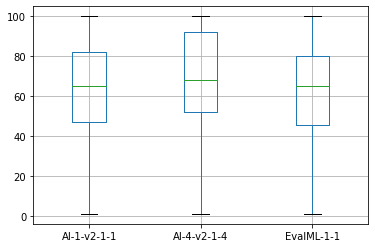

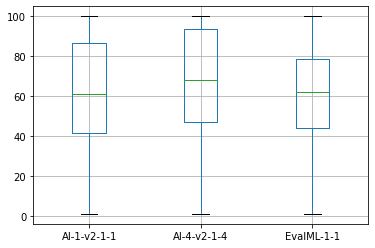


-------Nur mit vollständigen Daten------
AI-1-v2-1-1
Q1: 41.5 and Q3: 86.5
median: 61.0
mean: 61.08474576271186
std: 29.29
min: 1.0 und max: 100.0

AI-4-v2-1-4
Q1: 47.0 and Q3: 93.5
median: 68.0
mean: 66.91525423728814
std: 27.01
min: 1.0 und max: 100.0

EvalML-1-1
Q1: 44.0 and Q3: 78.5
median: 62.0
mean: 61.355932203389834
std: 24.88
min: 1.0 und max: 100.0



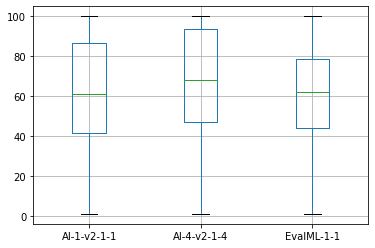


-----Average Improvements & je SuS T0-T0.5-----


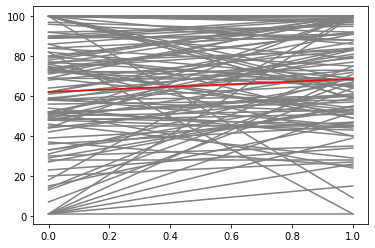

/Users/jean-philipp/Documents/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/core.py:1235: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


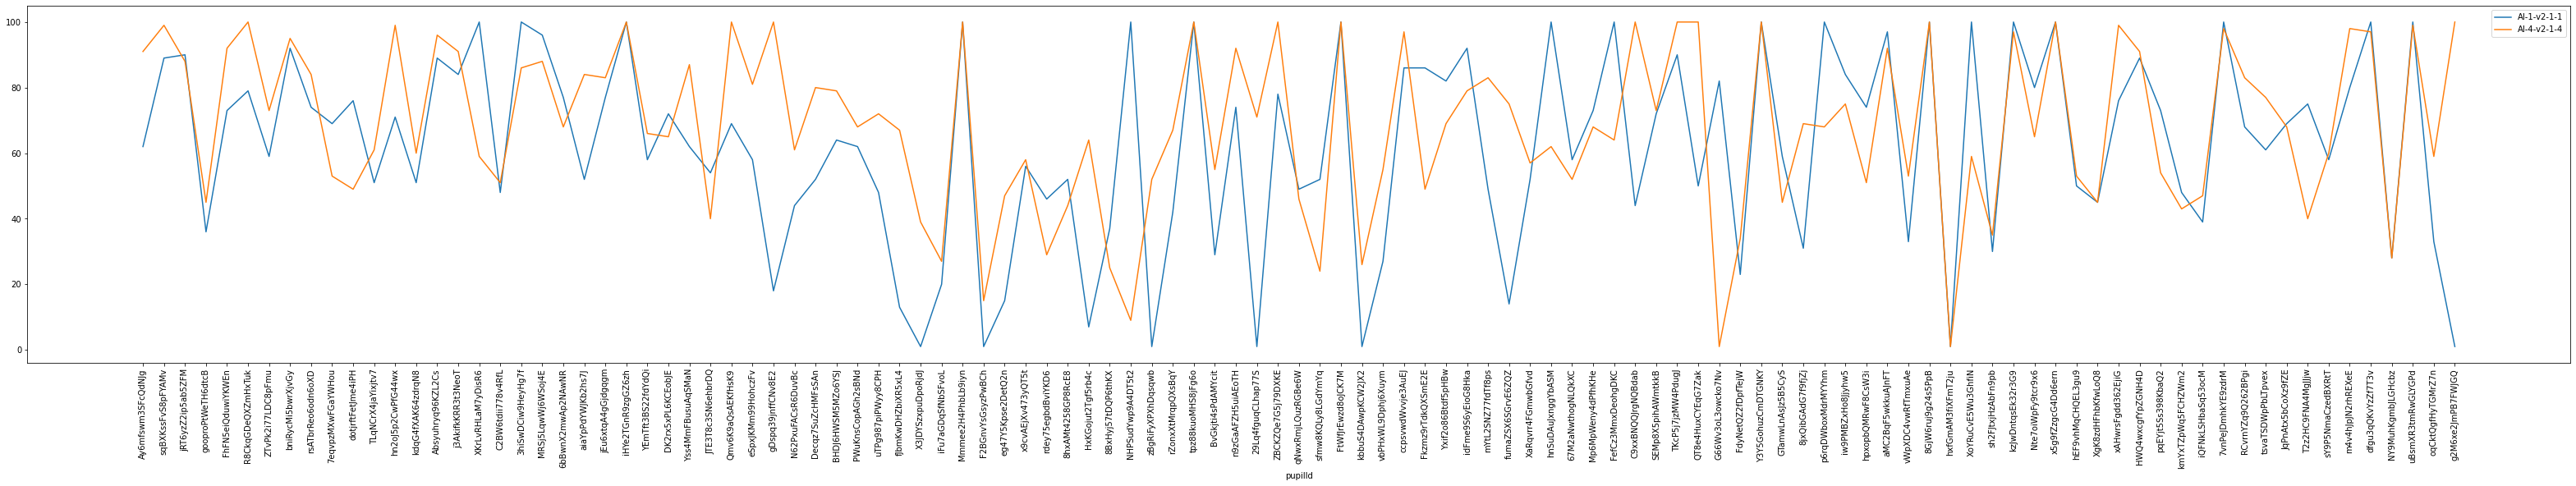

-----Average Improvements & je SuS T0.5-T1-----


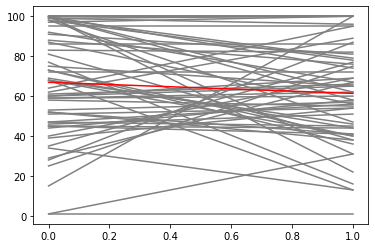

/Users/jean-philipp/Documents/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/core.py:1235: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


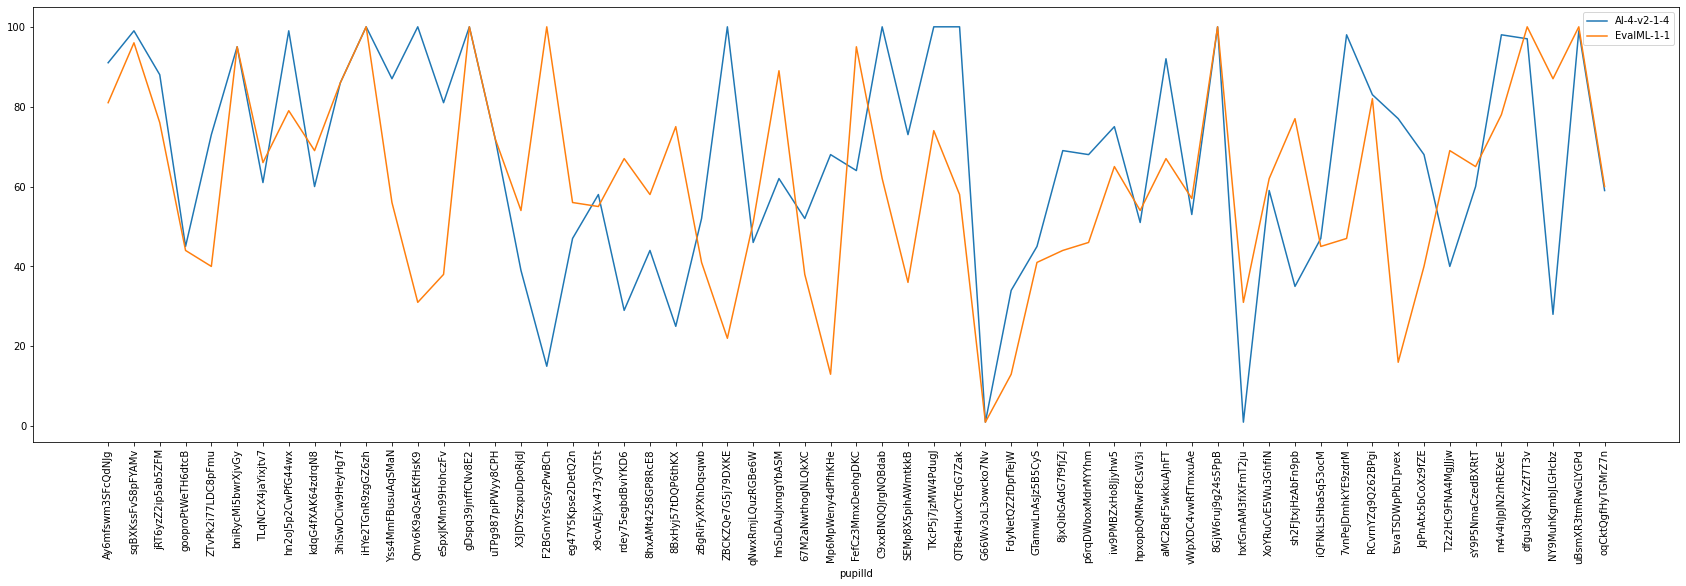

-----Average Improvements & je SuS T0-T1-----


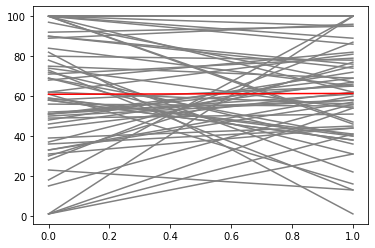

/Users/jean-philipp/Documents/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/core.py:1235: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


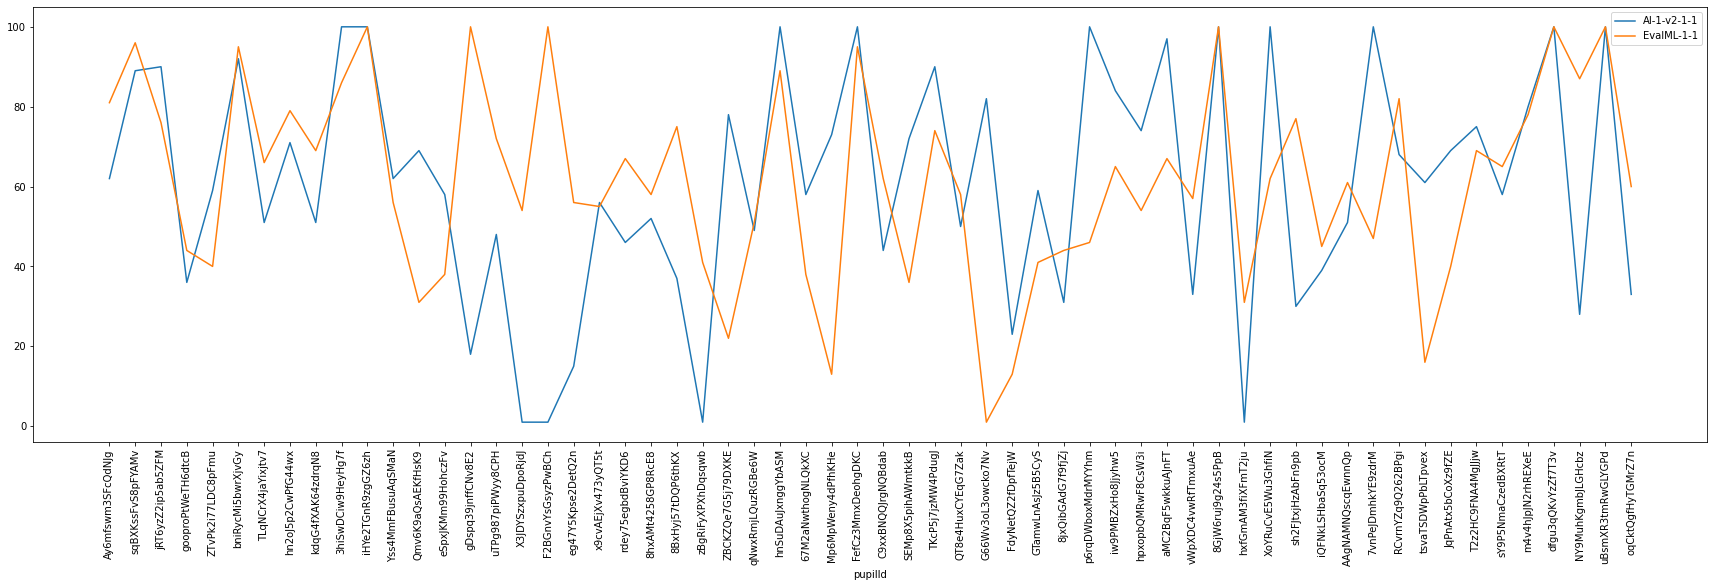

In [6]:
print("-------Mit allen Daten------")
surveySliderStatistics(pupil_performance_df["AI-1-v2-1-1"])
surveySliderStatistics(pupil_performance_df["AI-4-v2-1-4"])
surveySliderStatistics(pupil_performance_df["EvalML-1-1"])
pupil_performance_df.boxplot(column=["AI-1-v2-1-1", 'AI-4-v2-1-4', 'EvalML-1-1'])
plt.show()
pupil_performance_df.dropna(subset=["AI-1-v2-1-1", 'AI-4-v2-1-4', 'EvalML-1-1']).boxplot(column=["AI-1-v2-1-1", 'AI-4-v2-1-4', 'EvalML-1-1'])
plt.show()

print()
print("-------Nur mit vollständigen Daten------")
surveySliderStatistics(pupil_performance_df.dropna(subset=["AI-1-v2-1-1", 'AI-4-v2-1-4', 'EvalML-1-1'])["AI-1-v2-1-1"])
surveySliderStatistics(pupil_performance_df.dropna(subset=["AI-1-v2-1-1", 'AI-4-v2-1-4', 'EvalML-1-1'])["AI-4-v2-1-4"])
surveySliderStatistics(pupil_performance_df.dropna(subset=["AI-1-v2-1-1", 'AI-4-v2-1-4', 'EvalML-1-1'])["EvalML-1-1"])
pupil_performance_df.dropna(subset=["AI-1-v2-1-1", 'AI-4-v2-1-4', 'EvalML-1-1']).boxplot(column=["AI-1-v2-1-1", 'AI-4-v2-1-4', 'EvalML-1-1'])
plt.show()

print()


'''
print("Nach Klasse bei T0")
pupil_performance_df.groupby("classId")["AI-1-v2-1-1"].plot.kde()
plt.show()
'''

print("-----Average Improvements & je SuS T0-T0.5-----")
plot_improvements(pupil_performance_df[["AI-1-v2-1-1","AI-4-v2-1-4"]])
print("-----Average Improvements & je SuS T0.5-T1-----")
plot_improvements(pupil_performance_df[["AI-4-v2-1-4","EvalML-1-1"]])
print("-----Average Improvements & je SuS T0-T1-----")
plot_improvements(pupil_performance_df[["AI-1-v2-1-1","EvalML-1-1"]])


#### Was ist KI - Selbsteinschätzung - Test auf Normalverteilung
* wenn Daten normalverteilt sind --> gepaarte t-Test ist ein t-Test für 2 Stichproben, die voneinander abhängig sind
  * Voraussetzung für die Anwendung des gepaarten t-Tests ist, dass die Differenzen der gepaarten Daten – normalverteilt sind (samplesize must be at least 20 for one normality test in python). 60 SuS --> gilt
* wenn daten nicht normalverteilt: Wilcoxon signed rank test

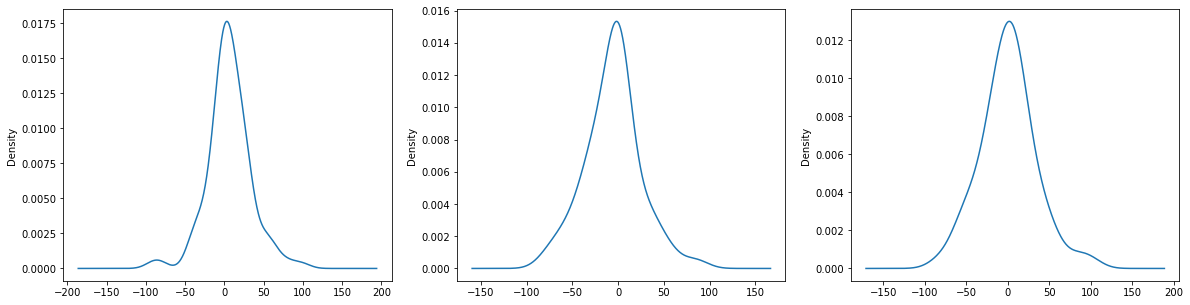


-----Test auf Normalverteilung-----
ShapiroResult(statistic=0.9526786208152771, pvalue=0.0006073114927858114)
ShapiroResult(statistic=0.9679651856422424, pvalue=0.12192942202091217)
ShapiroResult(statistic=0.9806115031242371, pvalue=0.4549465775489807)


In [32]:
# Paarweise differenzen berechnen
differences_0_05 = calculateDifferences(pupil_performance_df[["AI-4-v2-1-4", "AI-1-v2-1-1"]])
differences_05_1 = calculateDifferences(pupil_performance_df[["EvalML-1-1", "AI-4-v2-1-4"]])
differences_0_1 = calculateDifferences(pupil_performance_df[["EvalML-1-1", "AI-1-v2-1-1"]])

# Differenzen plotten
f, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True, figsize=(20,5))
plt.subplot(131)
pd.Series(differences_0_05).plot.kde()
plt.subplot(132)
pd.Series(differences_05_1).plot.kde()
plt.subplot(133)
pd.Series(differences_0_1).plot.kde()
plt.show()

# Testen, ob Differenzen normalverteilt sind
#print(stats.normaltest(differences_0_05))
#print(stats.normaltest(differences_05_1))
#print(stats.normaltest(differences_0_1))
# returns: statstics = s^2 + k^2, where s is the z-score returned by skewtest and k is the z-score returned by kurtosistest.
# returns: A 2-sided chi squared probability for the hypothesis test

#stat, p = stats.shapiro(differences)
print("\n-----Test auf Normalverteilung-----")
print(stats.shapiro(differences_0_05))
print(stats.shapiro(differences_05_1))
print(stats.shapiro(differences_0_1))

If the p value is less than our alpha (significance value), we can reject the hypothesis that this sample data is normally distributed. If greater, we cannot reject the null hypothesis and must conclude the data is normally distributed. 

pvalues normaltest:
* 0.0059 --> können die nullhypothese verwerfen, dass die Daten normalverteilt sind --> wilcoxon signed rank test (designed for paired comparisons on non-normal data)
* 0.24 --> können die nullhypothese nicht verwerfen --> gepaarte t-Test & vllt wilcoxon signed rank test
* 0.20 --> können die nullhypothese nicht verwerfen --> gepaarte t-Test & vllt wilcoxon signed rank test

p-values shapiro:
* 0.0006 --> können NH verwerfen, das normalverteilt --> nicht normalverteilt --> wilcoxon signed rank test
* 0.12 --> können NH das normalvert ist nicht verwerfen --> gepaarter t-test & vllt wilcoxon signed rank
* 0.45 --> können NH das normalvert ist nicht verwerfen --> gepaarter t-test & vllt wilcoxon signed rank

#### Was ist KI - Selbsteinschätzung - Signifikanztest


In [14]:
print("-----Wilcoxon-----")
print(stats.wilcoxon(differences_0_05))
print(stats.wilcoxon(differences_05_1))
print(stats.wilcoxon(differences_0_1))
#returns: statistics and pvalue
# statistics: If alternative is “two-sided”, the sum of the ranks of the differences above or below zero, whicheveris smaller. Otherwise the sum of the ranks of the differences above zero.

print("\n-----Korrekte Analyse-----")
print(stats.wilcoxon(differences_0_05))
print(stats.ttest_rel(pupil_performance_df.dropna(subset=["AI-1-v2-1-1", 'AI-4-v2-1-4', 'EvalML-1-1'])["AI-4-v2-1-4"], pupil_performance_df.dropna(subset=["AI-1-v2-1-1", 'AI-4-v2-1-4', 'EvalML-1-1'])["EvalML-1-1"]))
print(stats.ttest_rel(pupil_performance_df.dropna(subset=["AI-1-v2-1-1", 'AI-4-v2-1-4', 'EvalML-1-1'])["AI-1-v2-1-1"], pupil_performance_df.dropna(subset=["AI-1-v2-1-1", 'AI-4-v2-1-4', 'EvalML-1-1'])["EvalML-1-1"]))

print("\n-----Effektstärken-----")
print(cohen_d(pupil_performance_df.dropna(subset=["AI-1-v2-1-1", 'AI-4-v2-1-4', 'EvalML-1-1'])["AI-1-v2-1-1"], pupil_performance_df.dropna(subset=["AI-1-v2-1-1", 'AI-4-v2-1-4', 'EvalML-1-1'])["AI-4-v2-1-4"]))
#print(print(cohen_d(pupil_performance_df.dropna(subset=["AI-1-v2-1-1", 'AI-4-v2-1-4', 'EvalML-1-1'])["AI-4-v2-1-4"], pupil_performance_df.dropna(subset=["AI-1-v2-1-1", 'AI-4-v2-1-4', 'EvalML-1-1'])["EvalML-1-1"])))
#print(print(cohen_d(pupil_performance_df.dropna(subset=["AI-1-v2-1-1", 'AI-4-v2-1-4', 'EvalML-1-1'])["AI-1-v2-1-1"], pupil_performance_df.dropna(subset=["AI-1-v2-1-1", 'AI-4-v2-1-4', 'EvalML-1-1'])["EvalML-1-1"])))


-----Wilcoxon-----
WilcoxonResult(statistic=1755.0, pvalue=0.005437282165958155)
WilcoxonResult(statistic=527.5, pvalue=0.1412654329095244)
WilcoxonResult(statistic=795.0, pvalue=0.9804734656205535)

-----Korrekte Analyse-----
WilcoxonResult(statistic=1755.0, pvalue=0.005437282165958155)
Ttest_relResult(statistic=1.4189404188314818, pvalue=0.16126815014118778)
Ttest_relResult(statistic=-0.062161081908979274, pvalue=0.9506482755564919)

-----Effektstärken-----
-0.20696290149957172


Ergebnisse:
* von 0 nach 05:
  * sehr kleines p (0.005) --> your data are unlikely with a true null --> null, dass sie von der gleichen population kommen also unwahrscheinlich --> signifikantes ergebnis, dass es einen effekt gab
  * effektstärke: 0.2069 --> schwacher effekt
* von 05 nach 1:
  * wilcoxon:
    * p (0.14) --> daten sind wahrscheinlich mit null hypothese, dass sie von gleicher population kommen --> Kein Effekt gefunden
    * daher keine effektstärke
  * gepaarter T-Test:
    * p 0.16 --> keine signifikanz
* von 0 nach 1:
  * wilcoxon: großes p 0.98 --> können null hypothese nicht verwerfen --> keine beweise für effekt
  * gepaarter T-test: p 0.950 --> können NH nicht verwerfen --> kein beweis für effekt
  * keine signifikanz --> keine effektstärke berechnen

### 1.2 Freitext zu "Was ist KI"

#### 1.2.1 Teacher Rating

* T0: AI-1-v2-1-2
* T1: 'AI-4-v2-1-3'

In [29]:
surveySliderStatistics(pupil_performance_df["AI-1-v2-1-2_rating_content"])
surveySliderStatistics(pupil_performance_df["AI-4-v2-1-3_rating_content"])

differences_content = calculateDifferences(pupil_performance_df[["AI-4-v2-1-3_rating_content", "AI-1-v2-1-2_rating_content"]])

print(stats.shapiro(differences_content))
print(stats.wilcoxon(differences_content))
#print(stats.ttest_rel(pupil_performance_df.dropna(subset=["AI-4-v2-1-3_rating_content", "AI-1-v2-1-2_rating_content"])["AI-1-v2-1-2_rating_content"], pupil_performance_df.dropna(subset=["AI-4-v2-1-3_rating_content", "AI-1-v2-1-2_rating_content"])["AI-4-v2-1-3_rating_content"]))

AI-1-v2-1-2_rating_content
Q1: 4.0 and Q3: 5.0
median: 5.0
mean: 4.168421052631579
std: 1.1
min: 0.0 und max: 5.0

AI-4-v2-1-3_rating_content
Q1: 3.0 and Q3: 5.0
median: 4.0
mean: 3.951219512195122
std: 1.32
min: 0.0 und max: 5.0

ShapiroResult(statistic=0.9061924815177917, pvalue=1.807722946978174e-05)
WilcoxonResult(statistic=355.5, pvalue=0.14127361343004882)


results:
* normality test: 1.807722946978174e-05 --> reject NH --> daten nicht normalverteilt
* wilcoxon: pvalue ist 0.1412 --> your data are likely with a true null --> null war: observed difference in the sample does not reflect a true difference between populations --> keine beweise dafür, dass das Paket einen Effekt auf die content ratings hatten

Teacher Ratings ignorieren!


##### 1.2.2.1 Was ist KI - Freitext  - nullanswers und unknown

Unknown ist True, wenn:
* die SuS explizit sagen, dass sie es nicht wissen

Nullanswers sind True, wenn keine Aussage über deren Wissensstand gemacht werden kann, zB weil:
* sie nichts/Quatsch ("." / "osdhsl") abgeben oder nicht auf die frage antworten ("lul" etc)
* offensichtliche Plagiate (gelten nur, wenn der genaue Wortlaut ergoogelt werden konnte)

In [48]:
#Signifikanz der Veränderungen der Populationsverhältnisse

proportionT0unknown = pupil_performance_df_rated[["AI-1-v2-1-2_unknown"]].value_counts()[True].values[0] / (pupil_performance_df_rated[["AI-1-v2-1-2_unknown"]].value_counts()[False].values[0] + pupil_performance_df_rated[["AI-1-v2-1-2_unknown"]].value_counts()[True].values[0])
proportionT1unknown = pupil_performance_df_rated[["AI-4-v2-1-3_unknown"]].value_counts()[True].values[0] / (pupil_performance_df_rated[["AI-4-v2-1-3_unknown"]].value_counts()[False].values[0] + pupil_performance_df_rated[["AI-4-v2-1-3_unknown"]].value_counts()[True].values[0])
proportionT0null = pupil_performance_df_rated[["AI-1-v2-1-2_null_answer"]].value_counts()[True].values[0] / (pupil_performance_df_rated[["AI-1-v2-1-2_null_answer"]].value_counts()[False].values[0] + pupil_performance_df_rated[["AI-1-v2-1-2_null_answer"]].value_counts()[True].values[0])
proportionT1null = pupil_performance_df_rated[["AI-4-v2-1-3_null_answer"]].value_counts()[True].values[0] / (pupil_performance_df_rated[["AI-4-v2-1-3_null_answer"]].value_counts()[False].values[0] + pupil_performance_df_rated[["AI-4-v2-1-3_null_answer"]].value_counts()[True].values[0])

print("-----deskriptiv-----")
print("Proportion Unknown: ", proportionT0unknown, "-->", proportionT1unknown)
print("Proportion Nullanswers: ", proportionT0null, "-->", proportionT1null, "\n")

print("-----Signifikanz-----")
countUn = np.array([pupil_performance_df_rated[["AI-1-v2-1-2_unknown"]].value_counts()[True].values[0], pupil_performance_df_rated[["AI-4-v2-1-3_unknown"]].value_counts()[True].values[0]])
nobsUn = np.array([(pupil_performance_df_rated[["AI-1-v2-1-2_unknown"]].value_counts()[False].values[0] + pupil_performance_df_rated[["AI-1-v2-1-2_unknown"]].value_counts()[True].values[0]), (pupil_performance_df_rated[["AI-4-v2-1-3_unknown"]].value_counts()[False].values[0] + pupil_performance_df_rated[["AI-4-v2-1-3_unknown"]].value_counts()[True].values[0])])
statUn, pvalUn = proportions_ztest(countUn, nobsUn)
print("Unknown --> stat: ", statUn, " pval", pvalUn)

countNu = np.array([pupil_performance_df_rated[["AI-1-v2-1-2_null_answer"]].value_counts()[True].values[0], pupil_performance_df_rated[["AI-4-v2-1-3_null_answer"]].value_counts()[True].values[0]])
nobsNu = np.array([(pupil_performance_df_rated[["AI-1-v2-1-2_null_answer"]].value_counts()[False].values[0] + pupil_performance_df_rated[["AI-1-v2-1-2_null_answer"]].value_counts()[True].values[0]), (pupil_performance_df_rated[["AI-4-v2-1-3_null_answer"]].value_counts()[False].values[0] + pupil_performance_df_rated[["AI-4-v2-1-3_null_answer"]].value_counts()[True].values[0])])
statNu, pvalNu = proportions_ztest(countNu, nobsNu)
print("Nullanswers --> stat: ", statNu, " pval", pvalNu)

-----deskriptiv-----
Proportion Unknown:  0.014184397163120567 --> 0.02702702702702703
Proportion Nullanswers:  0.09929078014184398 --> 0.11711711711711711 

-----Signifikanz-----
Unknown --> stat:  -0.7257579524607306  pval 0.4679871677810682
Nullanswers --> stat:  -0.4542137601693293  pval 0.6496749800717339


keine signifikanz
und in relativen werten kleine (aber nicht signifikante) verschlechterung - kann daran liegen, dass fast alle SuS schon eine meinung zur KI haben.

#### 1.2.2 Was ist KI - Freitext - Desktipriv
##### Korrekte, Inkorrekte und Irrelevante Punkte vorher und nachher

In [20]:
print("-----correct points-----")
surveySliderStatistics(pupil_performance_df_rated["AI-1-v2-1-2_correct_points"])
surveySliderStatistics(pupil_performance_df_rated["AI-4-v2-1-3_correct_points"])

print("\n-----incorrect points-----")
surveySliderStatistics(pupil_performance_df_rated["AI-1-v2-1-2_incorrect_points"])
surveySliderStatistics(pupil_performance_df_rated["AI-4-v2-1-3_incorrect_points"])

print("\n-----irrelevant points-----")
surveySliderStatistics(pupil_performance_df_rated["AI-1-v2-1-2_irrelevant_points"])
surveySliderStatistics(pupil_performance_df_rated["AI-4-v2-1-3_irrelevant_points"])

-----correct points-----
AI-1-v2-1-2_correct_points
Q1: 0.0 and Q3: 1.0
median: 0.0
mean: 0.6170212765957447
std: 0.95
min: 0.0 und max: 7.0

AI-4-v2-1-3_correct_points
Q1: 0.0 and Q3: 3.0
median: 1.0
mean: 1.6727272727272726
std: 1.76
min: 0.0 und max: 6.0


-----incorrect points-----
AI-1-v2-1-2_incorrect_points
Q1: 0.0 and Q3: 1.0
median: 1.0
mean: 0.5460992907801419
std: 0.57
min: 0.0 und max: 2.0

AI-4-v2-1-3_incorrect_points
Q1: 0.0 and Q3: 0.0
median: 0.0
mean: 0.19090909090909092
std: 0.39
min: 0.0 und max: 1.0


-----irrelevant points-----
AI-1-v2-1-2_irrelevant_points
Q1: 0.0 and Q3: 1.0
median: 0.0
mean: 0.3262411347517731
std: 0.54
min: 0.0 und max: 2.0

AI-4-v2-1-3_irrelevant_points
Q1: 0.0 and Q3: 0.0
median: 0.0
mean: 0.16363636363636364
std: 0.37
min: 0.0 und max: 1.0



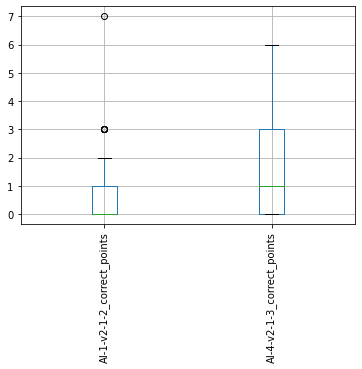

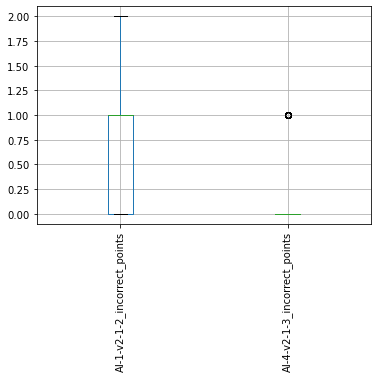

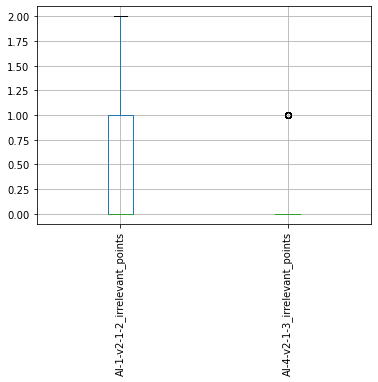

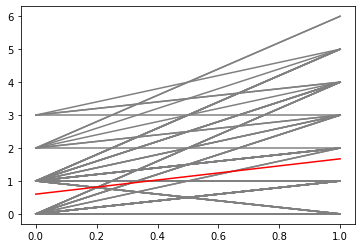

/Users/jean-philipp/Documents/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/core.py:1235: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


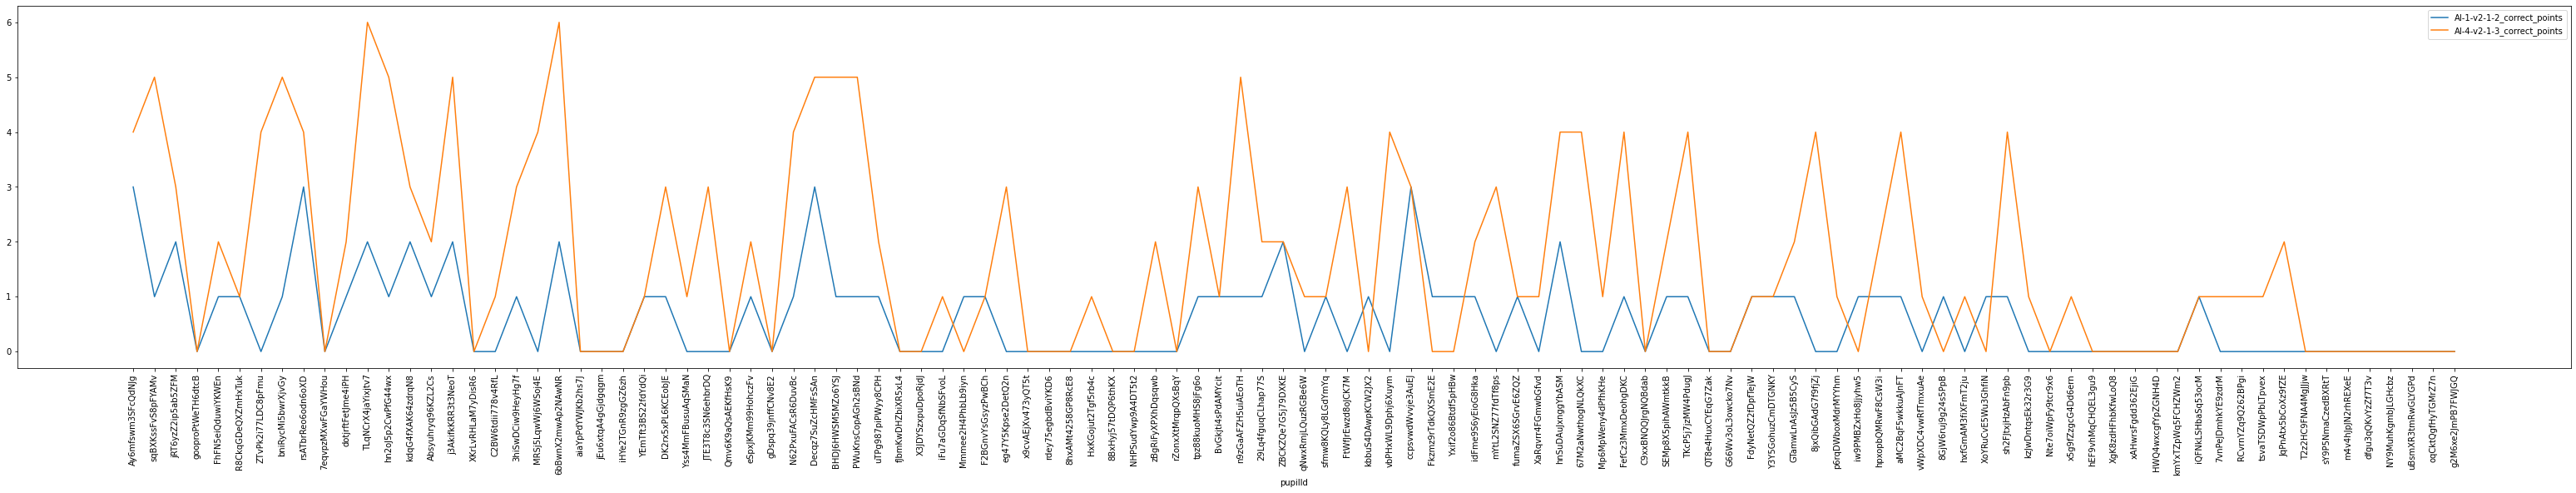

In [64]:
pupil_performance_df_rated.boxplot(column=["AI-1-v2-1-2_correct_points", "AI-4-v2-1-3_correct_points"])
plt.xticks(rotation = 90)
plt.show()

pupil_performance_df_rated.boxplot(column=['AI-1-v2-1-2_incorrect_points', "AI-4-v2-1-3_incorrect_points"])
plt.xticks(rotation = 90)
plt.show()

pupil_performance_df_rated.boxplot(column=['AI-1-v2-1-2_irrelevant_points', "AI-4-v2-1-3_irrelevant_points"])
plt.xticks(rotation = 90)
plt.show()

#pupil_performance_df_rated.boxplot(column=["AI-1-v2-1-2_correct_points", 'AI-1-v2-1-2_incorrect_points', 'AI-1-v2-1-2_irrelevant_points', "AI-4-v2-1-3_correct_points", "AI-4-v2-1-3_incorrect_points", "AI-4-v2-1-3_irrelevant_points"])
#plt.xticks(rotation = 90)
#plt.show()

plot_improvements(pupil_performance_df_rated[["AI-1-v2-1-2_correct_points", "AI-4-v2-1-3_correct_points"]])
#plot_improvements(pupil_performance_df_rated[["AI-1-v2-1-2_incorrect_points", "AI-4-v2-1-3_incorrect_points"]])
#plot_improvements(pupil_performance_df_rated[["AI-1-v2-1-2_irrelevant_points", "AI-4-v2-1-3_irrelevant_points"]])
#zu wenige inkorrekte und irrelevante, damit die grafik gut aussieht

#### 1.2.2 Was ist KI - Freitext - Signifikanz und Effektstärke

In [28]:
# AI-1-v2-1-2, AI-4-v2-1-3
KIdifferences_correct = calculateDifferences(pupil_performance_df_rated[["AI-4-v2-1-3_correct_points", "AI-1-v2-1-2_correct_points"]])
KIdifferences_incorrect = calculateDifferences(pupil_performance_df_rated[["AI-4-v2-1-3_incorrect_points", "AI-1-v2-1-2_incorrect_points"]])
KIdifferences_irrelevant = calculateDifferences(pupil_performance_df_rated[["AI-4-v2-1-3_irrelevant_points", "AI-1-v2-1-2_irrelevant_points"]])

print("-----Shapiro-----")
print(stats.shapiro(KIdifferences_correct))
print(stats.shapiro(KIdifferences_incorrect))
print(stats.shapiro(KIdifferences_irrelevant))

-----Shapiro-----
ShapiroResult(statistic=0.8384885787963867, pvalue=1.305472729917767e-09)
ShapiroResult(statistic=0.7984391450881958, pvalue=5.6548245253029705e-11)
ShapiroResult(statistic=0.7154148817062378, pvalue=2.6473728808110164e-13)


* alle p unter 0.05 --> reject NH --> keine normalverteilt

In [35]:
print("-----Signifikanz-----")
print(stats.wilcoxon(KIdifferences_correct))
print(stats.wilcoxon(KIdifferences_incorrect))
print(stats.wilcoxon(KIdifferences_irrelevant))
#print(stats.ttest_rel(pupil_performance_df_rated.dropna(subset=["AI-4-v2-1-3_irrelevant_points", 'AI-1-v2-1-2_irrelevant_points'])["AI-1-v2-1-2_irrelevant_points"], pupil_performance_df_rated.dropna(subset=["AI-4-v2-1-3_irrelevant_points", 'AI-1-v2-1-2_irrelevant_points'])["AI-4-v2-1-3_irrelevant_points"]))

-----Signifikanz-----
WilcoxonResult(statistic=129.5, pvalue=1.8654411486123266e-10)
WilcoxonResult(statistic=157.5, pvalue=9.772908827267116e-07)
WilcoxonResult(statistic=112.0, pvalue=0.0021254574441375456)


Ergebnisse:
  * sehr signifikantes ergebnis (1.8e-10) für korrekte: nehmen zu (was gibt effektstärke hier an?)
  * sehr signifikantes (9.7e-07) für inkorrekte: nehmen ab
  * signifikant (0.002) bzw 0.0018 für irrelevante, nehmen ab

In [36]:
print("\n-----Effektstärke-----")
#print(cohen_d(pupil_performance_df_rated.dropna(subset=["AI-4-v2-1-3_correct_points", "AI-1-v2-1-2_correct_points"])["AI-4-v2-1-3_correct_points"], pupil_performance_df_rated.dropna(subset=["AI-4-v2-1-3_correct_points", "AI-1-v2-1-2_correct_points"])["AI-1-v2-1-2_correct_points"]))
print(cohen_d(pupil_performance_df_rated.dropna(subset=["AI-4-v2-1-3_correct_points", "AI-1-v2-1-2_correct_points"])["AI-1-v2-1-2_correct_points"], pupil_performance_df_rated.dropna(subset=["AI-4-v2-1-3_correct_points", "AI-1-v2-1-2_correct_points"])["AI-4-v2-1-3_correct_points"]))
print(cohen_d(pupil_performance_df_rated.dropna(subset=["AI-4-v2-1-3_incorrect_points", "AI-1-v2-1-2_incorrect_points"])["AI-1-v2-1-2_incorrect_points"], pupil_performance_df_rated.dropna(subset=["AI-4-v2-1-3_incorrect_points", "AI-1-v2-1-2_incorrect_points"])["AI-4-v2-1-3_incorrect_points"]))
print(cohen_d(pupil_performance_df_rated.dropna(subset=["AI-4-v2-1-3_irrelevant_points", 'AI-1-v2-1-2_irrelevant_points'])["AI-1-v2-1-2_irrelevant_points"], pupil_performance_df_rated.dropna(subset=["AI-4-v2-1-3_irrelevant_points", 'AI-1-v2-1-2_irrelevant_points'])["AI-4-v2-1-3_irrelevant_points"]))


-----Effektstärke-----
-0.7893522973905193
0.6918907834553231
0.39772698477982155


Ergebnisse Effektstärke:
* korrekte: -0.7893522973905193 → starker effekt
* inkorrekte: 0.6918907834553231 → mittlerer bis starker effekt
* irrelevante: 0.39772698477982155 → schwacher bis mittlerer effekt

##### Gibt es Unterschiede zwischen den Klassen?

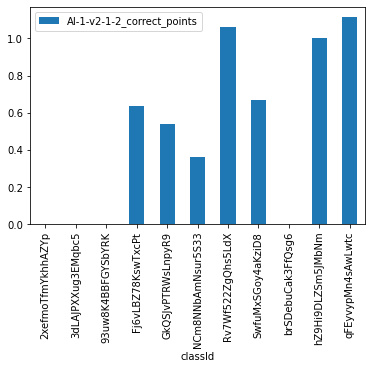

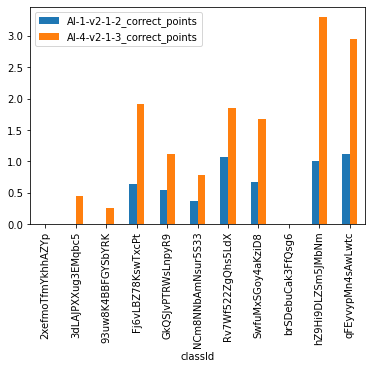

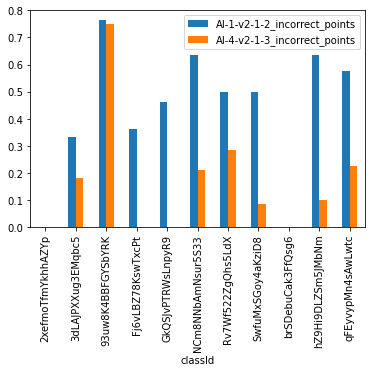

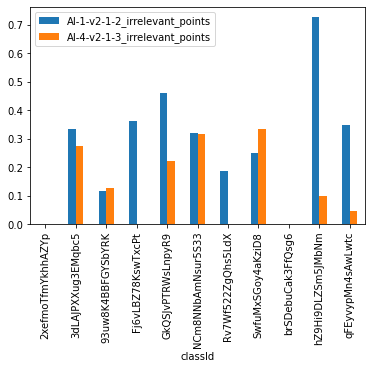

In [39]:
pupil_performance_df_rated.groupby("classId")[["AI-1-v2-1-2_correct_points"]].agg(np.mean).plot.bar()
plt.show()

Manche Klassen haben schon etwas über KI gelernt. zB in "qFEyvypMn4sAwLwtc" wurde oft Deep Learning referenziert und teilweise sogar erklärt.

##### Lernfortschritt nach Klasse

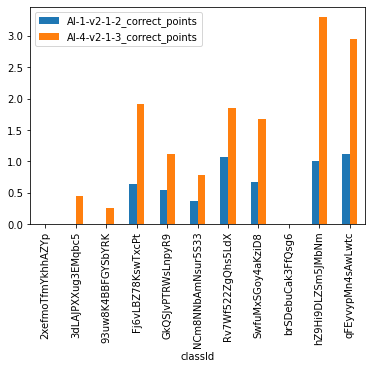

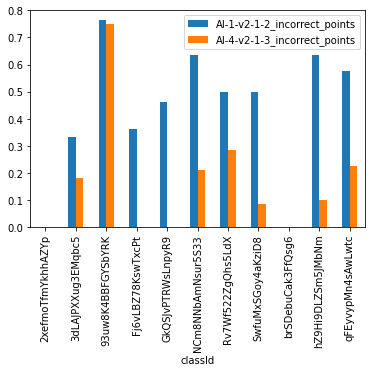

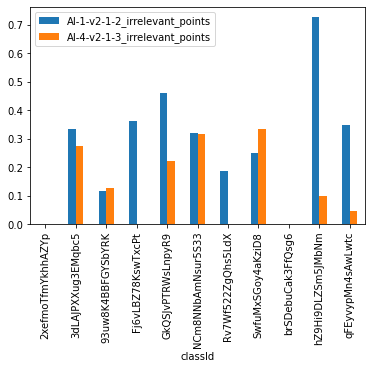

In [40]:
pupil_performance_df_rated.groupby("classId")[["AI-1-v2-1-2_correct_points", "AI-4-v2-1-3_correct_points"]].agg(np.mean).plot(y=["AI-1-v2-1-2_correct_points", "AI-4-v2-1-3_correct_points"], kind="bar")
plt.show() # der ist eine gute veranschaulichung, dass sie etwas gelernt haben
pupil_performance_df_rated.groupby("classId")[["AI-1-v2-1-2_incorrect_points", "AI-4-v2-1-3_incorrect_points"]].agg(np.mean).plot(y=["AI-1-v2-1-2_incorrect_points", "AI-4-v2-1-3_incorrect_points"], kind="bar")
plt.show() #der ist okay
pupil_performance_df_rated.groupby("classId")[["AI-1-v2-1-2_irrelevant_points", "AI-4-v2-1-3_irrelevant_points"]].agg(np.mean).plot(y=["AI-1-v2-1-2_irrelevant_points", "AI-4-v2-1-3_irrelevant_points"], kind="bar")
plt.show() #der ist egal


Trotz unterschiedlichem Startpunkt scheinen alle Klassen zu lernen

### 1.3 Was ist KI - MC
#### 1.3.1 Was ist KI - MC - Wo ist KI drinne?
* AI-2-v2-1-1
* "EvalML-1-4"
* AI-4-v2-1-2 antworten 1-2
* EvalML-1-3 antworten 1-3: was ist KI

In [9]:
analyse_mc(["AI-2-v2-1-1"], 4)

AI-2-v2-1-1
Kannst du erkennen, wo KI überall drin steckt? Denke dabei an die Eigenschaften, die alle KI-Anwendungen verbindet. Bei Multiple-Choice Aufgaben, neben denen “Mehrfachauswahl” steht, können mehrere Antworten richtig sein. Wähle alle richtigen Antworten aus. Wenn du mal nicht weiter weißt, kannst du dir auch einen Tipp holen.
*Der Newsfeed eines Social Network nutzt KI - True
*Die Personalisierung einer Google-Anfrage nutzt KI - True
*Die Startseite einer Webseite, die jedem Besucher die gleichen Inhalte anzeigt nutzt KI - False
*Gesichtserkennung nutzt KI - True
[True, True, False, True]

[0, 1, 0, 0, 0, 0, 2, 0, 0, 2, 0, 1, 0, 0, 0, 0, 0, 2, 1, 1, 0, 1, 0, 0, 0, 1, 1, 2, 3, 2, 1, 2, 2, 1, 0, 0, 3, 2, 0, 1, 0, 2, 2, 2, 1, 2, 2, 0, 1, 2, 3, 1, 2, 2, 3, 1, 3, 1, 0, 1, 1, 0, 2, 1, 0, 2, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 2, 1, 1, 0, 2, 0, 0, 1, 2, 0, 1, 0, 1, 1, 0, 1, 2, 0, 2, 1, 1, 2, 2, 1, 2, 4, 2, 1, 2, 2, 1, 3, 0, 3, 1, 0, 2, 1, 3, 3, 3, 2, 1, 2, 2, 3, 1, 1, 1, 1, 1

In [31]:
number_errors_sus = [0, 1, 0, 0, 0, 0, 2, 0, 0, 2, 0, 1, 0, 0, 0, 0, 0, 2, 1, 1, 0, 1, 0, 0, 0, 1, 1, 2, 3, 2, 1, 2, 2, 1, 0, 0, 3, 2, 0, 1, 0, 2, 2, 2, 1, 2, 2, 0, 1, 2, 3, 1, 2, 2, 3, 1, 3, 1, 0, 1, 1, 0, 2, 1, 0, 2, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 2, 1, 1, 0, 2, 0, 0, 1, 2, 0, 1, 0, 1, 1, 0, 1, 2, 0, 2, 1, 1, 2, 2, 1, 2, 4, 2, 1, 2, 2, 1, 3, 0, 3, 1, 0, 2, 1, 3, 3, 3, 2, 1, 2, 2, 3, 1, 1, 1, 1, 1]
cohen_d(random_mcs(len(number_errors_sus), 4), number_errors_sus)

0.5797743772626206

* 1.10 statt erwarteter 2 errors. p-value 3.63e-11 bzw average p-value: 3.71e-09 --> signifikanz
* effektstärke: ca 0.579 --> (0.2 wäre leicht, 0.5 mittel, 0.8 stark) --> mittlerer effekt

#### 1.3.2 Was ist KI? - MC - Definition KI

In [26]:
print_mc(["AI-4-v2-1-2"])
print("Average p-value mannwhitneyu: ", mannwhitneymanual(analyse_partial_mc("AI-4-v2-1-2", 1, 2), 2))

AI-4-v2-1-2
Lass uns noch einmal das Wichtigste wiederholen! Welche dieser Aussagen stimmen?
*KI-Anwendungen treffen eigenständige Entscheidungen - True
*KI-Anwendungen lernen durch Erfahrung - True
*Intelligentes Verhalten setzt allgemeine Intelligenz voraus - False
*Heutige KI-Anwendungen gehören alle zur spezifischen KI - True
*Spezifische KI umfasst Anwendungen, die menschenähnliche Intelligenz in einem kleinen Bereich zeigen - True
*Ein Spam-Filter ist eine allgemeinen KI - False
*Eine KI, die in allen Bereichen so schlau ist wie ein Mensch, gibt es noch nicht - True
[True, True, False, True, True, False, True]

[0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 2, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 2, 0, 1, 1, 0, 1, 1, 0, 0, 2, 0, 1, 0, 0, 1, 1, 0, 2, 2, 1, 1, 0, 1, 0, 0, 1, 2, 0, 1, 1, 1, 1, 1, 1, 2, 1, 0, 1, 0, 1, 0, 0, 1, 2, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 2, 1, 2, 1, 1, 1, 1, 0]
Average number errors: AI-4-v2-1-2 0.7747

In [32]:
number_errors_sus = [0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 2, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 2, 0, 1, 1, 0, 1, 1, 0, 0, 2, 0, 1, 0, 0, 1, 1, 0, 2, 2, 1, 1, 0, 1, 0, 0, 1, 2, 0, 1, 1, 1, 1, 1, 1, 2, 1, 0, 1, 0, 1, 0, 0, 1, 2, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 2, 1, 2, 1, 1, 1, 1, 0]
number_questions = 2

cohen_d(random_mcs(len(number_errors_sus), number_questions), number_errors_sus)

0.2168653573413553

* 0.77 statt 1 expected error
* p-wert 0.034 --> signifikanz
* effektstärke: 0.216 --> leichter effekt

#### Was ist KI - MCs - ???

In [28]:
analyse_combined_mcs("EvalML-1-3", "EvalML-1-4", 1, 3, 1, 4)

EvalML-1-3
Welche der Aussagen stimmen?
*KI-Anwendungen zeichnen sich dadurch aus, dass sie intelligentes Verhalten zeigen, autonom funktionieren und mit Erfahrung lernen - True
*Eine fertige KI-Anwendung kann nicht ohne Hilfe von einem Menschen funktionieren - False
*Eine fertige KI-Anwendung kann nicht mit Erfahrung lernen, sie bleibt, wie sie ist - False
*Eine spezifische KI zeigt intelligentes Verhalten in einem kleinen Bereich - True
*Jede KI hat allgemeine Intelligenz. Damit ist jede KI eine allgemeine KI - False
*Ein Programm, dass so gut Schach spielen kann, wie Menschen, ist ein Beispiel für eine spezifische KI - True
*Derzeit gibt es sowohl Anwendungen, die zur spezifischen, als auch welche, die zur allgemeinen KI gehören - False
*KI kann irgendwann alles besser als der Mensch - False
*Jeder Mensch wird zukünftig eine Vielzahl verschiedener KIs in seinem Alltag nutzen - True
[True, False, False, True, False, True, False, False, True]

EvalML-1-4
Welche der folgenden Anwendung

In [33]:
number_errors_sus = [1, 1, 3, 3, 0, 1, 1, 1, 1, 2, 2, 4, 2, 1, 0, 0, 1, 1, 2, 0, 1, 1, 0, 4, 2, 1, 1, 2, 2, 1, 0, 2, 3, 2, 5, 1, 2, 0, 2, 0, 3, 1, 1, 2, 2, 1, 2, 2, 2, 3, 3, 3, 1, 4, 2, 4, 2, 3, 3, 3, 3, 6, 2, 0, 2, 3, 0, 1, 1, 1, 1, 0]
number_questions = 7

cohen_d(random_mcs(len(number_errors_sus), number_questions), number_errors_sus)

0.9131876861434052

* 0.93+0.81=1.575 fehler statt 1.5+2=3.5 expected raten also nicht nur --> erkennen, wo ki drin ist
* small p-value 0.02 --> probability of obtaining test results under the assumption that the null hypothesis is correct are small --> alternative hypothesis more likely --> different populations --> Lernzuwachs
* effektstärke: 0.91 --> starker effekt (aber verglichen mit komplett raten!)

## 2. Unterschied spezifisch und allgemeine KI
### 2.1 Selbsteinschätzungen
<b>Hier gibt es keinen T0, nur T0.5 und T1</b>

AI-4-v2-1-5
Q1: 42.0 and Q3: 89.0
median: 60.0
mean: 61.06306306306306
std: 29.92
min: 1.0 und max: 100.0

EvalML-1-2
Q1: 47.75 and Q3: 83.25
median: 59.5
mean: 62.375
std: 27.06
min: 1.0 und max: 100.0



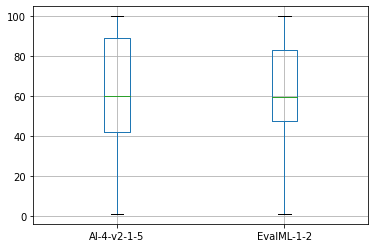

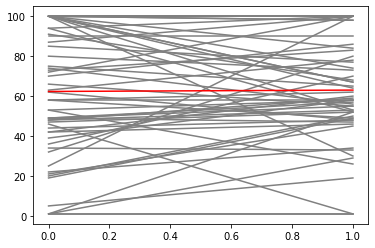

/Users/jean-philipp/Documents/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/core.py:1235: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


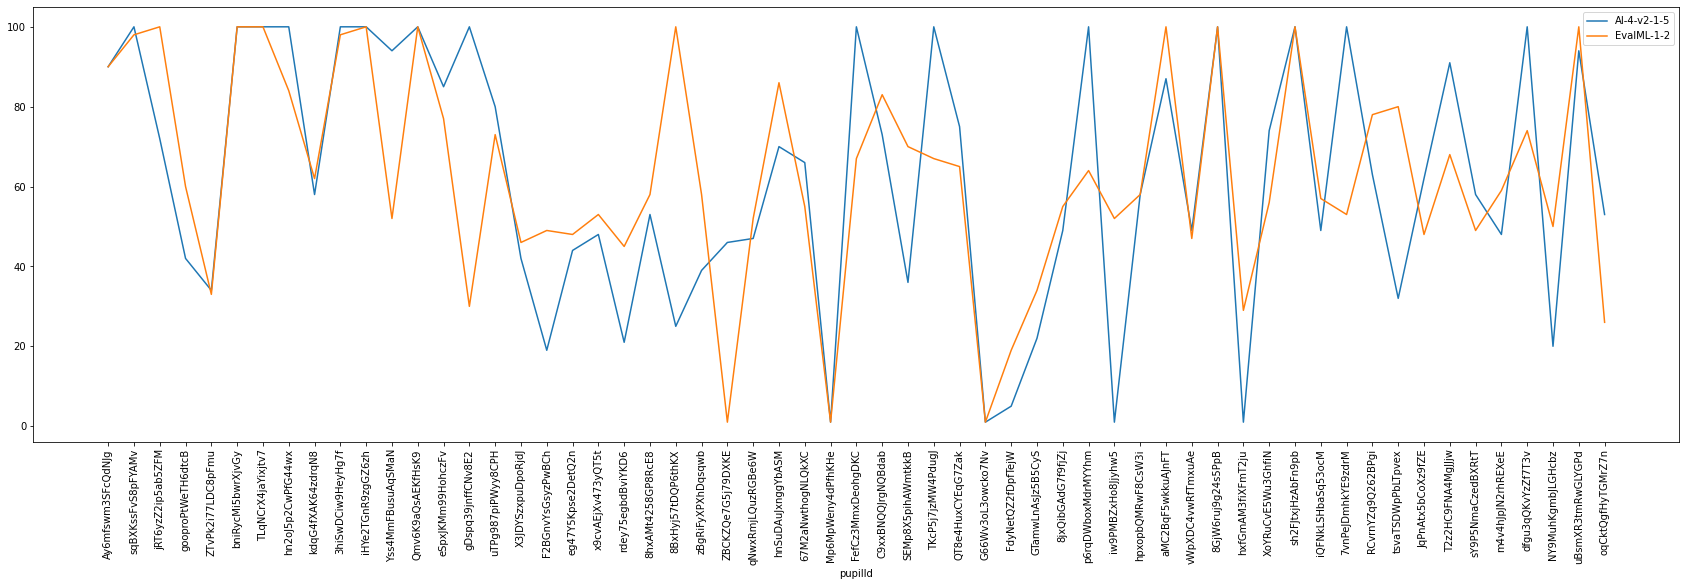

In [35]:
surveySliderStatistics(pupil_performance_df["AI-4-v2-1-5"])
surveySliderStatistics(pupil_performance_df["EvalML-1-2"])

pupil_performance_df.boxplot(column=['AI-4-v2-1-5', 'EvalML-1-2'])
plt.show()

plot_improvements(pupil_performance_df[['AI-4-v2-1-5', 'EvalML-1-2']])

### 2.2 spezifische vs allgemein KI - MCs
#### 2.2.1 spezifische vs allgemein KI - MCs - Def

In [38]:
analyse_mc(['AI-3-v2-1-2'], 3)

AI-3-v2-1-2
Welche der Aussagen über KI-Anwendungen stimmen?
*Empfehlungssysteme gehören zur spezifischen KI - True
*Programme zur Bilderkennung gehören zur allgemeinen KI - False
*Eine KI aus einem Film, die eigenständige Entscheidungen trifft, mit Menschen spricht und sich am Ende gegen sie wendet, gehört zur allgemeinen KI - True
[True, False, True]

[0, 1, 0, 1, 3, 0, 2, 1, 2, 0, 1, 2, 2, 0, 0, 0, 2, 0, 1, 1, 0, 1, 0, 0, 0, 3, 3, 1, 2, 3, 1, 0, 2, 2, 0, 3, 2, 0, 0, 0, 3, 2, 3, 2, 0, 1, 2, 2, 2, 1, 1, 0, 3, 2, 2, 2, 2, 2, 1, 2, 0, 3, 2, 1, 1, 2, 0, 0, 2, 2, 0, 0, 2, 2, 0, 2, 3, 3, 1, 0, 2, 0, 2, 1, 1, 2, 0, 0, 2, 2, 1, 2, 2, 0, 2, 0, 0, 3, 2, 2, 1, 2, 0, 2, 2, 3, 0, 1, 1, 2, 3, 3, 2, 2, 1, 0, 1, 3, 0, 3, 2, 1, 2, 2]
number errors per student value counts
2    46
0    36
1    25
3    17
dtype: int64
mean number of errors: 1.3548387096774193
MannwhitneyuResult(statistic=7287.0, pvalue=0.2281311134905677)

Average p-value over 100 tries: 0.197575914868536


In [39]:
number_errors_sus = [0, 1, 0, 1, 3, 0, 2, 1, 2, 0, 1, 2, 2, 0, 0, 0, 2, 0, 1, 1, 0, 1, 0, 0, 0, 3, 3, 1, 2, 3, 1, 0, 2, 2, 0, 3, 2, 0, 0, 0, 3, 2, 3, 2, 0, 1, 2, 2, 2, 1, 1, 0, 3, 2, 2, 2, 2, 2, 1, 2, 0, 3, 2, 1, 1, 2, 0, 0, 2, 2, 0, 0, 2, 2, 0, 2, 3, 3, 1, 0, 2, 0, 2, 1, 1, 2, 0, 0, 2, 2, 1, 2, 2, 0, 2, 0, 0, 3, 2, 2, 1, 2, 0, 2, 2, 3, 0, 1, 1, 2, 3, 3, 2, 2, 1, 0, 1, 3, 0, 3, 2, 1, 2, 2]
number_questions = 3

cohen_d(random_mcs(len(number_errors_sus), number_questions), number_errors_sus)

0.14494698828703267

* mean errors: 1.35. zu erwaten bei chance: 1.5 --> leicht besser als raten
* keine signifikanz
* effektstärke gering

In [40]:
print_mc(["AI-4-v2-1-2"])
print("Average p-value mannwhitneyu: ", mannwhitneymanual(analyse_partial_mc("AI-4-v2-1-2", 4, 7), 4))

AI-4-v2-1-2
Lass uns noch einmal das Wichtigste wiederholen! Welche dieser Aussagen stimmen?
*KI-Anwendungen treffen eigenständige Entscheidungen - True
*KI-Anwendungen lernen durch Erfahrung - True
*Intelligentes Verhalten setzt allgemeine Intelligenz voraus - False
*Heutige KI-Anwendungen gehören alle zur spezifischen KI - True
*Spezifische KI umfasst Anwendungen, die menschenähnliche Intelligenz in einem kleinen Bereich zeigen - True
*Ein Spam-Filter ist eine allgemeinen KI - False
*Eine KI, die in allen Bereichen so schlau ist wie ein Mensch, gibt es noch nicht - True
[True, True, False, True, True, False, True]

[0, 1, 3, 2, 0, 2, 1, 0, 0, 3, 0, 0, 2, 1, 1, 0, 1, 2, 0, 3, 0, 1, 1, 2, 2, 3, 2, 1, 2, 4, 4, 2, 0, 1, 2, 1, 3, 1, 2, 3, 2, 1, 2, 1, 1, 3, 3, 1, 3, 3, 2, 3, 1, 1, 0, 0, 2, 2, 2, 2, 0, 3, 3, 3, 1, 0, 0, 1, 2, 2, 0, 0, 1, 1, 0, 2, 2, 0, 2, 2, 3, 0, 3, 3, 2, 1, 3, 0, 3, 2, 1, 1, 2, 3, 1, 0, 1, 1, 0, 2, 0, 1, 0, 2, 3, 3, 3, 3, 0, 2, 1]
Average number errors: AI-4-v2-1-2 1.5225

In [41]:
number_errors_sus = [0, 1, 3, 2, 0, 2, 1, 0, 0, 3, 0, 0, 2, 1, 1, 0, 1, 2, 0, 3, 0, 1, 1, 2, 2, 3, 2, 1, 2, 4, 4, 2, 0, 1, 2, 1, 3, 1, 2, 3, 2, 1, 2, 1, 1, 3, 3, 1, 3, 3, 2, 3, 1, 1, 0, 0, 2, 2, 2, 2, 0, 3, 3, 3, 1, 0, 0, 1, 2, 2, 0, 0, 1, 1, 0, 2, 2, 0, 2, 2, 3, 0, 3, 3, 2, 1, 3, 0, 3, 2, 1, 1, 2, 3, 1, 0, 1, 1, 0, 2, 0, 1, 0, 2, 3, 3, 3, 3, 0, 2, 1]
number_questions = 4

cohen_d(random_mcs(len(number_errors_sus), number_questions), number_errors_sus)

0.39915891032666345

* average errors = 1.52 statt 2 expected errors.
* p-value 0.0039 --> signifikanz
* effektstärke zwischen 0.399 --> leichter bis mittlerer effekt

In [42]:
print_mc(["EvalML-1-3"])
print("Average p-value mannwhitneyu: ", mannwhitneymanual(analyse_partial_mc("EvalML-1-3", 4, 7), 4))

EvalML-1-3
Welche der Aussagen stimmen?
*KI-Anwendungen zeichnen sich dadurch aus, dass sie intelligentes Verhalten zeigen, autonom funktionieren und mit Erfahrung lernen - True
*Eine fertige KI-Anwendung kann nicht ohne Hilfe von einem Menschen funktionieren - False
*Eine fertige KI-Anwendung kann nicht mit Erfahrung lernen, sie bleibt, wie sie ist - False
*Eine spezifische KI zeigt intelligentes Verhalten in einem kleinen Bereich - True
*Jede KI hat allgemeine Intelligenz. Damit ist jede KI eine allgemeine KI - False
*Ein Programm, dass so gut Schach spielen kann, wie Menschen, ist ein Beispiel für eine spezifische KI - True
*Derzeit gibt es sowohl Anwendungen, die zur spezifischen, als auch welche, die zur allgemeinen KI gehören - False
*KI kann irgendwann alles besser als der Mensch - False
*Jeder Mensch wird zukünftig eine Vielzahl verschiedener KIs in seinem Alltag nutzen - True
[True, False, False, True, False, True, False, False, True]

[0, 0, 0, 0, 1, 0, 0, 0, 2, 0, 0, 2, 2, 0

In [59]:
number_errors_sus = [0, 0, 0, 0, 1, 0, 0, 0, 2, 0, 0, 2, 2, 0, 0, 0, 2, 1, 0, 0, 2, 1, 0, 1, 3, 0, 1, 1, 3, 0, 0, 1, 1, 0, 2, 1, 3, 1, 2, 0, 1, 1, 0, 1, 3, 2, 0, 3, 0, 2, 3, 2, 1, 1, 0, 0, 1, 2, 2, 2, 0, 3, 2, 3, 1, 1, 1, 0, 2, 1, 2, 1]
number_questions = 4

cohen_d(random_mcs(len(number_errors_sus), number_questions), number_errors_sus)

1.08908156476387

* average error 1.069 statt expected 2 --> besser als chance.
* p-value 1.583e-05 --> signifikanz
* effekt = 1.089 > 0.8 --> starker effekt

#### 2.2.2 spezifische vs allgemein KI - MCs - Intelligenz

In [43]:
analyse_combined_mcs("AI-4-v2-1-1", "AI-4-v2-1-2", 1, 4, 3, 3)

AI-4-v2-1-1
Was bedeuten diese Unterscheidung zwischen spezifischer und allgemeiner KI jetzt für die Intelligenz von KI-Anwendungen?
*KI-Anwendungen sind allgemein intelligent - False
*KI-Anwendungen zeigen intelligentes Verhalten in einem kleinen Bereich - True
*Intelligentes Verhalten in einem spezifischen Bereich muss nicht gleich allgemeine Intelligenz bedeuten - True
*Eine KI, die sich in einem einzigen Bereich so intelligent verhält wie ein Mensch, muss allgemeine Intelligenz besitzen - False
[False, True, True, False]

AI-4-v2-1-2
Lass uns noch einmal das Wichtigste wiederholen! Welche dieser Aussagen stimmen?
*KI-Anwendungen treffen eigenständige Entscheidungen - True
*KI-Anwendungen lernen durch Erfahrung - True
*Intelligentes Verhalten setzt allgemeine Intelligenz voraus - False
*Heutige KI-Anwendungen gehören alle zur spezifischen KI - True
*Spezifische KI umfasst Anwendungen, die menschenähnliche Intelligenz in einem kleinen Bereich zeigen - True
*Ein Spam-Filter ist eine a

In [44]:
number_errors_sus = [0, 1, 1, 2, 0, 3, 0, 0, 0, 1, 0, 1, 0, 1, 4, 0, 4, 1, 0, 2, 1, 1, 3, 2, 1, 0, 3, 1, 3, 2, 1, 2, 0, 0, 3, 0, 1, 1, 3, 4, 3, 1, 5, 2, 2, 3, 3, 1, 4, 2, 0, 2, 0, 2, 2, 3, 1, 1, 1, 3, 0, 2, 1, 0, 0, 0, 2, 0, 1, 2, 1, 0, 2, 1, 2, 3, 2, 4, 3, 1, 3, 2, 3, 2, 2, 1, 3, 3, 2, 4, 3, 0, 2, 2, 0, 2, 3, 2, 1, 4, 5, 3, 0, 3, 1, 2, 2, 2, 3, 2, 0]
number_questions = 4

cohen_d(random_mcs(len(number_errors_sus), number_questions), number_errors_sus)

0.12875106329589864

* expected errors: 1.37+0.32=1.69 statt 2+0.5=2.5 --> besser als chance
* p-value 0.032 --> signifikanz
* effektstärke 0.128 --> geringer effekt

## 3. Was ist ML?
### 3.1 Selbsteinschätzung
* T0: 'ML-2-1-1' 'Wie gut weißt du schon, was Maschinelles Lernen ist?'
* T1: 'EvalML-1-5' Wie gut hast du verstanden, was maschinelles Lernen ist?

ML-2-1-1
Q1: 48.75 and Q3: 74.5
median: 60.5
mean: 59.86904761904762
std: 24.9
min: 1.0 und max: 100.0

EvalML-1-5
Q1: 45.5 and Q3: 75.0
median: 59.5
mean: 60.68055555555556
std: 24.69
min: 1.0 und max: 100.0



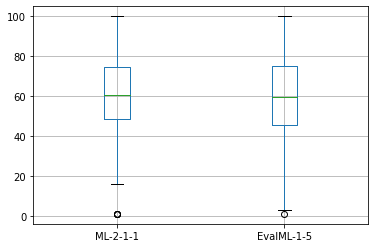

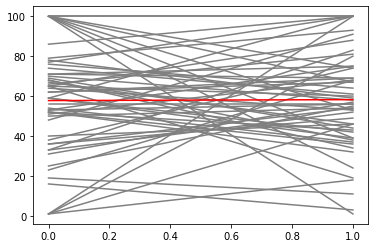

/Users/jean-philipp/Documents/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/core.py:1235: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


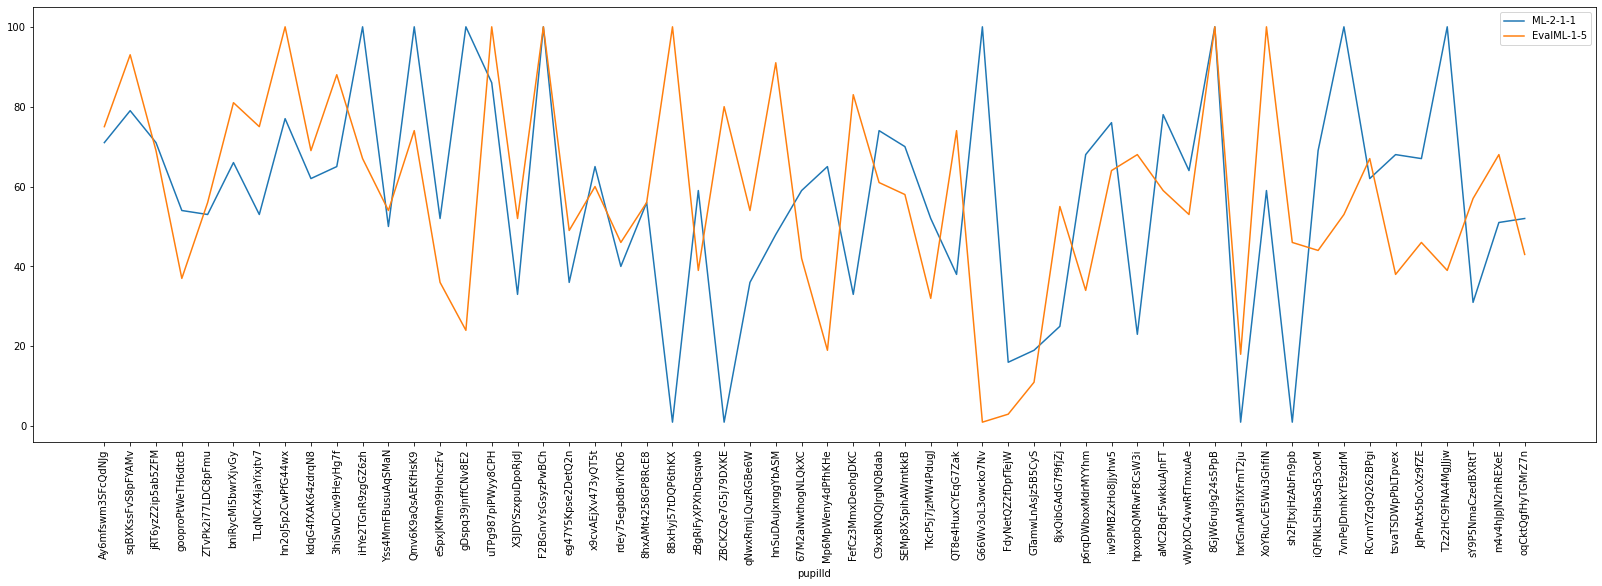

In [50]:
surveySliderStatistics(pupil_performance_df["ML-2-1-1"])
surveySliderStatistics(pupil_performance_df["EvalML-1-5"])

pupil_performance_df.boxplot(column=['ML-2-1-1', 'EvalML-1-5'])
plt.show()

plot_improvements(pupil_performance_df[['ML-2-1-1', 'EvalML-1-5']])

In [56]:
differences_0_1 = calculateDifferences(pupil_performance_df[["EvalML-1-5", "ML-2-1-1"]])

print("ShapirotestResult", stats.shapiro(differences_0_1))
# TODO: hier beide Test verwenden?
print(stats.wilcoxon(differences_0_1))
print(stats.ttest_rel(pupil_performance_df.dropna(subset=["EvalML-1-5", "ML-2-1-1"])["ML-2-1-1"], pupil_performance_df.dropna(subset=["EvalML-1-5", "ML-2-1-1"])["EvalML-1-5"]))

ShapirotestResult ShapiroResult(statistic=0.9749335646629333, pvalue=0.29257649183273315)
WilcoxonResult(statistic=700.5, pvalue=0.89434543821884)
Ttest_relResult(statistic=-0.10173317312577801, pvalue=0.9193384577871859)


* Shapiro: p 0.29 --> p-value is greater than 0.05 --> then the null hypothesis is not rejected --> normalverteilt
* Keine signifikanz, weder nach wilcoxon oder Ttest_rel --> Paket hat keinen Effekt auf die Selbsteinschätzung der SuS

### 3.2 Freitexte - Was ist ML
* 'ML-2-1-1' - Weißt du vielleicht schon etwas über das maschinelle Lernen?
* 'EvalML-1-7' - Was ist ML in eigenen Worten

#### 3.2.1 nach teacher ratings

In [59]:
differences_content = calculateDifferences(pupil_performance_df[["EvalML-1-7_rating_content", "ML-2-1-2_rating_content"]])

print(stats.shapiro(differences_content))
print(stats.wilcoxon(differences_content))

ShapiroResult(statistic=0.9216520190238953, pvalue=0.012465259060263634)
WilcoxonResult(statistic=80.0, pvalue=0.21287092067068514)


* zu hoher p-Wert (0.27) --> keine beweise dafür, dass das Paket einen Effekt auf die content ratings hatten

#### 3.2.2.1 Was ist ML - Freitext - unknown und nullanswers

In [69]:
#Signifikante Veränderung des Anteils, die nichts wissen?

proportionT0unknown = pupil_performance_df_rated[["ML-2-1-2_unknown"]].value_counts()[True].values[0] / (pupil_performance_df_rated[["ML-2-1-2_unknown"]].value_counts()[False].values[0] + pupil_performance_df_rated[["ML-2-1-2_unknown"]].value_counts()[True].values[0])
proportionT1unknown = pupil_performance_df_rated[["EvalML-1-7_unknown"]].value_counts()[True].values[0] / (pupil_performance_df_rated[["EvalML-1-7_unknown"]].value_counts()[False].values[0] + pupil_performance_df_rated[["EvalML-1-7_unknown"]].value_counts()[True].values[0])
proportionT0null = pupil_performance_df_rated[["ML-2-1-2_null_answer"]].value_counts()[True].values[0] / (pupil_performance_df_rated[["ML-2-1-2_null_answer"]].value_counts()[False].values[0] + pupil_performance_df_rated[["ML-2-1-2_null_answer"]].value_counts()[True].values[0])
proportionT1null = pupil_performance_df_rated[["EvalML-1-7_null_answer"]].value_counts()[True].values[0] / (pupil_performance_df_rated[["EvalML-1-7_null_answer"]].value_counts()[False].values[0] + pupil_performance_df_rated[["EvalML-1-7_null_answer"]].value_counts()[True].values[0])

print("-----deskriptiv-----")
print("Proportion Unknown: ", proportionT0unknown, "-->", proportionT1unknown)
print("Proportion Nullanswers: ", proportionT0null, "-->", proportionT1null, "\n")

print("-----Signifikanz-----")
countUn = np.array([pupil_performance_df_rated[["ML-2-1-2_unknown"]].value_counts()[True].values[0], pupil_performance_df_rated[["EvalML-1-7_unknown"]].value_counts()[True].values[0]])
nobsUn = np.array([(pupil_performance_df_rated[["ML-2-1-2_unknown"]].value_counts()[False].values[0] + pupil_performance_df_rated[["ML-2-1-2_unknown"]].value_counts()[True].values[0]), (pupil_performance_df_rated[["EvalML-1-7_unknown"]].value_counts()[False].values[0] + pupil_performance_df_rated[["EvalML-1-7_unknown"]].value_counts()[True].values[0])])
statUn, pvalUn = proportions_ztest(countUn, nobsUn)
print("Unknown --> stat: ", statUn, " pval", pvalUn)

countNu= np.array([pupil_performance_df_rated[["ML-2-1-2_null_answer"]].value_counts()[True].values[0], pupil_performance_df_rated[["EvalML-1-7_null_answer"]].value_counts()[True].values[0]])
nobsNu = np.array([(pupil_performance_df_rated[["ML-2-1-2_null_answer"]].value_counts()[False].values[0] + pupil_performance_df_rated[["ML-2-1-2_null_answer"]].value_counts()[True].values[0]), (pupil_performance_df_rated[["EvalML-1-7_null_answer"]].value_counts()[False].values[0] + pupil_performance_df_rated[["EvalML-1-7_null_answer"]].value_counts()[True].values[0])])
statNu, pvalNu = proportions_ztest(countNu, nobsNu)
print("Nullanswers --> stat: ", statNu, " pval", pvalNu)

-----deskriptiv-----
Proportion Unknown:  0.34523809523809523 --> 0.09722222222222222
Proportion Nullanswers:  0.13095238095238096 --> 0.125 

-----Signifikanz-----
Unknown --> stat:  3.665268492442692  pval 0.0002470792320212062
Nullanswers --> stat:  0.11085989340779011  pval 0.9117274499246601


* two-proportion t-test für anteil unknown: p-value = 0.000247 --> Signifikanz --> Paket hat einen Effekt auf anzahl unknown-answers
* two-proportion t-test für anteil nullanswers: p-value = 0.911 --> keine signifikanz bei nullanswers. Paket hat keinen einfluss auf anzahl an leuten, die leer abgeben oder plagiieren


##### 3.2.2.1 Was ist ML - Freitext - Analyse nach eigenen Kategorien - Richtige Antworten

#### Was ist ML? - Freitexte - deskriptiv

In [61]:
#["ML-2-1-2_correct_points", 'ML-2-1-2_incorrect_points', 'ML-2-1-2_irrelevant_points', "EvalML-1-7_correct_points", "EvalML-1-7_incorrect_points", "EvalML-1-7_irrelevant_points"]
print("-----correct points-----")
surveySliderStatistics(pupil_performance_df_rated["ML-2-1-2_correct_points"])
surveySliderStatistics(pupil_performance_df_rated["EvalML-1-7_correct_points"])

print("\n-----incorrect points-----")
surveySliderStatistics(pupil_performance_df_rated["ML-2-1-2_incorrect_points"])
surveySliderStatistics(pupil_performance_df_rated["EvalML-1-7_incorrect_points"])

print("\n-----irrelevant points-----")
surveySliderStatistics(pupil_performance_df_rated["ML-2-1-2_irrelevant_points"])
surveySliderStatistics(pupil_performance_df_rated["EvalML-1-7_irrelevant_points"])

-----correct points-----
ML-2-1-2_correct_points
Q1: 0.0 and Q3: 1.0
median: 0.0
mean: 0.5476190476190477
std: 0.87
min: 0.0 und max: 3.0

EvalML-1-7_correct_points
Q1: 0.0 and Q3: 1.25
median: 1.0
mean: 0.9861111111111112
std: 1.23
min: 0.0 und max: 6.0


-----incorrect points-----
ML-2-1-2_incorrect_points
Q1: 0.0 and Q3: 0.25
median: 0.0
mean: 0.25
std: 0.44
min: 0.0 und max: 1.0

EvalML-1-7_incorrect_points
Q1: 0.0 and Q3: 0.0
median: 0.0
mean: 0.18055555555555555
std: 0.39
min: 0.0 und max: 1.0


-----irrelevant points-----
ML-2-1-2_irrelevant_points
Q1: 0.0 and Q3: 0.0
median: 0.0
mean: 0.05952380952380952
std: 0.24
min: 0.0 und max: 1.0

EvalML-1-7_irrelevant_points
Q1: 0.0 and Q3: 0.0
median: 0.0
mean: 0.06944444444444445
std: 0.26
min: 0.0 und max: 1.0



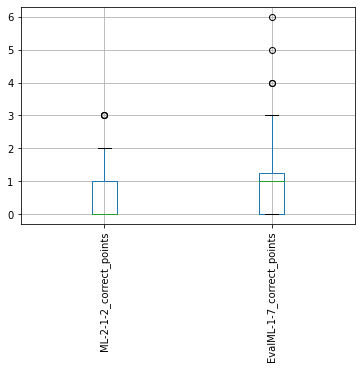

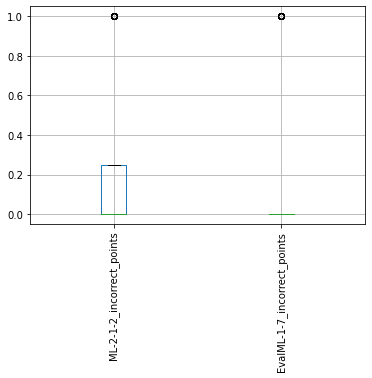

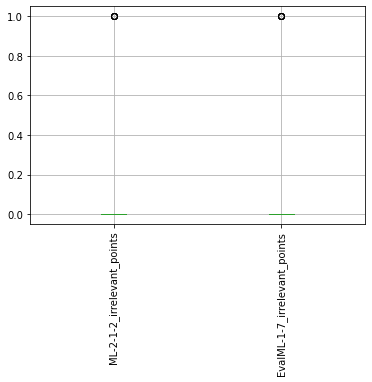

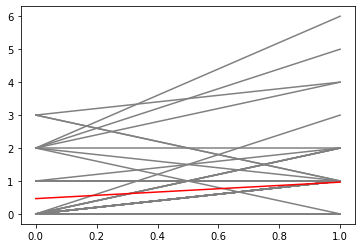

/Users/jean-philipp/Documents/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/core.py:1235: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


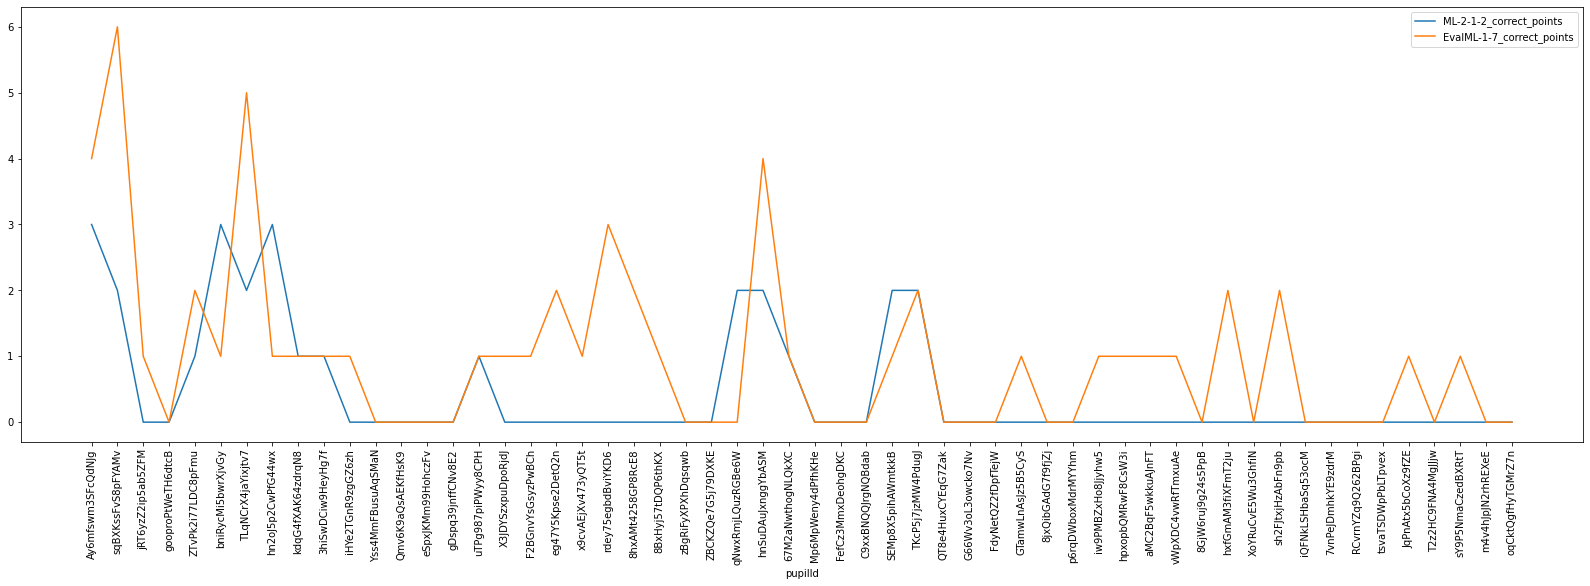

In [63]:
#["ML-2-1-2_correct_points", 'ML-2-1-2_incorrect_points', 'ML-2-1-2_irrelevant_points', "EvalML-1-7_correct_points", "EvalML-1-7_incorrect_points", "EvalML-1-7_irrelevant_points"]
pupil_performance_df_rated.boxplot(column=["ML-2-1-2_correct_points", "EvalML-1-7_correct_points"])
plt.xticks(rotation = 90)
plt.show()

pupil_performance_df_rated.boxplot(column=['ML-2-1-2_incorrect_points', "EvalML-1-7_incorrect_points"])
plt.xticks(rotation = 90)
plt.show()

pupil_performance_df_rated.boxplot(column=['ML-2-1-2_irrelevant_points', "EvalML-1-7_irrelevant_points"])
plt.xticks(rotation = 90)
plt.show()

#pupil_performance_df_rated.boxplot(column=["ML-2-1-2_correct_points", 'ML-2-1-2_incorrect_points', 'ML-2-1-2_irrelevant_points', "EvalML-1-7_correct_points", "EvalML-1-7_incorrect_points", "EvalML-1-7_irrelevant_points"])
#plt.xticks(rotation = 90)
#plt.show()

plot_improvements(pupil_performance_df_rated[["ML-2-1-2_correct_points", "EvalML-1-7_correct_points"]])
#plot_improvements(pupil_performance_df_rated[["AI-1-v2-1-2_incorrect_points", "AI-4-v2-1-3_incorrect_points"]])
#plot_improvements(pupil_performance_df_rated[["AI-1-v2-1-2_irrelevant_points", "AI-4-v2-1-3_irrelevant_points"]])
#zu wenige inkorrekte und irrelevante, damit die grafik gut aussieht

##### Signifikanz

In [78]:
MLdifferences_irrelevant = calculateDifferences(pupil_performance_df_rated[["EvalML-1-7_irrelevant_points", "ML-2-1-2_irrelevant_points"]])
print(len(MLdifferences_irrelevant))

56


In [77]:
MLdifferences_correct = calculateDifferences(pupil_performance_df_rated[["EvalML-1-7_correct_points", "ML-2-1-2_correct_points"]])
MLdifferences_incorrect = calculateDifferences(pupil_performance_df_rated[["EvalML-1-7_incorrect_points", "ML-2-1-2_incorrect_points"]])
MLdifferences_irrelevant = calculateDifferences(pupil_performance_df_rated[["EvalML-1-7_irrelevant_points", "ML-2-1-2_irrelevant_points"]])

print("\n-----Normalverteilung?-----")
print(stats.shapiro(MLdifferences_correct))
print(stats.shapiro(MLdifferences_incorrect))
print(stats.shapiro(MLdifferences_irrelevant))

print("\n-----Signifikanz-----")
print(stats.wilcoxon(MLdifferences_correct))
print(stats.wilcoxon(MLdifferences_incorrect))
print(stats.wilcoxon(MLdifferences_irrelevant))
print("sample size too small for wilcoxon on irrelevant points?")
# 56 differences

print("\n-----Effektstärke-----")
print(cohen_d(pupil_performance_df_rated.dropna(subset=["EvalML-1-7_correct_points", "ML-2-1-2_correct_points"])["EvalML-1-7_correct_points"], pupil_performance_df_rated.dropna(subset=["EvalML-1-7_correct_points", "ML-2-1-2_correct_points"])["ML-2-1-2_correct_points"]))
print(cohen_d(pupil_performance_df_rated.dropna(subset=["EvalML-1-7_incorrect_points", "ML-2-1-2_incorrect_points"])["EvalML-1-7_incorrect_points"], pupil_performance_df_rated.dropna(subset=["EvalML-1-7_incorrect_points", "ML-2-1-2_incorrect_points"])["AI-4-v2-1-3_incorrect_points"]))
print(cohen_d(pupil_performance_df_rated.dropna(subset=["EvalML-1-7_irrelevant_points", "ML-2-1-2_irrelevant_points"])["EvalML-1-7_irrelevant_points"], pupil_performance_df_rated.dropna(subset=["EvalML-1-7_irrelevant_points", "ML-2-1-2_irrelevant_points"])["ML-2-1-2_irrelevant_points"]))


-----Normalverteilung?-----
ShapiroResult(statistic=0.8499417901039124, pvalue=5.7292613746540155e-06)
ShapiroResult(statistic=0.5865061283111572, pvalue=2.6239219130808067e-11)
ShapiroResult(statistic=0.3409348726272583, pvalue=1.946106307788159e-14)

-----Signifikanz-----
WilcoxonResult(statistic=70.0, pvalue=0.003268386795636622)
WilcoxonResult(statistic=27.5, pvalue=1.0)
WilcoxonResult(statistic=2.5, pvalue=0.31731050786291415)
sample size too small for wilcoxon?

-----Effektstärke-----
0.4466339276017599
0.5557427058238101
0.19161320629792308


/Users/jean-philipp/Documents/anaconda3/lib/python3.7/site-packages/scipy/stats/morestats.py:2981: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")


* signifikante verbesserung bei den korrekten aussagen
  * effektstärke 0.31: leichter bis mittlerer effekt
* keine signifikanz bei incorrecten oder irrelevanten

#### Unterschiede zwischen Klassen

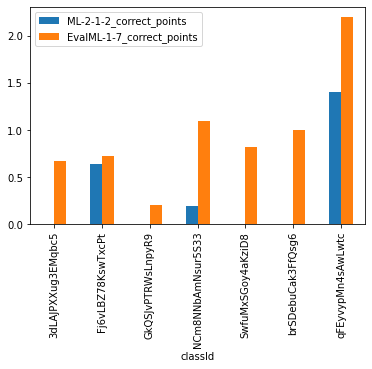

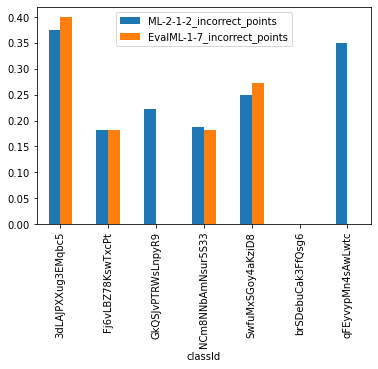

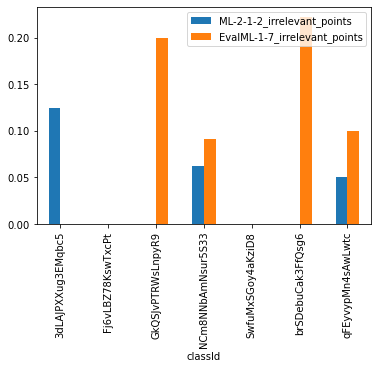

In [37]:
pupil_performance_df_rated.groupby("classId")[["ML-2-1-2_correct_points", "EvalML-1-7_correct_points"]].agg(np.mean).dropna().plot(y=["ML-2-1-2_correct_points", "EvalML-1-7_correct_points"], kind="bar")
plt.show()
pupil_performance_df_rated.groupby("classId")[["ML-2-1-2_incorrect_points", "EvalML-1-7_incorrect_points"]].agg(np.mean).dropna().plot(y=["ML-2-1-2_incorrect_points", "EvalML-1-7_incorrect_points"], kind="bar")
plt.show()
pupil_performance_df_rated.groupby("classId")[["ML-2-1-2_irrelevant_points", "EvalML-1-7_irrelevant_points"]].agg(np.mean).dropna().plot(y=["ML-2-1-2_irrelevant_points", "EvalML-1-7_irrelevant_points"], kind="bar")
plt.show()
# manche Klassen haben wert null --> sieht man im barplot nicht gut

* manche Klassen haben wert null --> sieht man im barplot nicht gut
* eine klasse (qFEyvyMn4sAwLwtc) scheint schon relativ viel vorwissen zu haben. Trotzdem hat sie klar lernzuwachs

### 3.3 - Was ist ML - MC

In [53]:
analyse_mc(['EvalML-1-8'], 8)

EvalML-1-8
Welche der Aussagen über maschinelles Lernen stimmen?
*Algorithmen des maschinellen Lernens können aus vorhandenen Daten selbständig lernen - True
*Beim überwachten Lernen nutzen wir Daten ohne Label - False
*Beim unüberwachten Lernen versuchen wir, Strukturen in den Daten zu entdecken - True
*Clustering ist ein Beispiel für unüberwachtes Lernen - True
*Wenn wir für Daten Label vorhersagen wollen, betreiben wir Clustering - False
*Wenn wir für Daten Label vorhersagen wollen, betreiben wir überwachtes Lernen - True
*Algorithmen des maschinellen Lernens lernen nur, was in den Daten vorhanden ist. Daher ist die Auswahl an Trainingsdaten sehr wichtig - True
*Algorithmen des maschinellen Lernens benötigen oft große Mengen an Daten, damit sie gute Ergebnisse erzielen - True
[True, False, True, True, False, True, True, True]

[0, 0, 3, 3, 1, 0, 0, 2, 2, 2, 6, 6, 4, 6, 0, 3, 3, 0, 1, 0, 2, 0, 0, 4, 4, 3, 3, 0, 2, 0, 0, 3, 4, 2, 6, 5, 3, 6, 4, 0, 3, 3, 3, 3, 2, 3, 0, 4, 0, 3, 6, 7, 0

In [54]:
number_errors_sus = [0, 0, 3, 3, 1, 0, 0, 2, 2, 2, 6, 6, 4, 6, 0, 3, 3, 0, 1, 0, 2, 0, 0, 4, 4, 3, 3, 0, 2, 0, 0, 3, 4, 2, 6, 5, 3, 6, 4, 0, 3, 3, 3, 3, 2, 3, 0, 4, 0, 3, 6, 7, 0, 6, 6, 5, 0, 5, 6, 4, 7, 4, 2, 1, 4, 2, 2, 4, 2, 3, 2, 6]
number_questions = 8

cohen_d(random_mcs(len(number_errors_sus), number_questions), number_errors_sus)

0.341791152683887

Result:
* 2.79 weit unter bei chance 4 --> kein chance
* 0.00038 p-value --> signifikanz
* effektstärke 0.34 --> leichter bis mittlerer effekt

## 4. unterschied überwachtes und unüberwachtes?
### 4.1 überwacht vs unüberwacht - Selbsteinschätzung
<b>Es gibt keinen T0, nur einen T1!</b>
* 'EvalML-1-6' Wie sehr hast du das Gefühl, verstanden zu haben, was der Unterschied zwischen überwachtem und unüberwachtem Lernen ist?

EvalML-1-6
Q1: 43.75 and Q3: 76.5
median: 54.5
mean: 58.736111111111114
std: 25.67
min: 1.0 und max: 100.0



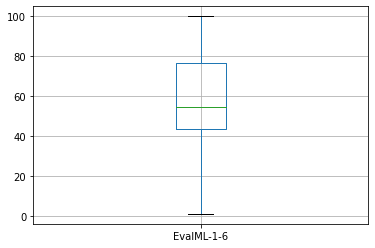

In [56]:
surveySliderStatistics(pupil_performance_df["EvalML-1-6"])

pupil_performance_df.boxplot(column=["EvalML-1-6"])
plt.show()

### 4.2 überwacht vs unüberwacht - MC Definitionen
* MC: 'Classification-1-1-1', 'Was war unüberwachtes Lernen noch gleich?'
* MC: "Clustering-1-1-1" 'Was war unüberwachtes Lernen noch gleich?'

In [57]:
analyse_mc(['Classification-1-1-1', "Clustering-1-1-1"], 5)

Classification-1-1-1
Welche Aussagen stimmen?
*Beim überwachten Lernen braucht man Daten ohne Label - False
*Einen Algorithmus zu trainieren, der Bildern mit Hunden das Label “Hund” gibt, wäre ein Fall für überwachtes Lernen - True
*Beim überwachten Lernen versucht man Struktur in Daten zu finden - False
[False, True, False]

Clustering-1-1-1
Was war unüberwachtes Lernen noch gleich?
*Beim unüberwachten Lernen nutzt man Daten mit Label - False
*Beim unüberwachten Lernen wollen wir die richtigen Label für neue Daten vorhersagen - False
*Beim unüberwachten Lernen hat man keine Label für die Daten - True
*Beim unüberwachten Lernen geht es darum, Struktur in den Daten zu finden - True
[False, False, True, True]

[0, 0, 1, 3, 1, 0, 0, 1, 0, 0, 0, 3, 3, 0, 1, 1, 4, 2, 4, 2, 0, 1, 1, 4, 3, 2, 2, 2, 4, 5, 2, 4, 3, 4, 4, 4, 6, 0, 2, 0, 3, 1, 4, 5, 3, 2, 2, 1, 5, 0, 4, 3, 3, 3, 1, 0, 4, 1, 3, 2, 6, 3, 1, 0, 4, 3, 0, 2, 5, 3, 3, 4, 2, 3, 2, 3, 3, 3, 6, 2, 3, 1, 3, 2, 1, 3, 2, 3, 2, 4, 2, 5, 1]
nu

In [58]:
number_errors_sus = [0, 0, 1, 3, 1, 0, 0, 1, 0, 0, 0, 3, 3, 0, 1, 1, 4, 2, 4, 2, 0, 1, 1, 4, 3, 2, 2, 2, 4, 5, 2, 4, 3, 4, 4, 4, 6, 0, 2, 0, 3, 1, 4, 5, 3, 2, 2, 1, 5, 0, 4, 3, 3, 3, 1, 0, 4, 1, 3, 2, 6, 3, 1, 0, 4, 3, 0, 2, 5, 3, 3, 4, 2, 3, 2, 3, 3, 3, 6, 2, 3, 1, 3, 2, 1, 3, 2, 3, 2, 4, 2, 5, 1]
number_questions = 5

cohen_d(random_mcs(len(number_errors_sus), number_questions), number_errors_sus)

0.18331636038200916

* im durchschnitt 2.35 Fehler in den 7 Antworten. Da bei Clustering-1-1-1 jeweils zwei der Antworten sich gegenseitig ausschließen, gibt es quasi 5 richtige antworten. Dabei wären 2.5 fehler zu erwarten wären. 3.5 bei komplettem raten --> kaum besser als gut lesend raten
* p-value 0.24 --> keine signifikanz
* (efektstärke 0.18 --> kaum effekt)

### 4.3 überwacht vs unüberwacht - MC transfer

In [59]:
print_mc(['ML-3-1-2', 'ML-3-1-3', 'ML-3-1-4'])
mc_analysis(['ML-3-1-2', 'ML-3-1-3', 'ML-3-1-4'])

# hier hab ich das händisch mann whitney berechnet!
nr_errors = [i/2 for i in [2, 2, 2, 2, 4, 4, 2, 4, 2, 4, 2, 2, 4, 2, 2, 4, 6, 5, 4, 2, 6, 2, 4, 4, 2, 2, 6, 4]]

p_array = []
for i in range(100):
    p_array.append(stats.mannwhitneyu(nr_errors, random_mcs(len(nr_errors), 3))[1])

average_p_value = np.mean(p_array)
print(average_p_value)

ML-3-1-2
Ein Empfehlungssystem für Musik, das lernt, was du für Musik magst und dann für neu erscheinende Musik voraussagt, ob du sie mögen würdest.
*Überwachtes Lernen - True
*Unüberwachtes Lernen - False
[True, False]

ML-3-1-3
Die Gesichtserkennung von deinem Handy. Anfangs musst du dein Gesicht aus verschiedenen Winkeln filmen. Anhand dieser Beispiele lernt es, dein Gesicht zu erkennen. Wenn dann irgendein Gesicht versucht, dein Handy zu entsperren, kann es voraussagen, ob es dein Gesicht ist oder nicht.
*Überwachtes Lernen - True
*Unüberwachtes Lernen - False
[True, False]

ML-3-1-4
Wenn wir Youtuber nach der Anzahl ihrer Follower und der Themen ihrer Videos gruppieren.
*Überwachtes Lernen - False
*Unüberwachtes Lernen - True
[False, True]

[2, 2, 4, 6, 4, 5, 2, 2, 4, 2, 4, 4, 2, 4, 2, 2, 2, 2, 4, 2, 2, 4, 2, 2, 6, 4, 6, 4, 2, 2, 0, 0, 2, 4, 2, 2, 2, 0, 4, 2, 2, 0, 0, 0, 0, 6, 0, 2, 2, 2, 6, 4, 4, 0, 0, 2, 4, 2, 2, 2, 0, 2, 2, 0, 4, 2, 0, 4, 2, 2, 2, 6, 4, 4, 4, 0, 2, 4, 0, 2, 3, 

In [60]:
number_errors_sus = [i/2 for i in [2, 2, 4, 6, 4, 5, 2, 2, 4, 2, 4, 4, 2, 4, 2, 2, 2, 2, 4, 2, 2, 4, 2, 2, 6, 4, 6, 4, 2, 2, 0, 0, 2, 4, 2, 2, 2, 0, 4, 2, 2, 0, 0, 0, 0, 6, 0, 2, 2, 2, 6, 4, 4, 0, 0, 2, 4, 2, 2, 2, 0, 2, 2, 0, 4, 2, 0, 4, 2, 2, 2, 6, 4, 4, 4, 0, 2, 4, 0, 2, 3, 2, 4]]
number_questions = 3

cohen_d(random_mcs(len(number_errors_sus), number_questions), number_errors_sus)

0.2921993851018556

* da die antworten sich gegenseitig ausschließen, gab es quasi nur 3 mögliche Antworten. Schnitt von 2.5/2 --> 1.25. Kaum besser als raten
* p-value: 0.28 --> keine signifikanz
* vllt waren die ersten texte nicht gut genug? oder es war zu viel transfer dafür, dass sie die beiden paradigmen gerade erst theoretisch kennen gelernt haben. möglich wäre auch, etwas praxis einzubauen
* (effekt 0.28 --> geringer effekt)

In [61]:
analyse_mc(['Classification-2-1-8'], 3)

Classification-2-1-8
Welche Aussagen stimmen?
*Ein Algorithmus, der dir basierend auf deinen Lieblingsfächern einen Beruf vorschlägt, könnte man mittels überwachtem Lernen umsetzen - True
*Ein Algorithmus, der ähnliche Berufe gruppiert, gehört zum überwachten Lernen - False
*Ein Algorithmus, der anhand vieler alter Fälle gelernt hat, medizinische Diagnosen zu stellen, gehört zum überwachten Lernen - True
[True, False, True]

[0, 1, 0, 2, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 3, 3, 1, 2, 3, 0, 2, 3, 0, 2, 1, 0, 0, 0, 3, 3, 2, 2, 1, 0, 2, 0, 2, 3, 2, 2, 0, 1, 2, 1, 1, 2, 2, 1, 2, 0, 0, 2, 2, 3, 0, 3, 3, 3, 2, 3, 0, 0, 1, 0, 1, 0, 3, 1, 1, 1, 1, 2, 1, 1, 1, 1, 2, 1, 1, 3, 1, 1, 1, 0, 3, 1, 1, 0]
number errors per student value counts
0    29
1    27
2    19
3    15
dtype: int64
mean number of errors: 1.2222222222222223
MannwhitneyuResult(statistic=3272.0, pvalue=0.009707529606443527)

Average p-value over 100 tries: 0.03577352756608093


In [62]:
number_errors_sus = [0, 1, 0, 2, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 3, 3, 1, 2, 3, 0, 2, 3, 0, 2, 1, 0, 0, 0, 3, 3, 2, 2, 1, 0, 2, 0, 2, 3, 2, 2, 0, 1, 2, 1, 1, 2, 2, 1, 2, 0, 0, 2, 2, 3, 0, 3, 3, 3, 2, 3, 0, 0, 1, 0, 1, 0, 3, 1, 1, 1, 1, 2, 1, 1, 1, 1, 2, 1, 1, 3, 1, 1, 1, 0, 3, 1, 1, 0]
number_questions = 3

cohen_d(random_mcs(len(number_errors_sus), number_questions), number_errors_sus)

0.30049538063240305

* 1.2 mean errors gegen 1.5 bei den 3 antwortmöglichkeiten
* p-value: 0.0357 --> signifikanz
* 0.3 --> leichter bis mittlerer

In [63]:
analyse_mc(["EvalML-1-9"], 2)

EvalML-1-9
Welche Art des Lernens sind folgende Aufgaben?
*Eine Webseite, die für neue Rezepte vorhersagt, ob sie dir “gefallen” oder “nicht gefallen”, ist eine Aufgabe für das überwachte Lernen - True
*Eine Webseite, die ähnliche Rezepte gruppiert, wäre eine Aufgabe für das Clustering - True
[True, True]

[0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 2, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 2, 0, 2, 0, 1, 1, 1, 1, 2, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1]
number errors per student value counts
1    39
0    29
2     4
dtype: int64
mean number of errors: 0.6527777777777778
MannwhitneyuResult(statistic=2130.0, pvalue=0.021189810830690707)

Average p-value over 100 tries: 0.009254177439774726


In [64]:
number_errors_sus = [0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 2, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 2, 0, 2, 0, 1, 1, 1, 1, 2, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1]
number_questions = 2

cohen_d(random_mcs(len(number_errors_sus), number_questions), number_errors_sus)

0.3873992329771809

* bei der Eval-1-9 gab es zwei mögliche Richtige. erwartet wären 1 error, mean errors: 0.65 --> besser als raten
* p-value: um 0.009 --> signifikanz
* effekt 0.387 --> leichter bis mittlerer effekt

## 5. Grenzen ML / Traininsdaten
### 5.1 Grenzen ML / Traininsdaten - Freitext

In [89]:
for index, row in pd.DataFrame(pupil_performance_df_rated["LimitsML-1-2"].dropna()).iterrows():
    print(row)

LimitsML-1-2    Auf einmal würde der Algorithmus anfangen alle...
Name: Ay6mfswm3SFcQdNJg, dtype: object
LimitsML-1-2    Dann würde der Algorithmus nur Seehund als Hun...
Name: sqBXKssFvS8pFYAMv, dtype: object
LimitsML-1-2    dann würden Hunde kaum noch als Hund vom Progr...
Name: jRT6yzZ2ip5ab5ZFM, dtype: object
LimitsML-1-2    <span style="color: rgb(51, 51, 51);">⠀</span>
Name: gooproPtWeTH6dtcB, dtype: object
LimitsML-1-2    dann würde der computer bei seehunden sagen da...
Name: ZTvPk2i77LDC8pFmu, dtype: object
LimitsML-1-2    Dann würde der Algorithmus denken, dass Hunde ...
Name: bniRycMi5bwrXjvGy, dtype: object
LimitsML-1-2    Dann erkennt der Algorithmus Seehunde als Hunde.
Name: TLqNCrX4jaYixjtv7, dtype: object
LimitsML-1-2    Dann würde das Algorithmus nur Seehunde als Hu...
Name: hn2oJ5p2CwPfG44wx, dtype: object
LimitsML-1-2    Dann denke ich würden die Seehunde nicht als H...
Name: kdqG4fXAK64zdrqN8, dtype: object
LimitsML-1-2    Da Hunde und Seehunde nur wenige Körperlich

In [116]:
# betrachten: LimitsML-1-2_correct_points (1 wenn richtig, sonst 0)
# LimitsML-1-2_null_answer (damit nur richtige abgaben gezählt werden)

print(pupil_performance_df_rated["LimitsML-1-2_correct_points"].dropna().value_counts())
print(pupil_performance_df_rated.where(pupil_performance_df_rated["LimitsML-1-2_null_answer"] != True)["LimitsML-1-2_correct_points"].dropna().value_counts())

number_correct_cases = pupil_performance_df_rated.where(pupil_performance_df_rated["LimitsML-1-2_null_answer"] != True)["LimitsML-1-2_correct_points"].dropna().value_counts().values[0]
number_incorrect_cases = pupil_performance_df_rated.where(pupil_performance_df_rated["LimitsML-1-2_null_answer"] != True)["LimitsML-1-2_correct_points"].dropna().value_counts().values[1]
percentage_correct = number_correct_cases / (number_correct_cases + number_incorrect_cases)

print("\nPercentage of correct cases: ", percentage_correct)

1.0    40
0.0    36
Name: LimitsML-1-2_correct_points, dtype: int64
1.0    40
0.0    29
Name: LimitsML-1-2_correct_points, dtype: int64

Percentage of correct cases:  0.5797101449275363


classId
3dLAJPXXug3EMqbc5    0.062500
Fj6vLBZ78KswTxcPt    0.363636
GkQSJvPTRWsLnpyR9    0.800000
NCm8NNbAmNsur5S33    0.750000
SwfuMxSGoy4aKziD8    0.363636
brSDebuCak3FfQsg6    0.900000
qFEyvypMn4sAwLwtc    0.818182
Name: LimitsML-1-2_correct_points, dtype: float64


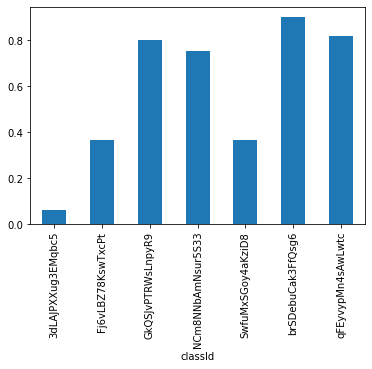

classId
3dLAJPXXug3EMqbc5    0.066667
Fj6vLBZ78KswTxcPt    0.571429
GkQSJvPTRWsLnpyR9    0.800000
NCm8NNbAmNsur5S33    0.750000
SwfuMxSGoy4aKziD8    0.363636
brSDebuCak3FfQsg6    1.000000
qFEyvypMn4sAwLwtc    0.900000
Name: LimitsML-1-2_correct_points, dtype: float64


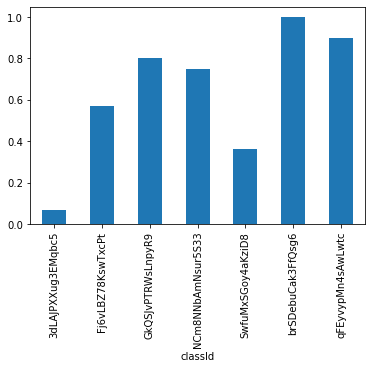

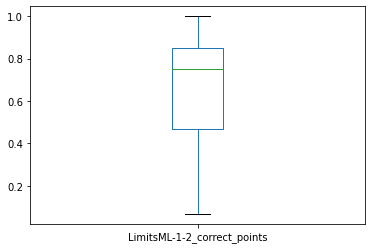

In [119]:
print(pupil_performance_df_rated.groupby("classId")["LimitsML-1-2_correct_points"].agg(np.mean).dropna())
pupil_performance_df_rated.groupby("classId")["LimitsML-1-2_correct_points"].agg(np.mean).dropna().plot(kind="bar")
plt.show()
# das ist mit nullanswers. man könnte argumentieren, dass das ja auch falsche antworten sind

print(pupil_performance_df_rated.where(pupil_performance_df_rated["LimitsML-1-2_null_answer"] != True).groupby("classId")["LimitsML-1-2_correct_points"].agg(np.mean).dropna())
pupil_performance_df_rated.where(pupil_performance_df_rated["LimitsML-1-2_null_answer"] != True).groupby("classId")["LimitsML-1-2_correct_points"].agg(np.mean).dropna().plot(kind="bar")
plt.show()
# das ist ohne nullanswers, man könnte argumentieren, dass man keine aussgae über den lernzuwachs treffen kann

pupil_performance_df_rated.where(pupil_performance_df_rated["LimitsML-1-2_null_answer"] != True).groupby("classId")["LimitsML-1-2_correct_points"].agg(np.mean).dropna().plot(kind="box")
plt.show()

results:
* ...

### 5.2 Grenzen ML / Traininsdaten - MCs
* (Trainingsdaten)
    * MC: 'LimitsML-1-1' ('Was könnte passieren, wenn wir bei den Hundebildern nur Bilder von einer Hunderasse nutzen würden?')
    * MC: Impact-1-1-1?'Was glaubst du, warum das Gesicht der dunkelhäutigen Frau nicht erkannt wurde?')

In [71]:
analyse_mc(['LimitsML-1-1'], 2)

LimitsML-1-1
Was könnte passieren, wenn wir bei den Hundebildern nur Bilder von einer Hunderasse nutzen würden?
*Der Algorithmus würde nur Hunde dieser Rasse zuverlässig als Hunde erkennen - True
*Bei Hunden anderer Rassen ist es schwer zu sagen, ob er sie erkennen würde, aber sehr wahrscheinlich nicht so zuverlässig - True
*Der Algorithmus würde immer noch alle Hunderassen als Hunde erkennen, weil es keine Katzen sind - False
[True, True, False]

[0, 0, 0, 2, 1, 0, 0, 0, 0, 0, 0, 2, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 2, 1, 0, 0, 0, 1, 0, 1, 1, 2, 1, 0, 2, 0, 0, 1, 2, 1, 0, 2, 0, 1, 0, 1, 2, 0, 1, 0, 2, 1, 1, 2, 3, 1, 1, 1, 0, 1, 3, 0, 0, 0, 1, 1, 0, 0]
number errors per student value counts
0    37
1    27
2    10
3     2
dtype: int64
mean number of errors: 0.6973684210526315
MannwhitneyuResult(statistic=2181.0, pvalue=0.002507352945477617)

Average p-value over 100 tries: 0.007504493974372556


In [72]:
number_errors_sus = [0, 0, 0, 2, 1, 0, 0, 0, 0, 0, 0, 2, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 2, 1, 0, 0, 0, 1, 0, 1, 1, 2, 1, 0, 2, 0, 0, 1, 2, 1, 0, 2, 0, 1, 0, 1, 2, 0, 1, 0, 2, 1, 1, 2, 3, 1, 1, 1, 0, 1, 3, 0, 0, 0, 1, 1, 0, 0]
number_questions = 2

cohen_d(random_mcs(len(number_errors_sus), number_questions), number_errors_sus)

0.29855734834483033

* 0.697 deutlich weniger als 1.5 --> scheint lernzuwachs zu geben!
* wie zähle ich? eine antworte schließt zwei andere aus!
  * als 2 fragen:
    * p: 0.007 --> signifikant
    * effekt: 0.298
  * als 3 fragen: 
    * signifikanz 7.746763952825816e-07
    * effektstärke 0.63 --> mittlerer effekt

In [73]:
analyse_mc(['Impact-1-1-1'], 2)

Impact-1-1-1
Was glaubst du, warum das Gesicht der dunkelhäutigen Frau nicht erkannt wurde?
*Der Algorithmus wurde falsch programmiert - False
*Die Trainingsdaten, mit denen der Algorithmus gelernt hat, enthielten keine oder kaum Bilder von dunkelhäutigen Menschen - True
[False, True]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 1, 0, 0, 1, 0, 2, 0, 0, 0, 2, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
number errors per student value counts
0    97
2    11
1     2
dtype: int64
mean number of errors: 0.21818181818181817
MannwhitneyuResult(statistic=2567.0, pvalue=5.52496411359987e-17)

Average p-value over 100 tries: 1.4053797727755543e-15


In [74]:
number_errors_sus = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 1, 0, 0, 1, 0, 2, 0, 0, 0, 2, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
number_questions = 2

cohen_d(random_mcs(len(number_errors_sus), number_questions), number_errors_sus)

0.8123990076462775

* 0.21 unter 0.5 --> scheinen gelernt zu haben
* deutlich signifikanz: 1.4053797727755543e-15
* aber war auch komisch gefrased, die andere wäre spannender!
* effekt: 0.81  --> starker effekt

## Feedback zum Paket
### Feedback zum Paket - Selbsteinschätzung
* ('AIClosing-1-7', 'Hattest du Spaß?')
* ('AIClosing-1-8', 'Hast du etwas gelernt?')

AIClosing-1-6
Q1: 58.25 and Q3: 100.0
median: 75.0
mean: 73.82291666666667
std: 24.61
min: 1.0 und max: 100.0

-----Hattest du Spaß?-----


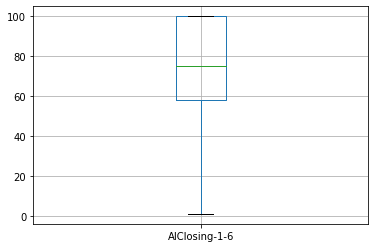

AIClosing-1-7
Q1: 62.75 and Q3: 98.25
median: 75.5
mean: 74.625
std: 24.37
min: 1.0 und max: 100.0

-----Hast du etwas gelernt?-----


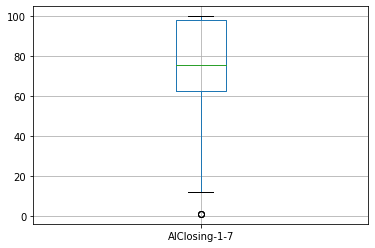

In [78]:
for taskId in ["AIClosing-1-6", "AIClosing-1-7"]:
    surveySliderStatistics(pupil_performance_df[taskId])
    if(taskId == "AIClosing-1-6"):
        print("-----Hattest du Spaß?-----")
    else:
        print("-----Hast du etwas gelernt?-----")
    pupil_performance_df.boxplot(column=[taskId])
    plt.show()

# Itemanalyse

## Surveyslider
### Durations

<AxesSubplot:>

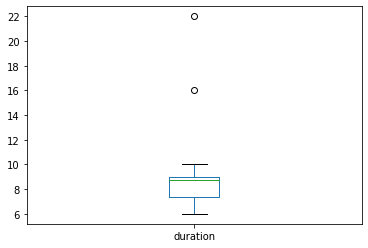

In [109]:
surveysliders.groupby("taskId").agg(np.median)[["duration"]].plot(kind="box")

<AxesSubplot:ylabel='taskId'>

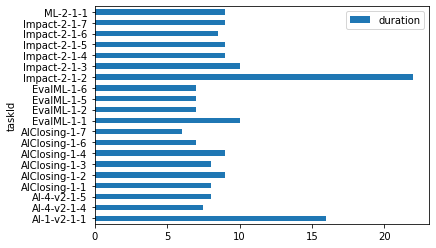

In [8]:
surveysliders.groupby("taskId").agg(np.median)[["duration"]].plot(kind="barh")

### Surveyslider Antworten

TASK   AI-1-v2-1-1: Wie gut weißt du schon, was KI ist?
Von Gar nicht bis Sehr gut
min: 1
max: 100
median: 65.5
mean: 62.11267605633803
std: 27.477032301657474


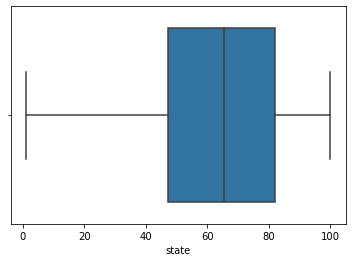

Durations:


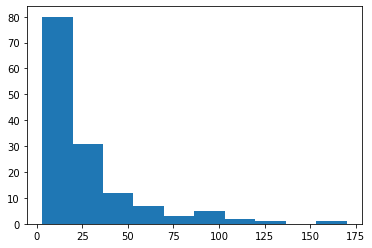

median duration: 16.0
mean duration: 26.47887323943662
-------------------------------------------------------------


TASK   AI-4-v2-1-4: Wie gut hast du jetzt verstanden, was KI ist?
Von Gar nicht bis Sehr gut
min: 1
max: 100
median: 68.0
mean: 68.91071428571429
std: 25.17777987610893


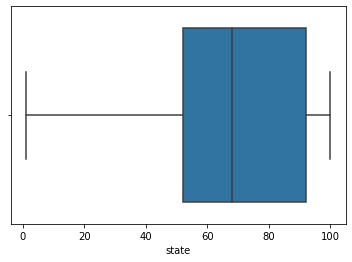

Durations:


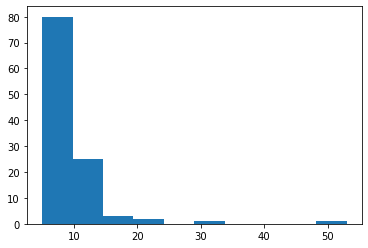

median duration: 7.5
mean duration: 9.044642857142858
-------------------------------------------------------------


TASK   AI-4-v2-1-5: Wie gut hast du den Unterschied zwischen spezifischer und allgemeiner KI verstanden?
Von Gar nicht bis Sehr gut
min: 1
max: 100
median: 61.0
mean: 61.410714285714285
std: 29.875800518691598


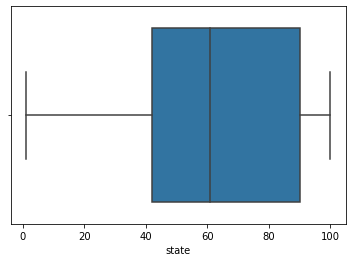

Durations:


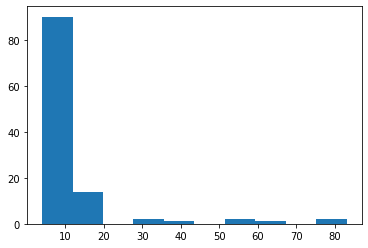

median duration: 8.0
mean duration: 11.526785714285714
-------------------------------------------------------------


TASK   ML-2-1-1: Wie gut weißt du schon, was Maschinelles Lernen ist?
Von Gar nicht bis Sehr gut
min: 1
max: 100
median: 62.0
mean: 60.34117647058824
std: 24.981194311004273


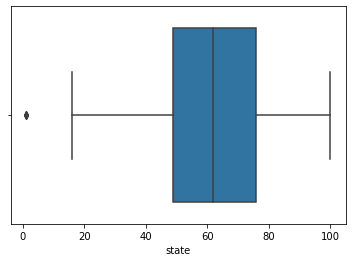

Durations:


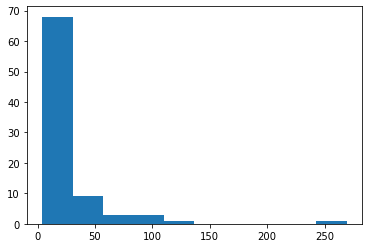

median duration: 9.0
mean duration: 22.729411764705883
-------------------------------------------------------------


TASK   EvalML-1-1: Wie gut hast du verstanden, was KI ist? Sei dabei so ehrlich es geht damit wir diese Inhalte noch verbessern können.
Von Gar nicht bis Sehr gut
min: 1
max: 100
median: 65.0
mean: 63.397260273972606
std: 25.204772175901663


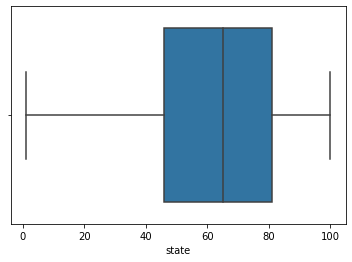

Durations:


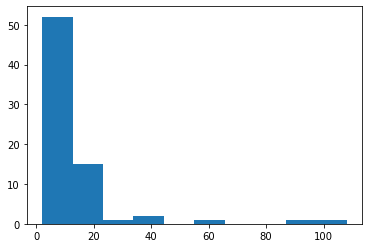

median duration: 10.0
mean duration: 14.246575342465754
-------------------------------------------------------------


TASK   EvalML-1-2: Wie gut hast du den Unterschied zwischen spezifischer und allgemeiner KI verstanden?
Von Gar nicht bis Sehr gut
min: 1
max: 100
median: 59.0
mean: 61.534246575342465
std: 27.624231070575892


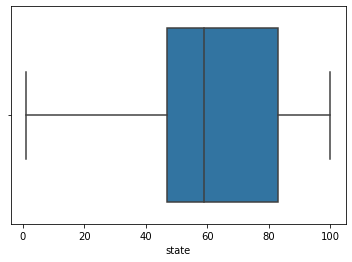

Durations:


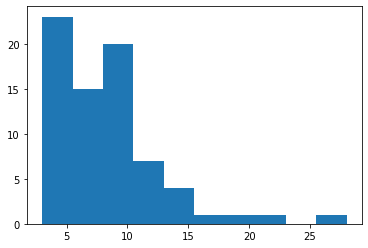

median duration: 7.0
mean duration: 8.178082191780822
-------------------------------------------------------------


TASK   EvalML-1-5: Wie gut hast du verstanden, was maschinelles Lernen ist? Sei dabei so ehrlich es geht, damit wir diese Inhalte noch verbessern können.
Von Gar nicht bis Sehr gut
min: 1
max: 100
median: 60.0
mean: 61.21917808219178
std: 24.77307783917495


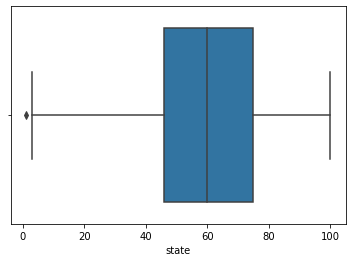

Durations:


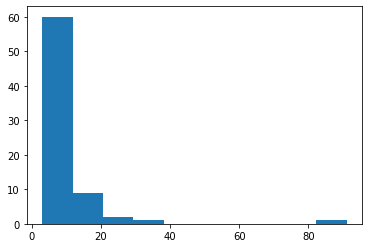

median duration: 7.0
mean duration: 9.493150684931507
-------------------------------------------------------------


TASK   EvalML-1-6: Wie sehr hast du das Gefühl, verstanden zu haben, was der Unterschied zwischen überwachtem und unüberwachtem Lernen ist?
Von Gar nicht bis Sehr gut
min: 1
max: 100
median: 55.0
mean: 59.3013698630137
std: 25.763776701102987


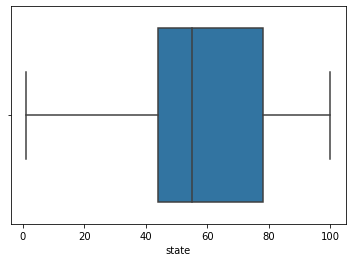

Durations:


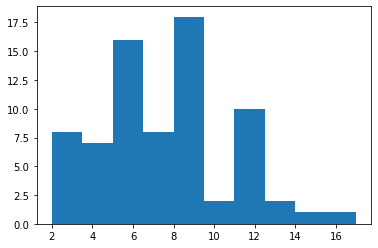

median duration: 7.0
mean duration: 7.36986301369863
-------------------------------------------------------------


TASK   Impact-2-1-2: Ich würde gerne in einem Land leben, dass den Alltag aller Bürger mit KI überwacht.
Von Stimme nicht zu bis Stimme stark zu
min: 1
max: 100
median: 23.5
mean: 29.74137931034483
std: 28.50563183606645


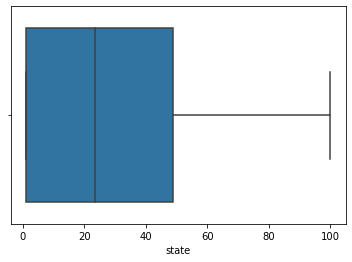

Durations:


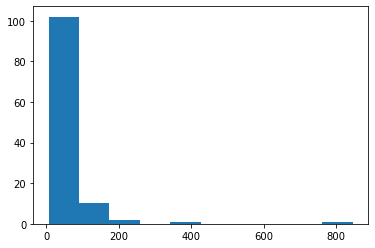

median duration: 22.0
mean duration: 48.11206896551724
-------------------------------------------------------------


TASK   Impact-2-1-3: Die Überwachung des Alltags aller Bürger sehe ich sehr kritisch.
Von Stimme nicht zu bis Stimme stark zu
min: 6
max: 100
median: 75.0
mean: 71.91379310344827
std: 24.325936550534742


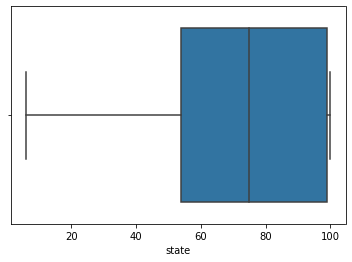

Durations:


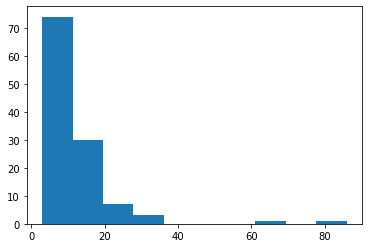

median duration: 10.0
mean duration: 12.439655172413794
-------------------------------------------------------------


TASK   Impact-2-1-4: Mich würde es stören, mittels KI-Technologien überwacht zu werden.
Von Stimme nicht zu bis Stimme stark zu
min: 1
max: 100
median: 79.0
mean: 73.38793103448276
std: 26.3231809312642


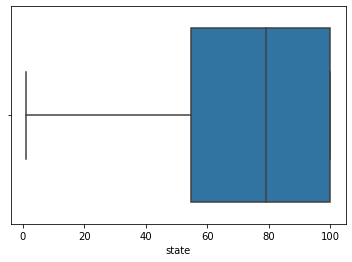

Durations:


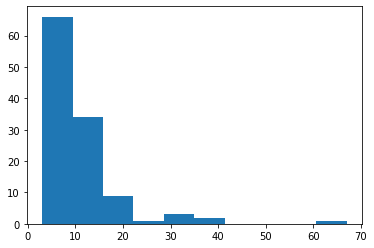

median duration: 9.0
mean duration: 11.094827586206897
-------------------------------------------------------------


TASK   Impact-2-1-5: Die Überwachung durch die Regierung bietet viele Vorteile für die Gesellschaft.
Von Stimme nicht zu bis Stimme stark zu
min: 1
max: 100
median: 47.0
mean: 43.98275862068966
std: 25.517736481683336


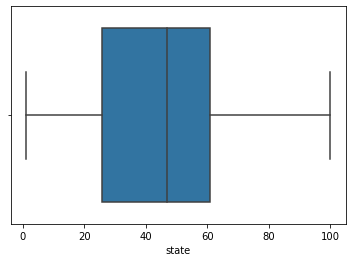

Durations:


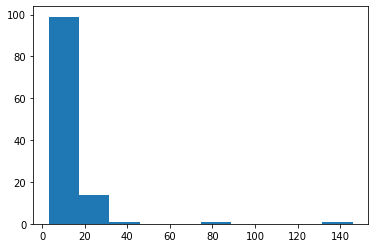

median duration: 9.0
mean duration: 12.517241379310345
-------------------------------------------------------------


TASK   Impact-2-1-6: Ich würde nicht in einem Land leben wollen, dass meinen Alltag überwacht.
Von Stimme nicht zu bis Stimme stark zu
min: 1
max: 100
median: 84.0
mean: 75.37931034482759
std: 27.176515969013227


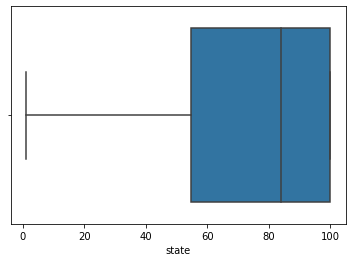

Durations:


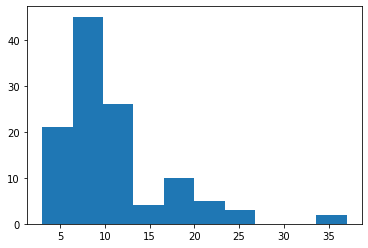

median duration: 8.5
mean duration: 10.53448275862069
-------------------------------------------------------------


TASK   Impact-2-1-7: In einem Land mit Überwachung würde ich mich sehr sicher fühlen.
Von Stimme nicht zu bis Stimme stark zu
min: 1
max: 100
median: 47.5
mean: 43.53448275862069
std: 25.919447842432895


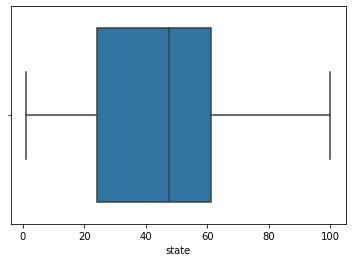

Durations:


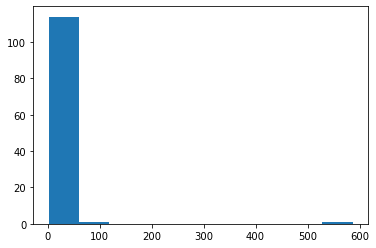

median duration: 9.0
mean duration: 15.379310344827585
-------------------------------------------------------------


TASK   AIClosing-1-1: KI wird das Leben der Menschen verbessern.
Von Stimme nicht zu bis Stimme stark zu
min: 1
max: 100
median: 63.0
mean: 63.02061855670103
std: 23.363986464961695


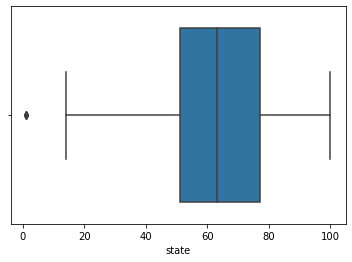

Durations:


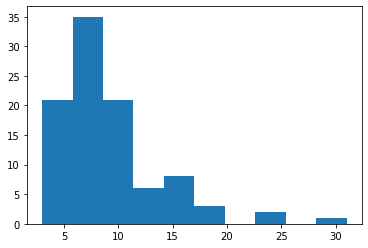

median duration: 8.0
mean duration: 8.948453608247423
-------------------------------------------------------------


TASK   AIClosing-1-2: Bei der Entwicklung von KI gibt es Risiken, die bedacht werden müssen
Von Stimme nicht zu bis Stimme stark zu
min: 19
max: 100
median: 74.0
mean: 76.63917525773196
std: 20.462782694649817


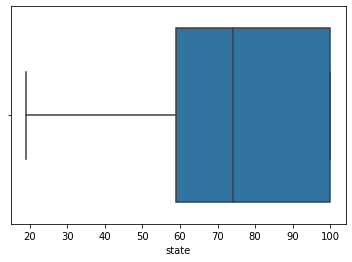

Durations:


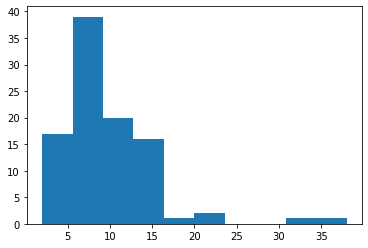

median duration: 9.0
mean duration: 9.443298969072165
-------------------------------------------------------------


TASK   AIClosing-1-3: KI birgt eine Gefahr für die Menschheit.
Von Stimme nicht zu bis Stimme stark zu
min: 1
max: 100
median: 48.0
mean: 50.865979381443296
std: 23.01439659962728


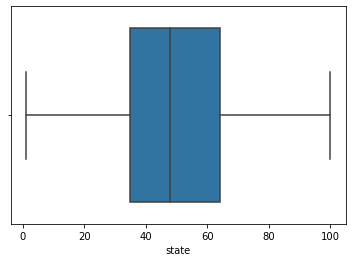

Durations:


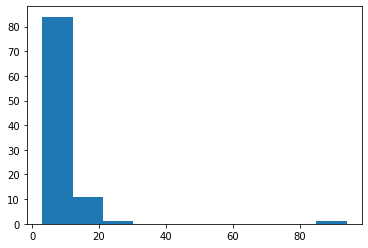

median duration: 8.0
mean duration: 9.31958762886598
-------------------------------------------------------------


TASK   AIClosing-1-4: Die Vorteile durch die Entwicklung von KI überwiegen die Risiken.
Von Stimme nicht zu bis Stimme stark zu
min: 1
max: 100
median: 53.0
mean: 54.31958762886598
std: 20.96513865933655


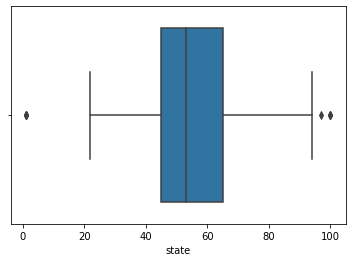

Durations:


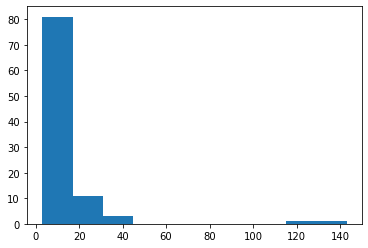

median duration: 9.0
mean duration: 13.577319587628866
-------------------------------------------------------------


TASK   AIClosing-1-6: Hattest du Spaß?
Von Sehr wenig bis Sehr viel
min: 1
max: 100
median: 75.0
mean: 74.09278350515464
std: 24.497457252533945


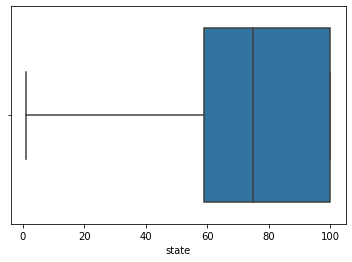

Durations:


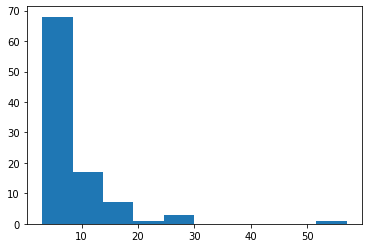

median duration: 7.0
mean duration: 8.577319587628866
-------------------------------------------------------------


TASK   AIClosing-1-7: Hast du etwas gelernt?
Von Sehr wenig bis Sehr viel
min: 1
max: 100
median: 76.0
mean: 74.88659793814433
std: 24.254610057564967


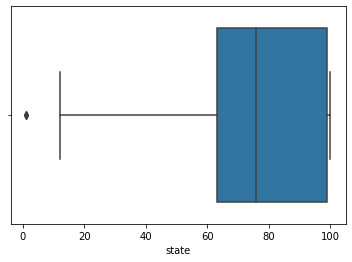

Durations:


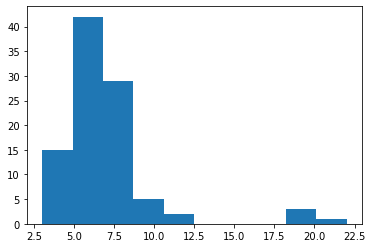

median duration: 6.0
mean duration: 6.701030927835052
-------------------------------------------------------------




In [111]:
outlier_tresh = 2

for i in surveysliders["taskId"].unique():
    slider_i = surveysliders[surveysliders["taskId"] == i]
    state_array = [int(entry) for entry in slider_i["state"]]
    duration_array = [int(entry) for entry in slider_i["duration"]]
    print("TASK   " + surveysliders[surveysliders["taskId"] == i]["taskId"].unique()[0] + ": " + surveysliders[surveysliders["taskId"] == i]["question"].unique()[0])
    print("Von " + str(surveysliders[surveysliders["taskId"] == i]["minLabel"].unique()[0]) + " bis " + str(surveysliders[surveysliders["taskId"] == i]["maxLabel"].unique()[0]))
    print("min: " + str(np.min(state_array)))
    print("max: " + str(np.max(state_array)))
    print("median: " + str(np.median(state_array)))
    print("mean: " + str(np.mean(state_array)))
    print("std: " + str(np.std(state_array)))
    ax = sns.boxplot(x=surveysliders[surveysliders["taskId"] == i]["state"])
    plt.show()
    #ax1 = sns.violinplot(x=state_array)
    #plt.show()
    #print("Ausreißer:")
    #print(surveysliders[(surveysliders["taskId"]==i) & ((surveysliders["state"]<=np.mean(state_array)-outlier_tresh*np.std(state_array)) | (surveysliders["state"]>=np.mean(state_array)+outlier_tresh*np.std(state_array)))][["pupilId", "state"]])
    #print("")
    print("Durations:")
    plt.hist(duration_array)
    plt.show()
    print("median duration: " + str(np.median(duration_array)))
    print("mean duration: " + str(np.mean(duration_array)))
    print("-------------------------------------------------------------")
    print("")
    print("")


## Inputfields

### Durations
#### Gibt es Inputfields, bei denen die SuS besonders lange brauchen?

<AxesSubplot:>

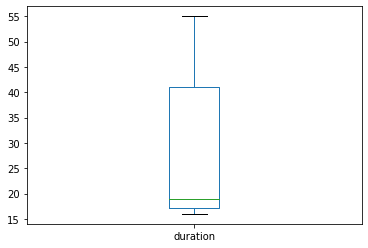

In [5]:
inputfields.groupby("taskId").agg(np.median)[["duration"]].plot(kind="box")

<AxesSubplot:ylabel='taskId'>

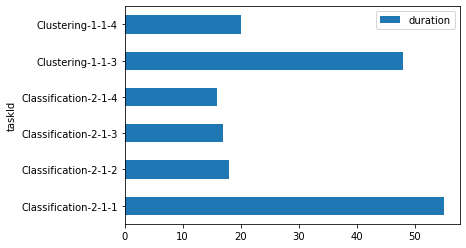

In [6]:
inputfields.groupby("taskId").agg(np.median)[["duration"]].plot(kind="barh")

#### Gibt es SoS, die bei besonders vielen Inputfields lange brauchen?

In [7]:
inputfields[inputfields["duration"] > np.percentile(inputfields["duration"], 95)][["pupilId"]].value_counts()

pupilId          
iw9PMBZxHo8Jjyhw5    3
zBgRiFyXPXhDqsqwb    2
FhFN5eiQduwiYKWEn    2
HxKGojut2Tgf5rb4c    2
dotjrftFetJme4iPH    2
eg47Y5Kpse2DetQ2n    2
Ay6mfswm3SFcQdNJg    2
j3AkifkKRR3t3NeoT    1
jRT6yzZ2ip5ab5ZFM    1
hpxopbQMRwF8CsW3i    1
rdey75egbdBviYKD6    1
hn2oJ5p2CwPfG44wx    1
hkj9srkmDxNs4oQPL    1
kNif57ypHXceM33Yk    1
kdqG4fXAK64zdrqN8    1
aiaYpPdYWJKb2hs7J    1
ZTvPk2i77LDC8pFmu    1
TLqNCrX4jaYixjtv7    1
oqCktQgfHyTGMrZ7n    1
qNwxRmjLQuzRGBe6W    1
hnSuDAuJxnggYbASM    1
dtype: int64

### Antworten

Clustering-1-1-3 Wie viele Youtuber sind sowohl sehr aktiv als auch beliebt?
median number of errors: 2.0
mean number of errors: 1.4545454545454546
std number of errors: 1.3201830855025434
percentage SuS with at least one error: 70


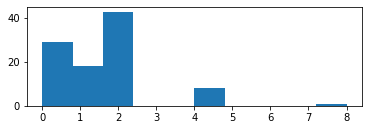

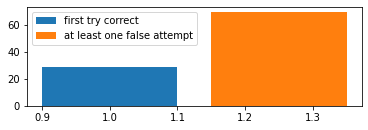

-----------------------------------------------


Clustering-1-1-4 Wie viele Youtuber sind aktiv, haben aber nicht so viele Views?
median number of errors: 1.0
mean number of errors: 1.101010101010101
std number of errors: 1.2909549319250484
percentage SuS with at least one error: 50


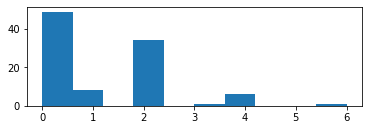

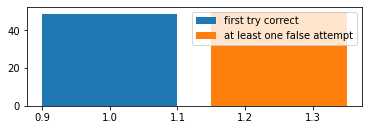

-----------------------------------------------


Classification-2-1-1 Wie viele Filme stimmen zwischen Josi und Alex überein? Gib die Zahl in dieses Feld ein.
median number of errors: 0.0
mean number of errors: 0.3956043956043956
std number of errors: 0.5907551672842029
percentage SuS with at least one error: 34


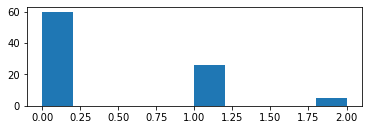

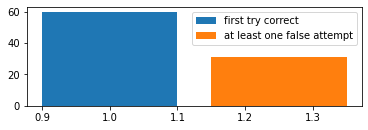

-----------------------------------------------


Classification-2-1-2 Wie viele Filme stimmen zwischen Paul und Alex überein?
median number of errors: 0.0
mean number of errors: 0.24175824175824176
std number of errors: 0.49924468974068337
percentage SuS with at least one error: 20


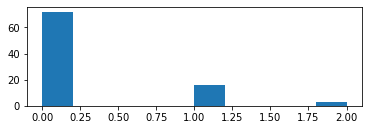

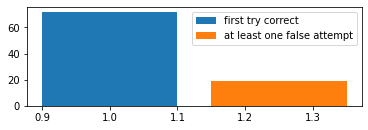

-----------------------------------------------


Classification-2-1-3 Wie viele Filme stimmen zwischen Mahmud und Alex überein?
median number of errors: 0.0
mean number of errors: 0.4175824175824176
std number of errors: 0.7119997232054973
percentage SuS with at least one error: 32


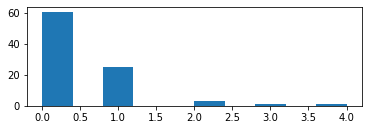

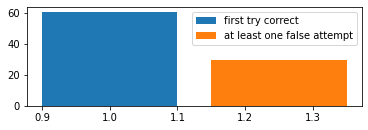

-----------------------------------------------


Classification-2-1-4 Wie viele Filme stimmen zwischen Anna und Alex überein?
median number of errors: 0.0
mean number of errors: 0.23076923076923078
std number of errors: 0.49340536968447574
percentage SuS with at least one error: 19


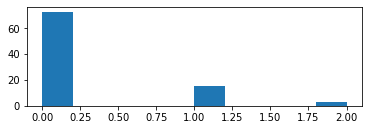

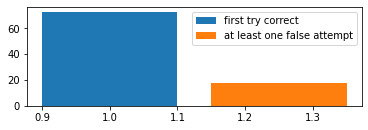

-----------------------------------------------




In [8]:
for taskId in inputfields["taskId"].unique():
    print(str(taskId) + " " + str(inputfields[inputfields["taskId"] == taskId]["question"].unique()[0]))
    taskId_i = inputfields[inputfields["taskId"] == taskId]
    false_attempts = taskId_i["falseAttempts"]
    error_array = []
    abs_number_errors = 0
    number_errors = []
    for entry in false_attempts:
        if type(entry) != np.float:
            abs_number_errors += len(entry)
            number_errors.append(len(entry))
            error_array.append(entry)
        else:
            number_errors.append(0)
    #print("amount of errors: " + str(abs_number_errors))
    print("median number of errors: " + str(np.median(number_errors)))
    print("mean number of errors: " + str(np.mean(number_errors)))
    print("std number of errors: " + str(np.std(number_errors)))
    print("percentage SuS with at least one error: " + str(int((100/len(false_attempts))*len(error_array))))
    plt.subplot(211)
    plt.hist(number_errors)
    plt.show()
    plt.subplot(212)
    ax2 = plt.bar(1, len(list(filter(lambda number: number == 0, number_errors))), 0.2)
    ax3 = plt.bar(1.25, len(list(filter(lambda number: number > 0, number_errors))), 0.2)
    plt.legend((ax2, ax3), ("first try correct", "at least one false attempt"))
    plt.show()
    #duration_false_attempts = []
    #duration_correct_attempts = []
    #for i, entry in taskId_i.iterrows():
    #    if type(entry["falseAttempts"]) != np.float:
    #        duration_false_attempts.append(entry["duration"])
    #    else:
    #        duration_correct_attempts.append(entry["duration"])
    #print("average duration right: " + str(round(np.mean(duration_correct_attempts), 2)) + " with std " + str(round(np.std(duration_correct_attempts), 2)))
    #print("average duration false: " + str(round(np.mean(duration_false_attempts), 2))+ " with std " + str(round(np.std(duration_false_attempts), 2)))
    #print("median duration right: " + str(np.median(duration_correct_attempts)))
    #print("median duration false: " + str(np.median(duration_false_attempts)))
    print("-----------------------------------------------")
    print("\n")
    

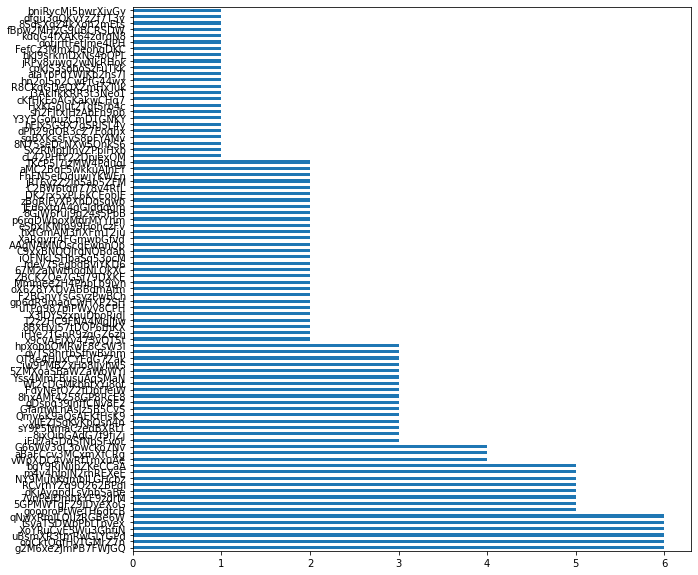

In [9]:
if_false_attempt_df = inputfields.dropna(subset=['falseAttempts'])
if_right_attempts = inputfields[np.where(inputfields["falseAttempts"]!=inputfields["falseAttempts"], True, False)]
#if_false_attempt_df.head()

# machen immer die gleichen SuS fehler?
if_false_attempt_df["pupilId"].value_counts().plot(kind='barh', figsize=(10,10))
plt.show()
#different students made sth wrong

In [12]:
if_false_attempt_df[if_false_attempt_df["hintsTaken"] != 1][["hintsTaken", "taskId", "pupilId", "evaluation", "state", "falseAttempts", "hints"]]

hintsTaken                taskId            pupilId evaluation state  \
236         NaN  Classification-2-1-1  gooproPtWeTH6dtcB      false     1   
237         NaN  Classification-2-1-2  gooproPtWeTH6dtcB      false     1   
239         NaN  Classification-2-1-4  gooproPtWeTH6dtcB      false     1   
686         NaN  Classification-2-1-3  kdqG4fXAK64zdrqN8      false     3   
1068        NaN  Classification-2-1-3  iHYe2TGnR9zgGZ6zh      false     3   
...         ...                   ...                ...        ...   ...   
6053        NaN  Classification-2-1-1  dyTS8nrtbSffwByhm      false     1   
6055        NaN  Classification-2-1-3  dyTS8nrtbSffwByhm      false     3   
6056        NaN  Classification-2-1-4  dyTS8nrtbSffwByhm      false     1   
6156        NaN  Classification-2-1-3  Wt2cDGMkbhtxYj8ot      false     3   
6198        NaN  Classification-2-1-1  fBpw2MH2G9uBCRSDW      false     1   

     falseAttempts hints  
236            [4]   NaN  
237            [3]   NaN  
239            [0]   NaN  
686            [2]   NaN  
1068           [1]   NaN  
...            ...   ...  
6053            []   NaN  
6055           [2]   NaN  
6056           [0]   NaN  
6156           [2]   NaN  
6198           [0]   NaN  

[98 rows x 7 columns]

nicht alle, die was falsch machen, nutzen hints

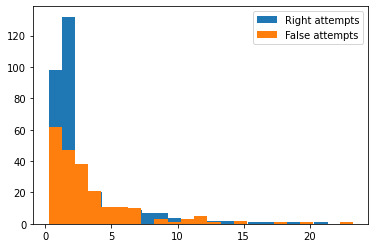

In [27]:
# Duration difference between correct and false attempts
fig, ax1 = plt.subplots()
ax1.hist(if_right_attempts[if_right_attempts["duration"]<400]["duration"]/12, bins=int(np.max(if_right_attempts[if_right_attempts["duration"]<400]["duration"])/12), label='Right attempts')
ax1.hist(if_false_attempt_df["duration"]/12, bins=int(np.max(if_false_attempt_df["duration"])/12), label='False attempts')
ax1.legend()
plt.show()

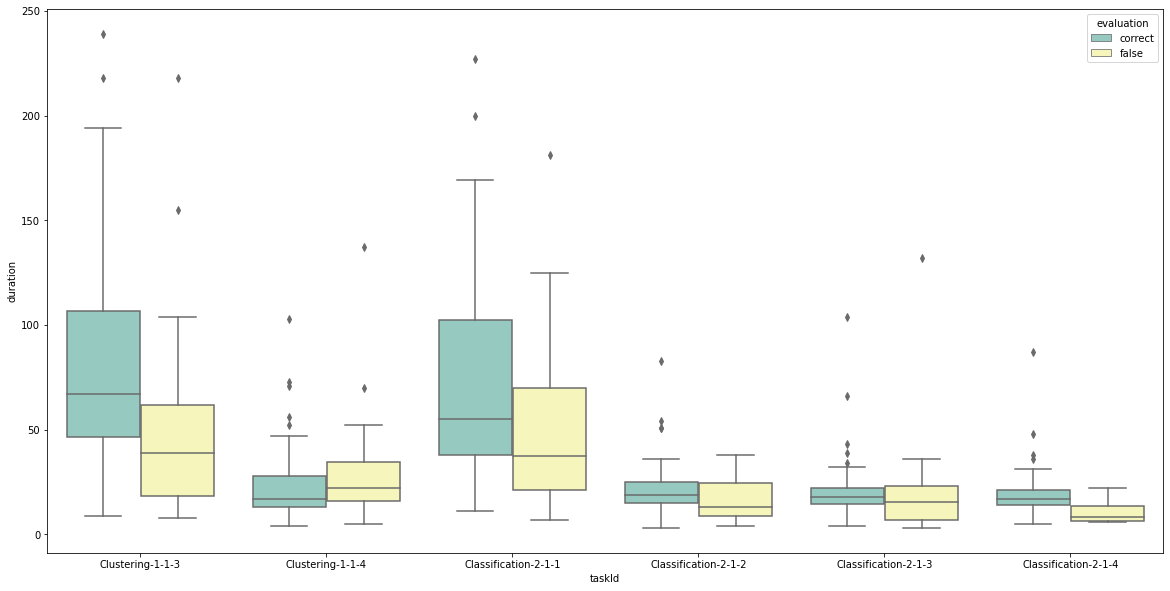

In [28]:
fig = plt.figure(figsize=(20,10))
ax = sns.boxplot(x="taskId", y="duration", hue="evaluation", data=inputfields[inputfields["duration"]<250], palette="Set3")
plt.show()

#### Hilfeanfragen bei InputFields

In [29]:
inputfields.head()

pupilId            classId                taskId  \
24  Ay6mfswm3SFcQdNJg  qFEyvypMn4sAwLwtc      Clustering-1-1-3   
25  Ay6mfswm3SFcQdNJg  qFEyvypMn4sAwLwtc      Clustering-1-1-4   
28  Ay6mfswm3SFcQdNJg  qFEyvypMn4sAwLwtc  Classification-2-1-1   
29  Ay6mfswm3SFcQdNJg  qFEyvypMn4sAwLwtc  Classification-2-1-2   
30  Ay6mfswm3SFcQdNJg  qFEyvypMn4sAwLwtc  Classification-2-1-3   

        taskSeriesId  duration state evaluation falseAttempts hintsTaken  \
24      Clustering-1       137     8    correct           NaN        NaN   
25      Clustering-1        14     7    correct           NaN        NaN   
28  Classification-2       135     1    correct           NaN        NaN   
29  Classification-2        19     1    correct           NaN        NaN   
30  Classification-2        14     3    correct           NaN        NaN   

   revision helpRequested     subType  \
24      NaN           NaN  inputField   
25      NaN           NaN  inputField   
28      NaN           NaN  inputField   
29      NaN           NaN  inputField   
30      NaN           NaN  inputField   

                                             question  \
24  Wie viele Youtuber sind sowohl sehr aktiv als ...   
25  Wie viele Youtuber sind aktiv, haben aber nich...   
28  Wie viele Filme stimmen zwischen Josi und Alex...   
29  Wie viele Filme stimmen zwischen Paul und Alex...   
30  Wie viele Filme stimmen zwischen Mahmud und Al...   

                                                hints sampleSolution  \
24  [{'de': 'In welchem Cluster sind die beliebtes...              8   
25  [{'de': 'Welche Gruppe hat viele Uploads, aber...              7   
28                                                NaN              1   
29                                                NaN              1   
30                                                NaN              3   

    numberFalseAttempts  numberHints  
24                    0          1.0  
25                    0          1.0  
28                    0          NaN  
29                    0          NaN  
30                    0          NaN

## MC
### Durations

#### Sind manche der aufgaben nach median zeitliche ausreißer?

<AxesSubplot:ylabel='taskId'>

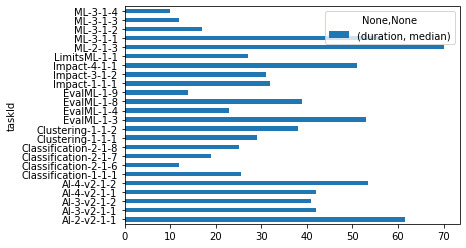

In [102]:
multipleChoice.groupby(["taskId"]).agg([np.median])[["duration"]].plot(kind="barh")

<AxesSubplot:>

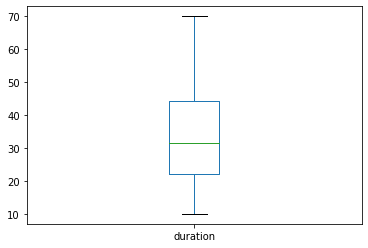

In [35]:
multipleChoice.groupby("taskId").agg(np.median)[["duration"]].plot(kind="box")

#### Bei welcher Aufgabe brauchen besonders viele SuS lange bzw sind das immer die selben?

In [13]:
multipleChoice[multipleChoice["duration"] > np.percentile(multipleChoice["duration"], 95)][["taskId"]].value_counts()

taskId              
ML-3-1-1                22
AI-4-v2-1-2             19
AI-2-v2-1-1             19
ML-2-1-3                12
Impact-1-1-1            10
AI-3-v2-1-1             10
Clustering-1-1-2         9
AI-4-v2-1-1              4
AI-3-v2-1-2              4
ML-3-1-3                 1
Impact-4-1-1             1
Impact-3-1-2             1
EvalML-1-3               1
Classification-2-1-7     1
dtype: int64

In [14]:
multipleChoice[multipleChoice["duration"] > np.percentile(multipleChoice["duration"], 95)][["pupilId"]].value_counts()

pupilId          
zBgRiFyXPXhDqsqwb    8
XKrLvRHLaM7yDisR6    6
6bBwnX2mwAp2NAwNR    5
FhFN5eiQduwiYKWEn    5
dotjrftFetJme4iPH    5
Ay6mfswm3SFcQdNJg    5
j3AkifkKRR3t3NeoT    4
TLqNCrX4jaYixjtv7    4
R8CkqGDeQXZmHxTuk    3
MRSj5LqwWj6WSoj4E    3
eg47Y5Kpse2DetQ2n    3
hnSuDAuJxnggYbASM    3
iFu7aGDqSfNbSFvoL    3
hn2oJ5p2CwPfG44wx    3
kdqG4fXAK64zdrqN8    3
n9zGaAFZH5uiAEoTH    3
BHDJ6HWSM5MZo6YSJ    2
x9cvAEjXv473yQT5t    2
7eqvpzMXwFGaYWHou    2
Kd6FuRsrq6QvPrkKp    2
X3JDYSzxpuDpoRjdJ    2
HxKGojut2Tgf5rb4c    2
ZTvPk2i77LDC8pFmu    2
Q9a6JY4zvQQ9qA2Ms    2
sfmw8KQLy8LGdYmYq    2
rsATbrReo6odn6oXD    2
C2BW6tdii778v4RfL    2
FefCz3MmxDeohgDKC    1
HicSWk5kkvcAz4H8w    1
Decqz7SuZcHMFsSAn    1
Absyuhryq96KZL2Cs    1
AezLL6wL4MCX2JYjB    1
8hxAMt4258GP8RcE8    1
NHPSudYwp9A4DT5t2    1
FtWfJrEwzd8oJCK7M    1
Z9DkQMmtiPiHtteME    1
T4iugPHxim5gX8M4i    1
jRT6yzZ2ip5ab5ZFM    1
vWpXDC4vwRfTmxuAe    1
vNMvj2EsvKXvqk3Qw    1
uo9M6NWSLj8opYpQq    1
sh2FJtxjHzAbFn9pb    1
rdey75egbdBviYKD

mean kann nicht genutzt werden

gibt unterschiede zwischen aufgaben, aber keine einzelne aufgabe ist offiziell ein ausreißer
* länger brauchen sie bei: AI-4-v2-1-2, AI-2-v2-1-1, EvalML-1-3, Impacts-4-1-1, ML-2-1-3, ML-3-1-1
* besonders kurz bei: ML-3-1-4, ML-3-1-3, ML-3-1-2, EvalML-1-9, Classification-2-1-6, (gerade noch bei Classification 2-1-7)

### Results der MC
#### Bei welcher Aufgabe werden wie viele falseAttempts gebraucht und welche Antwort wurde beim ersten versuch wie oft falsch gemacht?

AI-2-v2-1-1
Kannst du erkennen, wo KI überall drin steckt? Denke dabei an die Eigenschaften, die alle KI-Anwendungen verbindet. Bei Multiple-Choice Aufgaben, neben denen “Mehrfachauswahl” steht, können mehrere Antworten richtig sein. Wähle alle richtigen Antworten aus. Wenn du mal nicht weiter weißt, kannst du dir auch einen Tipp holen.

number hints: 1.0
mean number errors:  1.5681818181818181

   numberFalseAttempts
0                33.33
1                15.91
2                33.33
3                 5.30
4                 7.58
5                 1.52
6                 2.27
9                 0.76


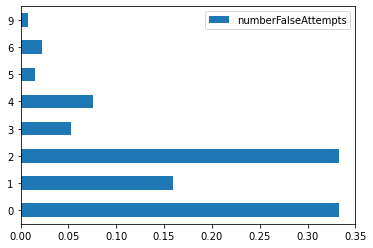

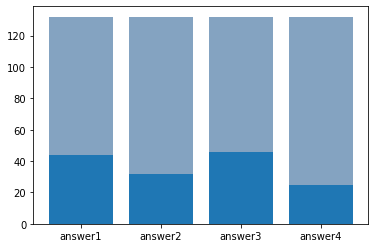

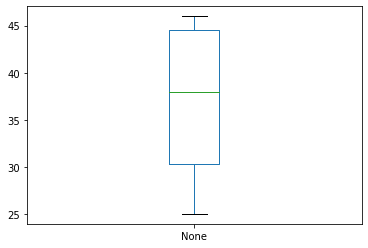

------------
AI-3-v2-1-1
Was für Sachen können KI-Anwendungen?

number hints: 1.0
mean number errors:  1.944

    numberFalseAttempts
0                  17.6
1                  26.4
2                  32.0
3                   5.6
4                  13.6
5                   0.8
6                   2.4
8                   0.8
10                  0.8


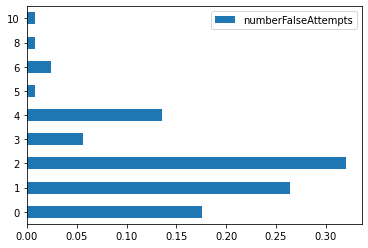

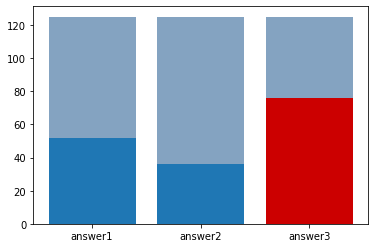

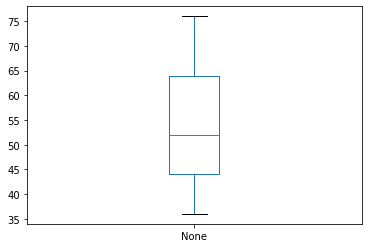

------------
AI-3-v2-1-2
Welche der Aussagen über KI-Anwendungen stimmen?

number hints: 1.0
mean number errors:  1.712

    numberFalseAttempts
0                  29.6
1                  15.2
2                  39.2
3                   1.6
4                   8.0
5                   3.2
6                   1.6
9                   0.8
10                  0.8


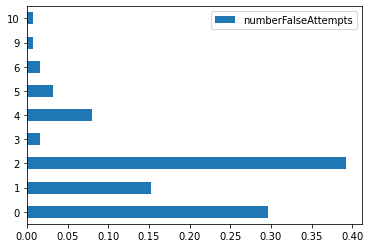

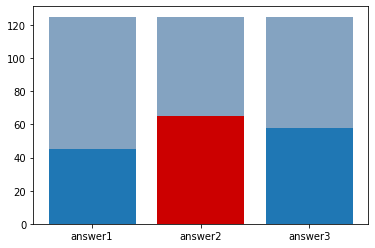

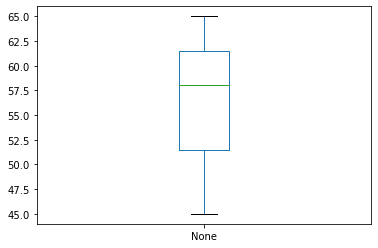

------------
AI-4-v2-1-1
Was bedeuten diese Unterscheidung zwischen spezifischer und allgemeiner KI jetzt für die Intelligenz von KI-Anwendungen?

number hints: 1.0
mean number errors:  1.8839285714285714

    numberFalseAttempts
0                 32.14
1                 13.39
2                 30.36
3                  7.14
4                  8.93
5                  0.89
6                  3.57
7                  0.89
8                  0.89
10                 1.79


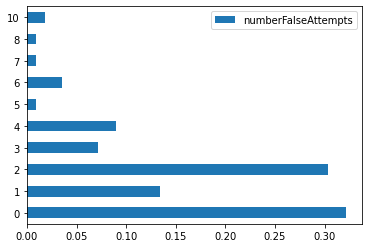

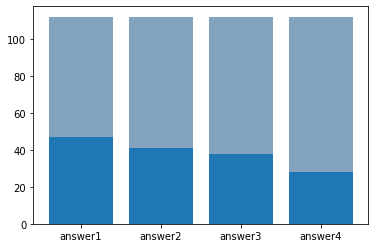

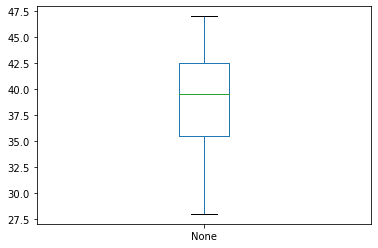

------------
AI-4-v2-1-2
Lass uns noch einmal das Wichtigste wiederholen! Welche dieser Aussagen stimmen?

number hints: 1.0
mean number errors:  2.8214285714285716

   numberFalseAttempts
0                13.39
1                 6.25
2                41.07
3                 7.14
4                15.18
5                 1.79
6                 8.93
7                 0.89
8                 5.36


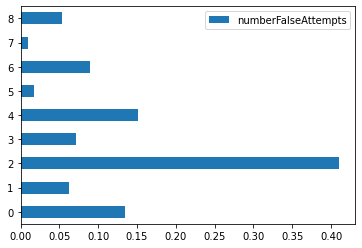

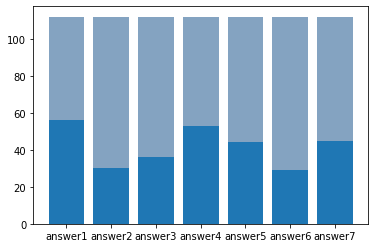

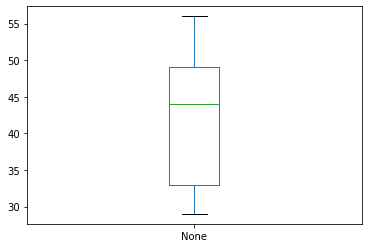

------------
ML-2-1-3
Lass uns das Wichtigste nochmal wiederholen:

number hints: 1.0
mean number errors:  1.2117647058823529

   numberFalseAttempts
0                40.00
1                21.18
2                28.24
3                 1.18
4                 8.24
6                 1.18


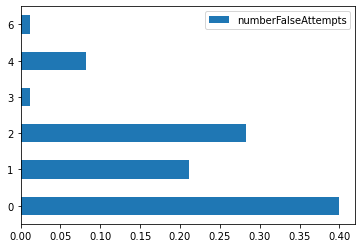

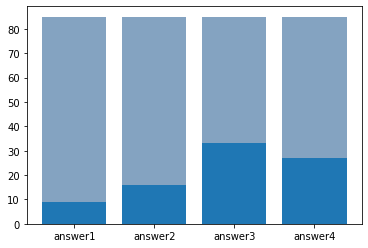

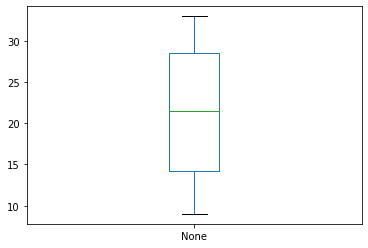

------------
ML-3-1-1
Welche Aussagen stimmen?

number hints: 1.0
mean number errors:  2.011904761904762

   numberFalseAttempts
0                25.00
1                13.10
2                35.71
3                 5.95
4                13.10
5                 2.38
6                 2.38
8                 1.19
9                 1.19


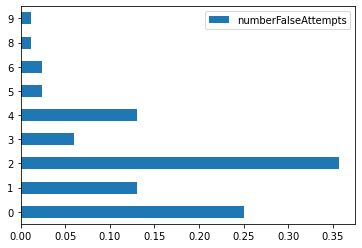

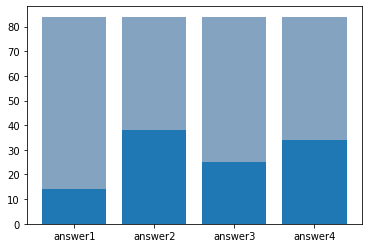

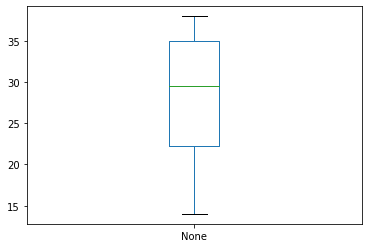

------------
ML-3-1-2
Ein Empfehlungssystem für Musik, das lernt, was du für Musik magst und dann für neu erscheinende Musik voraussagt, ob du sie mögen würdest.

number hints: nan
mean number errors:  0.5476190476190477

   numberFalseAttempts
0                55.95
1                35.71
2                 5.95
3                 2.38


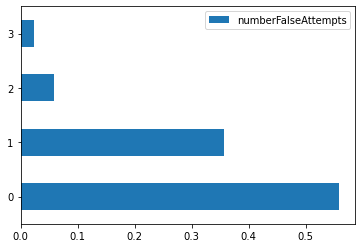

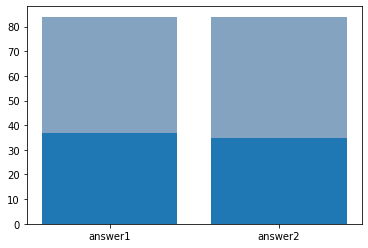

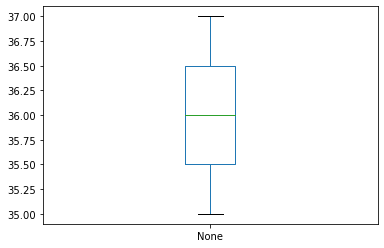

------------
ML-3-1-3
Die Gesichtserkennung von deinem Handy. Anfangs musst du dein Gesicht aus verschiedenen Winkeln filmen. Anhand dieser Beispiele lernt es, dein Gesicht zu erkennen. Wenn dann irgendein Gesicht versucht, dein Handy zu entsperren, kann es voraussagen, ob es dein Gesicht ist oder nicht.

number hints: nan
mean number errors:  0.5595238095238095

   numberFalseAttempts
0                53.57
1                40.48
2                 3.57
3                 1.19
4                 1.19


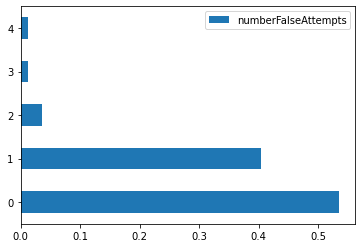

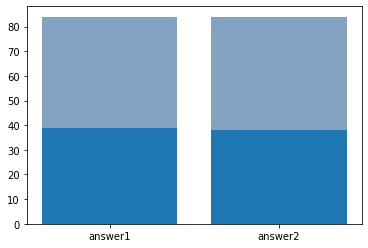

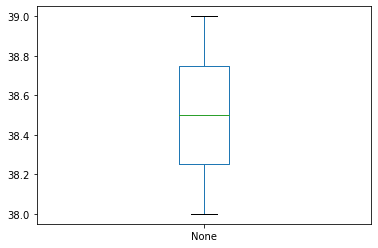

------------
ML-3-1-4
Wenn wir Youtuber nach der Anzahl ihrer Follower und der Themen ihrer Videos gruppieren.

number hints: nan
mean number errors:  0.4642857142857143

   numberFalseAttempts
0                64.29
1                26.19
2                 8.33
3                 1.19


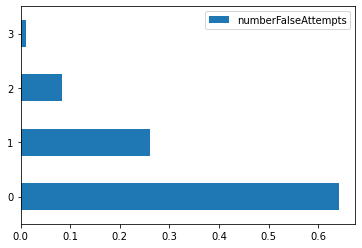

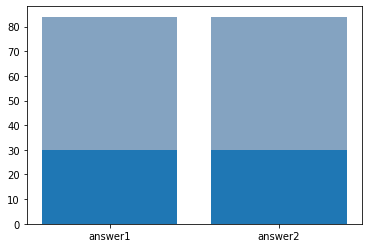

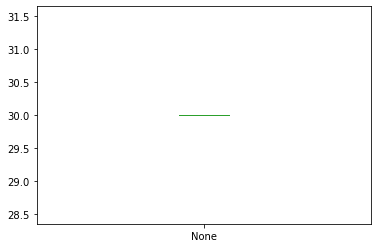

------------
Clustering-1-1-1
Was war unüberwachtes Lernen noch gleich?

number hints: 1.0
mean number errors:  1.5151515151515151

   numberFalseAttempts
0                27.27
1                13.13
2                48.48
3                 4.04
4                 6.06
5                 1.01


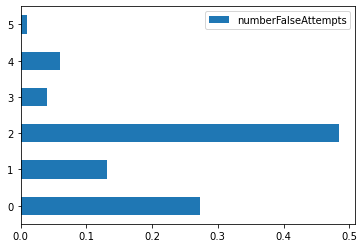

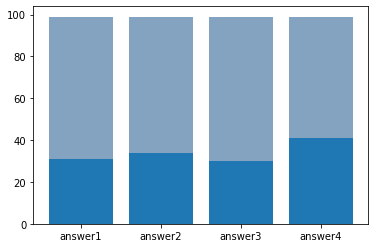

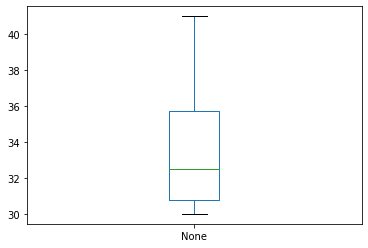

------------
Clustering-1-1-2
Welche Aussagen über die anderen beiden Cluster stimmen?

number hints: nan
mean number errors:  0.30303030303030304

   numberFalseAttempts
0                70.71
1                28.28
2                 1.01


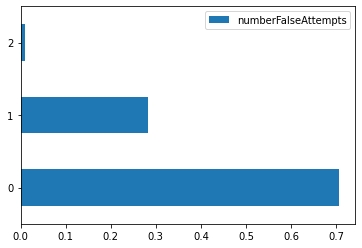

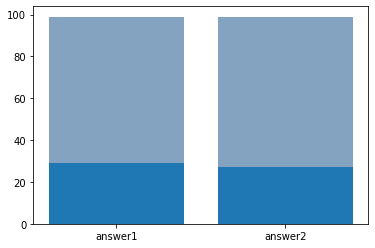

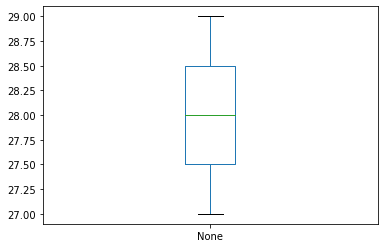

------------
Classification-1-1-1
Welche Aussagen stimmen?

number hints: 1.0
mean number errors:  1.5104166666666667

   numberFalseAttempts
0                31.25
1                10.42
2                45.83
3                 3.12
4                 8.33
6                 1.04


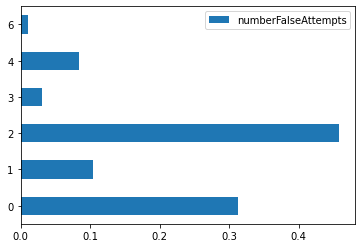

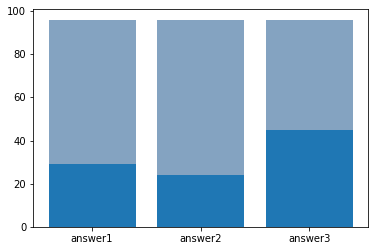

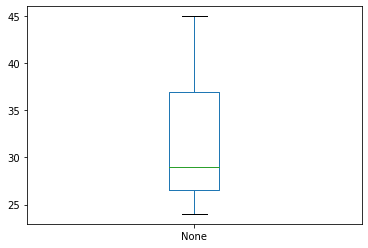

------------
Classification-2-1-6
Wer hat den ähnlichsten Filmgeschmack zu Alex?

number hints: 1.0
mean number errors:  0.15384615384615385

   numberFalseAttempts
0                93.41
1                 1.10
2                 3.30
3                 1.10
4                 1.10


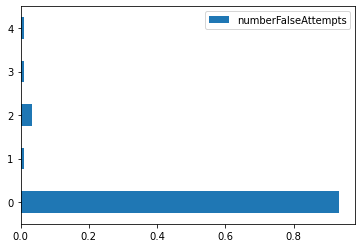

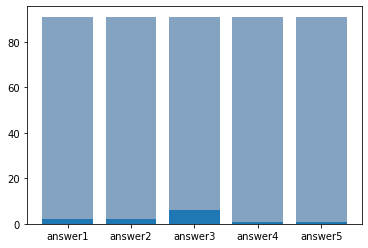

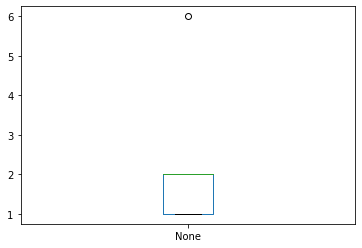

------------
Classification-2-1-7
Welchen Film kannst du Alex guten Gewissens empfehlen?

number hints: 1.0
mean number errors:  0.5714285714285714

   numberFalseAttempts
0                67.03
1                19.78
2                 9.89
4                 2.20
8                 1.10


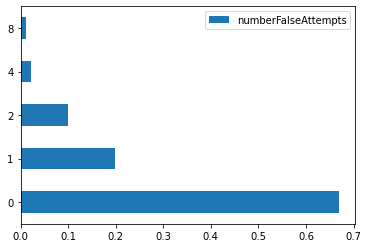

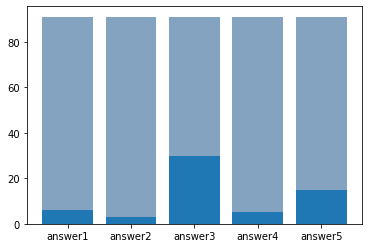

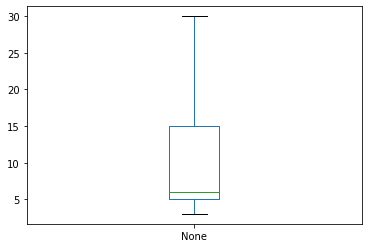

------------
Classification-2-1-8
Welche Aussagen stimmen?

number hints: 1.0
mean number errors:  1.4615384615384615

   numberFalseAttempts
0                31.87
1                20.88
2                36.26
3                 1.10
4                 7.69
8                 1.10
9                 1.10


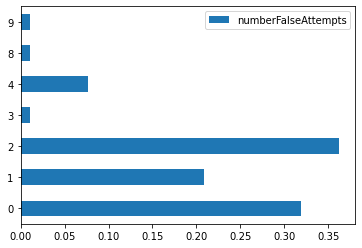

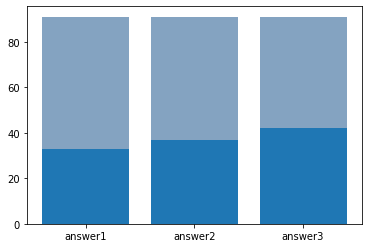

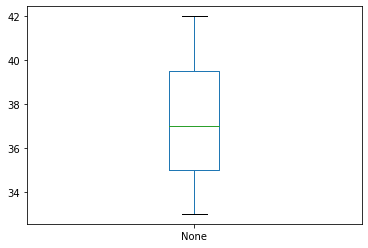

------------
LimitsML-1-1
Was könnte passieren, wenn wir bei den Hundebildern nur Bilder von einer Hunderasse nutzen würden?

number hints: nan
mean number errors:  0.6363636363636364

   numberFalseAttempts
0                48.05
1                42.86
2                 6.49
3                 2.60


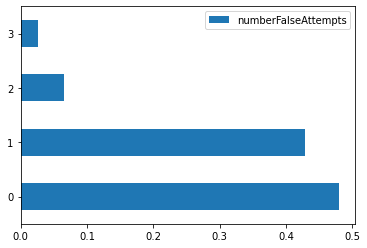

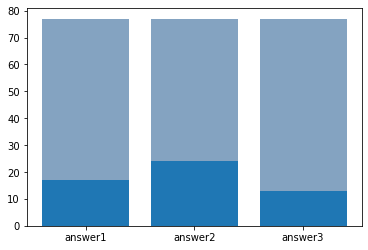

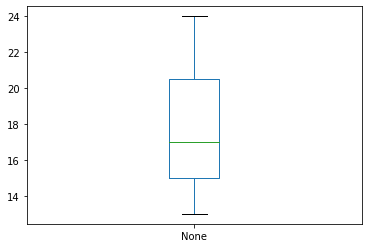

------------
EvalML-1-3
Welche der Aussagen stimmen?

number hints: nan
mean number errors:  1.095890410958904

   numberFalseAttempts
0                10.96
1                75.34
2                 8.22
3                 4.11
4                 1.37


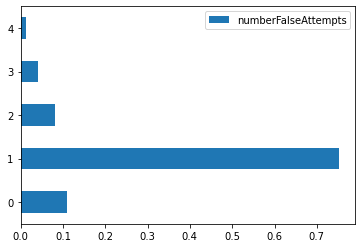

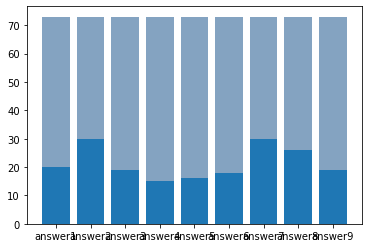

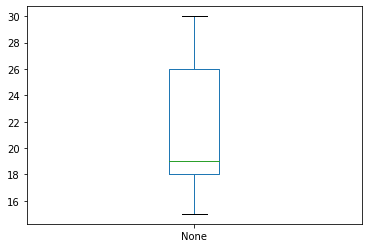

------------
EvalML-1-4
Welche der folgenden Anwendungen enthalten KI-Methoden?

number hints: 1.0
mean number errors:  1.0684931506849316

   numberFalseAttempts
0                43.84
1                19.18
2                31.51
4                 4.11
6                 1.37


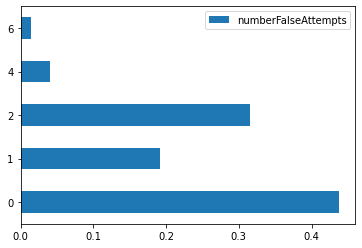

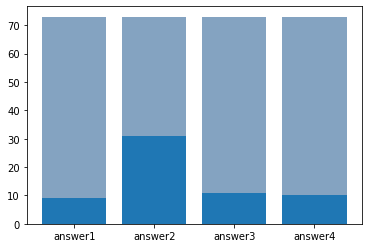

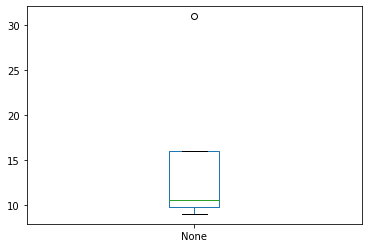

------------
EvalML-1-8
Welche der Aussagen über maschinelles Lernen stimmen?

number hints: nan
mean number errors:  1.095890410958904

   numberFalseAttempts
0                23.29
1                58.90
2                10.96
3                 5.48
9                 1.37


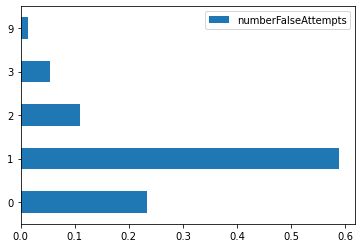

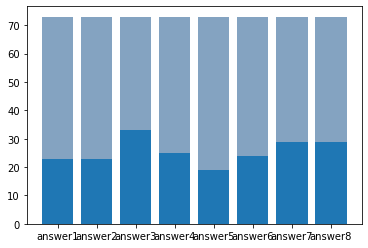

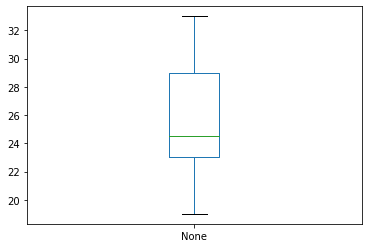

------------
EvalML-1-9
Welche Art des Lernens sind folgende Aufgaben?

number hints: nan
mean number errors:  0.6986301369863014

   numberFalseAttempts
0                39.73
1                52.05
2                 6.85
3                 1.37


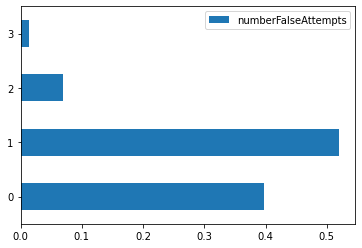

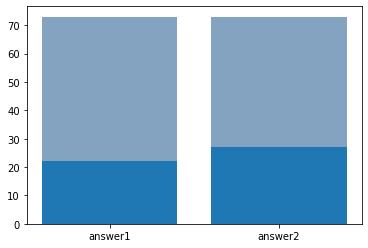

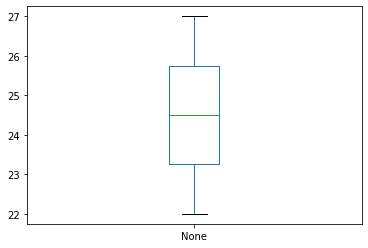

------------
Impact-3-1-2
Welche Jobs sind also bedroht?

number hints: 2.0
mean number errors:  2.5841584158415842

   numberFalseAttempts
0                20.79
1                12.87
2                 6.93
3                41.58
4                 2.97
5                 1.98
6                 9.90
8                 0.99
9                 1.98


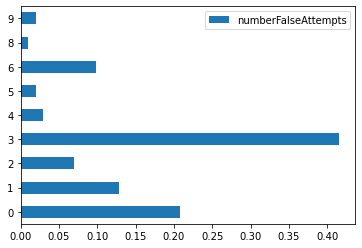

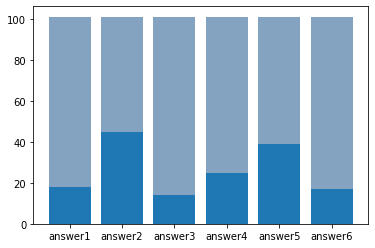

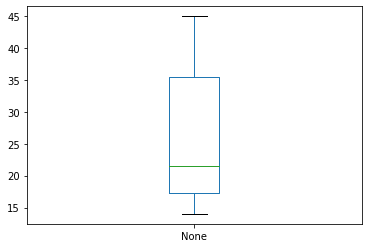

------------
Impact-1-1-1
Was glaubst du, warum das Gesicht der dunkelhäutigen Frau nicht erkannt wurde?

number hints: nan
mean number errors:  0.12612612612612611

   numberFalseAttempts
0                88.29
1                10.81
2                 0.90


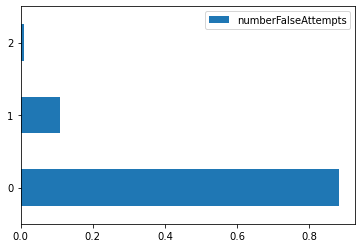

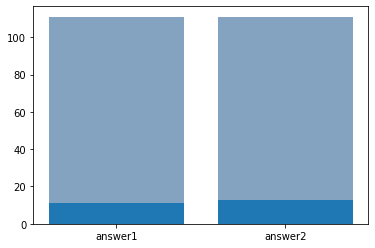

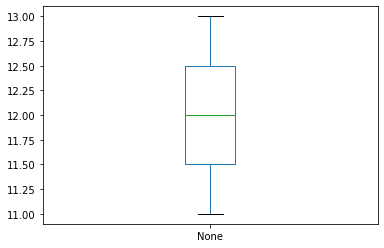

------------
Impact-4-1-1
Was sind möglichen Folgen vom Einsatz von KI in der Medizin?

number hints: 1.0
mean number errors:  1.969387755102041

    numberFalseAttempts
0                 16.33
1                 11.22
2                 57.14
3                  3.06
4                  8.16
6                  2.04
7                  1.02
10                 1.02


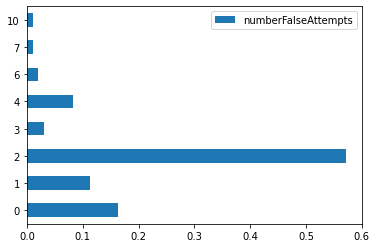

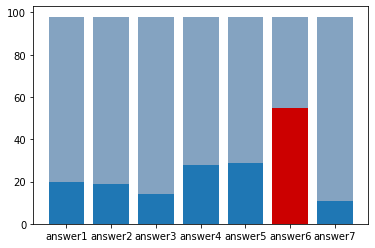

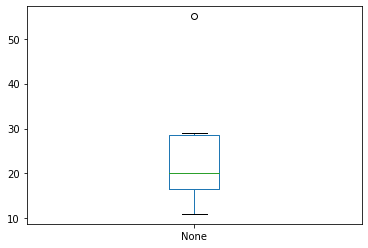

------------


In [32]:
for taskId in multipleChoice["taskId"].unique():
    print(taskId)
    print(task_df.loc[taskId, "question"])
    print("\nnumber hints: " + str(multipleChoice[multipleChoice["taskId"] == taskId]["numberHints"].unique()[0]))
    print("mean number errors: ", np.mean(multipleChoice[multipleChoice["taskId"] == taskId]["numberFalseAttempts"]))
    #print(pd.Series(multipleChoice[multipleChoice["taskId"] == taskId]["numberFalseAttempts"].value_counts(sort=False)*100/np.sum(multipleChoice[multipleChoice["taskId"] == taskId]["numberFalseAttempts"].value_counts(sort=False))))
    print()
    print(round(multipleChoice[multipleChoice["taskId"] == taskId]["numberFalseAttempts"].value_counts(sort=False, normalize=True).to_frame()*100, 2))
    
    #pd.Series(multipleChoice[multipleChoice["taskId"] == taskId]["numberFalseAttempts"].value_counts(sort=False)*100/np.sum(multipleChoice[multipleChoice["taskId"] == taskId]["numberFalseAttempts"].value_counts(sort=False))).plot(kind='barh')
    multipleChoice[multipleChoice["taskId"] == taskId]["numberFalseAttempts"].value_counts(sort=False, normalize=True).to_frame().plot(kind='barh')
    plt.show()
    
    task_i = multipleChoice[multipleChoice["taskId"] == taskId]
    sampleSolution_i = list(task_i["sampleSolution"][0:1])[0]
    
    with_false_attempts = task_i[task_i["falseAttempts"] == task_i["falseAttempts"]]
    first_falseAttempts_i = [elem[0] for elem in with_false_attempts["falseAttempts"]]
    
    nr_all_tasks = np.array([len(task_i) for answer in sampleSolution_i])
    nr_errors_in_first_false_attempt = np.array([0 for answer in sampleSolution_i])
    for falseAttempt in first_falseAttempts_i:
        nr_errors_in_first_false_attempt += np.array([a != f for a,f in zip(sampleSolution_i,falseAttempt)]).astype(int)
    
    misskonzepte = np.array([0 for answer in sampleSolution_i])
    for i in range(len(nr_errors_in_first_false_attempt)):
        if nr_errors_in_first_false_attempt[i]>nr_all_tasks[i]/2:
            misskonzepte[i] = nr_errors_in_first_false_attempt[i]
    
    labels = ["answer" + str(i) for i in range(1, len(sampleSolution_i)+1)]
    plt.bar(labels, nr_all_tasks, color=(0.2, 0.4, 0.6, 0.6)) #0.1, 0.1, 0.1, 0.1 #0.2, 0.4, 0.6, 0.6
    plt.bar(labels, nr_errors_in_first_false_attempt)
    plt.bar(labels, misskonzepte, color=(0.8, 0, 0, 1))
    plt.show()
    
    pd.Series(nr_errors_in_first_false_attempt).plot(kind="box")
    plt.show()
    
    print("------------")

#### Itemschwierigkeit

schwierigkeitsindex (bei zweistufigen antworten wie MCs) = Zahl der „Richtiglöser“ / Zahl der Probanden

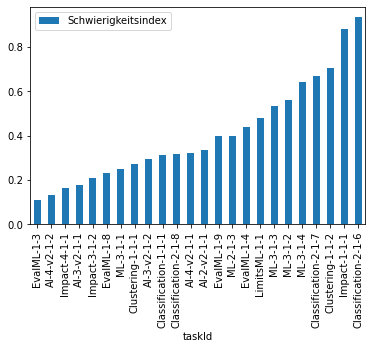

                      Schwierigkeitsindex
taskId                                   
EvalML-1-3                       0.109589
AI-4-v2-1-2                      0.133929
Impact-4-1-1                     0.163265
AI-3-v2-1-1                      0.176000
Impact-3-1-2                     0.207921
EvalML-1-8                       0.232877
ML-3-1-1                         0.250000
Clustering-1-1-1                 0.272727
AI-3-v2-1-2                      0.296000
Classification-1-1-1             0.312500
Classification-2-1-8             0.318681
AI-4-v2-1-1                      0.321429
AI-2-v2-1-1                      0.333333
EvalML-1-9                       0.397260
ML-2-1-3                         0.400000
EvalML-1-4                       0.438356
LimitsML-1-1                     0.480519
ML-3-1-3                         0.535714
ML-3-1-2                         0.559524
ML-3-1-4                         0.642857
Classification-2-1-7             0.670330
Clustering-1-1-2                 0

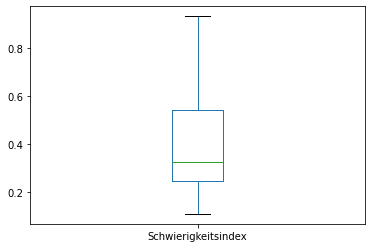

In [55]:
schwierigkeitsDict = {"taskId": [], "Schwierigkeitsindex": []}
#schwierigkeitsDict1 = {}

for taskId in multipleChoice["taskId"].unique():
    #print(taskId)
    task_i = multipleChoice[multipleChoice["taskId"] == taskId]
    
    with_false_attempts = task_i[task_i["falseAttempts"] == task_i["falseAttempts"]]
    without_false_attempts = task_i[task_i["falseAttempts"] != task_i["falseAttempts"]]
    #print(len(with_false_attempts))
    #print(len(without_false_attempts))

    itemSchwierigkeit = len(without_false_attempts) / (len(without_false_attempts)+len(with_false_attempts))
    #print(itemSchwierigkeit)
    #print("------------")
    schwierigkeitsDict["taskId"].append(taskId)
    schwierigkeitsDict["Schwierigkeitsindex"].append(itemSchwierigkeit)
    #schwierigkeitsDict1.append({taskId: itemSchwierigkeit})

itemSchwierigkeitsDf = pd.DataFrame(schwierigkeitsDict).set_index('taskId')
itemSchwierigkeitsDf.sort_values(by=['Schwierigkeitsindex'], inplace=True)

itemSchwierigkeitsDf.plot(kind="bar")
plt.show()

print(itemSchwierigkeitsDf)

itemSchwierigkeitsDf.plot(kind="box")
plt.show()

Es gibt keine formalen Ausreißer bei der Itemschwierigkeit, Trotzdem gibt es eine große Variabilität.

Ein niedriger Index heißt, besonders wenige SuS konnten die Aufgabe direkt lösen.

besonders schwere (unter 0.2):
* EvalML-1-3                 0.109589
* AI-4-v2-1-2                0.133929
* Impact-4-1-1               0.163265
* AI-3-v2-1-1                0.176000

besonders leichte (vllt auch nur die beiden über 0.8):
* Clustering-1-1-2           0.707071
* Impact-1-1-1               0.882883
* Classification-2-1-6       0.934066

#### Welche Antworten sind die schwierigsten?

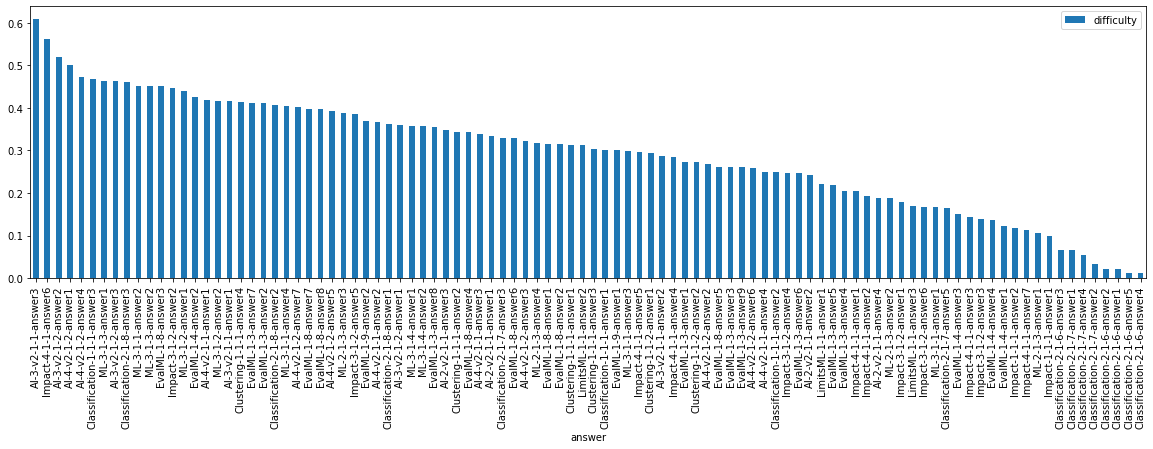

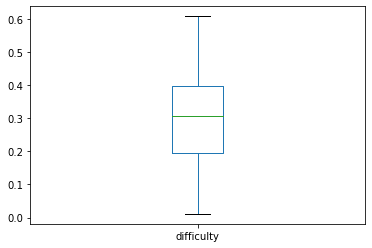

                              difficulty
answer                                  
AI-3-v2-1-1-answer3             0.608000
Impact-4-1-1-answer6            0.561224
AI-3-v2-1-2-answer2             0.520000
AI-4-v2-1-2-answer1             0.500000
AI-4-v2-1-2-answer4             0.473214
Classification-1-1-1-answer3    0.468750
ML-3-1-3-answer1                0.464286
AI-3-v2-1-2-answer3             0.464000
Classification-2-1-8-answer3    0.461538
ML-3-1-1-answer2                0.452381
ML-3-1-3-answer2                0.452381
EvalML-1-8-answer3              0.452055
Impact-3-1-2-answer2            0.445545
ML-3-1-2-answer1                0.440476
EvalML-1-4-answer2              0.424658
AI-4-v2-1-1-answer1             0.419643
ML-3-1-2-answer2                0.416667
AI-3-v2-1-1-answer1             0.416000
Clustering-1-1-1-answer4        0.414141
EvalML-1-3-answer7              0.410959
EvalML-1-3-answer2              0.410959
Classification-2-1-8-answer2    0.406593
ML-3-1-1-answer4

In [56]:
answersByDifficulty = {"answer": [], "difficulty": []}

for taskId in multipleChoice["taskId"].unique():
    #print(taskId)

    #multipleChoice[multipleChoice["taskId"] == taskId]["numberFalseAttempts"].value_counts(sort=False, normalize=True).to_frame().plot(kind='barh')
    #plt.show()
    
    task_i = multipleChoice[multipleChoice["taskId"] == taskId]
    sampleSolution_i = list(task_i["sampleSolution"][0:1])[0]
    
    with_false_attempts = task_i[task_i["falseAttempts"] == task_i["falseAttempts"]]
    first_falseAttempts_i = [elem[0] for elem in with_false_attempts["falseAttempts"]]
    #nr_all_tasks = np.array([len(task_i) for answer in sampleSolution_i])
    nr_errors_in_first_false_attempt = np.array([0 for answer in sampleSolution_i])
    for falseAttempt in first_falseAttempts_i:
        nr_errors_in_first_false_attempt += np.array([a != f for a,f in zip(sampleSolution_i,falseAttempt)]).astype(int)
    
    for index, entry in pd.DataFrame(nr_errors_in_first_false_attempt).iterrows():
        answersByDifficulty["answer"].append(taskId+"-answer"+str(index+1))
        answersByDifficulty["difficulty"].append(entry[0]/len(task_i))
        #print(entry[0])
        #print(len(task_i))
        #print(taskId+str(index))
    #misskonzepte = np.array([0 for answer in sampleSolution_i])
    #for i in range(len(nr_errors_in_first_false_attempt)):
    #    if nr_errors_in_first_false_attempt[i]>nr_all_tasks[i]/2:
    #        misskonzepte[i] = nr_errors_in_first_false_attempt[i]
    
    #labels = ["answer" + str(i) for i in range(1, len(sampleSolution_i)+1)]
    #plt.bar(labels, nr_all_tasks, color=(0.2, 0.4, 0.6, 0.6)) #0.1, 0.1, 0.1, 0.1 #0.2, 0.4, 0.6, 0.6
    #plt.bar(labels, nr_errors_in_first_false_attempt)
    #plt.bar(labels, misskonzepte, color=(0.8, 0, 0, 1))
    #plt.show()
    
    #pd.Series(nr_errors_in_first_false_attempt).plot(kind="box")
    #plt.show()
    
    #print("------------")

answersByDifficultyDf = pd.DataFrame(answersByDifficulty).set_index('answer')
answersByDifficultyDf.sort_values(by=['difficulty'], inplace=True, ascending=False)

answersByDifficultyDf.plot(kind="bar", figsize=(20,5))
plt.show()

answersByDifficultyDf.plot(kind="box")
plt.show()

print(answersByDifficultyDf.to_string())

MC Antworten nach Anteil der SuS, die sie beim ersten versuch falsch gemacht haben.

Gibt keine formalen Ausreißer, aber große Variabilität

#### Bei welchen Aufgaben gab es besonders viele SuS mit vielen falseAttempts?

<AxesSubplot:ylabel='taskId'>

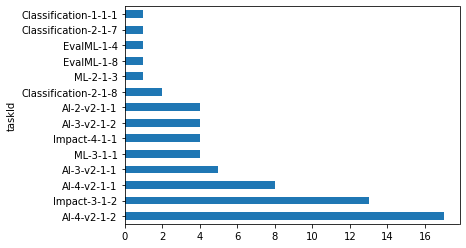

In [43]:
multipleChoice[multipleChoice["numberFalseAttempts"] >5].value_counts("taskId").plot(kind="barh")

<AxesSubplot:ylabel='taskId'>

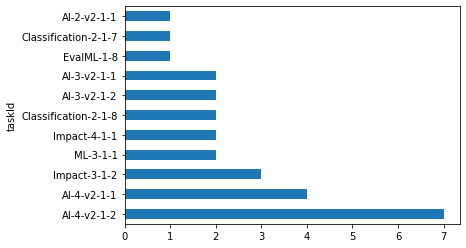

In [42]:
multipleChoice[multipleChoice["numberFalseAttempts"] >6].value_counts("taskId").plot(kind="barh")

#### Welche Aufgaben mussten besonders oft wiederholt werden? (falseAttempts mehr als 2*hints +1)

<AxesSubplot:ylabel='taskId'>

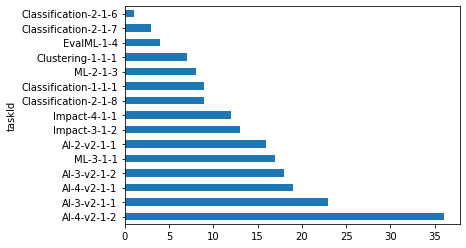

In [44]:
multipleChoice[multipleChoice["numberFalseAttempts"] >2*multipleChoice["numberHints"]+1].value_counts("taskId").plot(kind="barh")

#### Bei welchen Antworten wurden in allen falseAttempts die meisten Fehler gemacht? Ist eine der Antwortmöglichkeiten ein signifikanter Ausreißer?

AI-4-v2-1-2


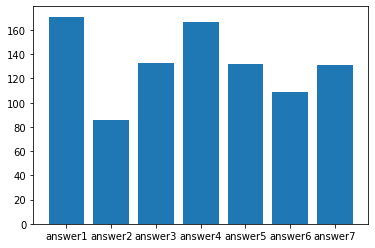

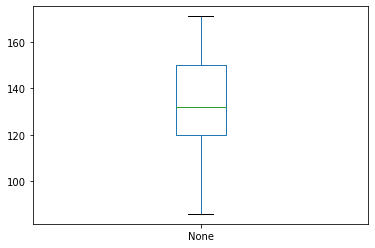

------------
AI-3-v2-1-1


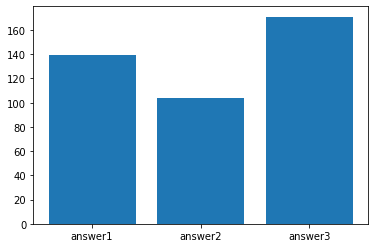

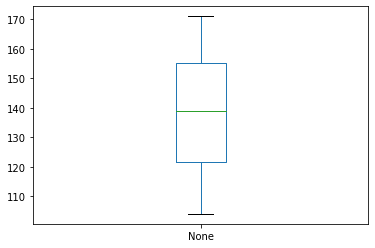

------------
AI-4-v2-1-1


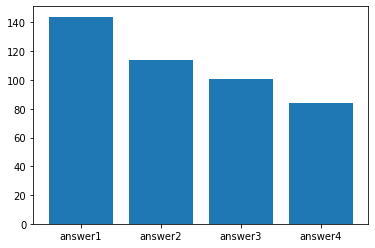

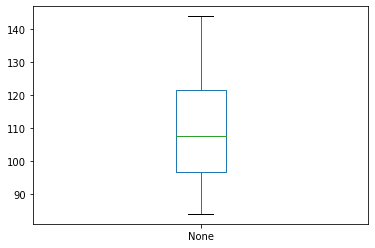

------------
AI-3-v2-1-2


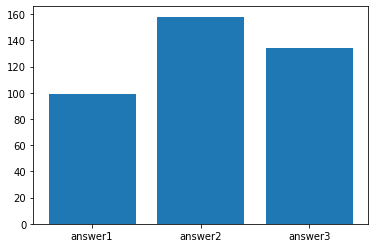

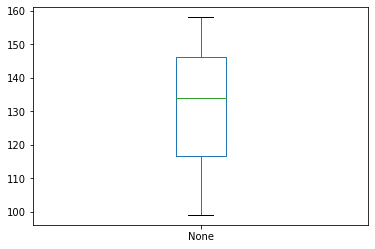

------------
ML-3-1-1


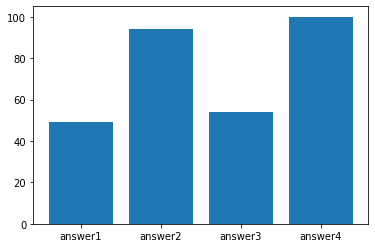

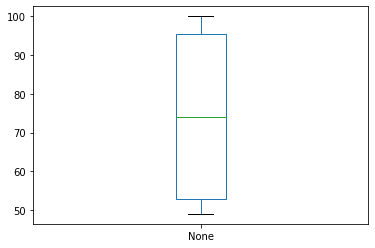

------------
AI-2-v2-1-1


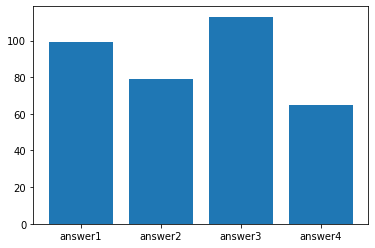

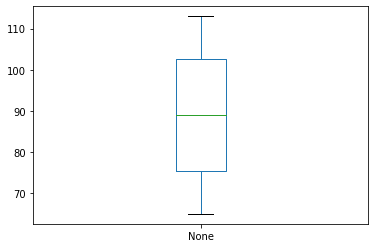

------------
Impact-3-1-2


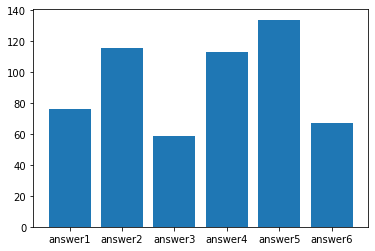

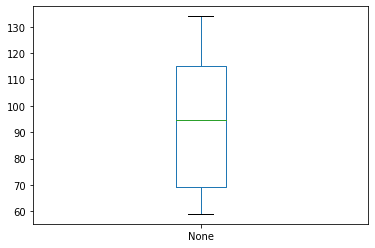

------------
Impact-4-1-1


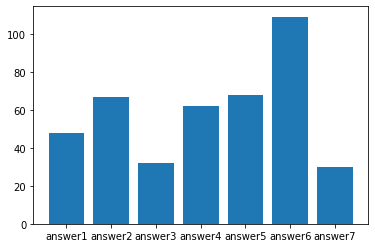

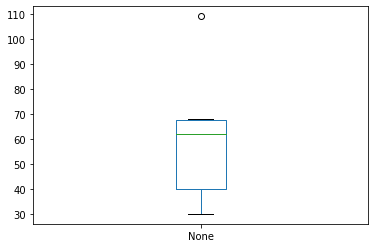

------------
Classification-2-1-8


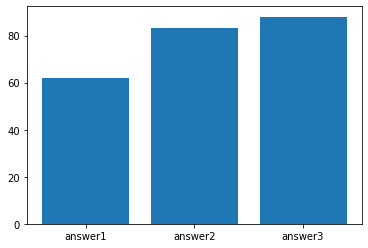

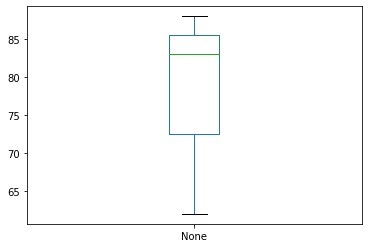

------------
Classification-1-1-1


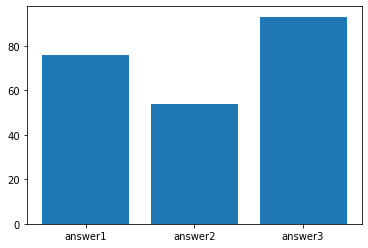

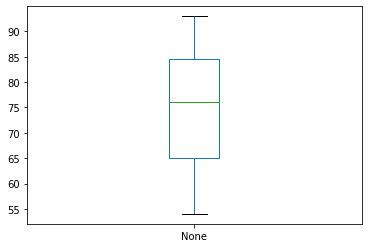

------------
ML-2-1-3


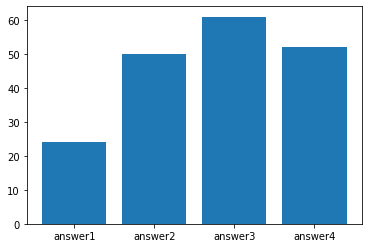

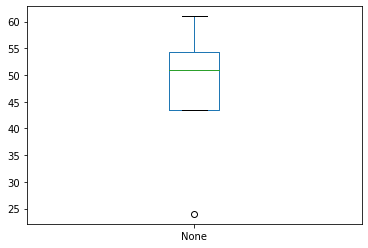

------------
Clustering-1-1-1


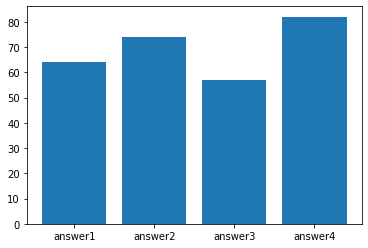

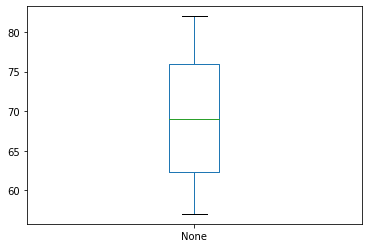

------------
EvalML-1-4


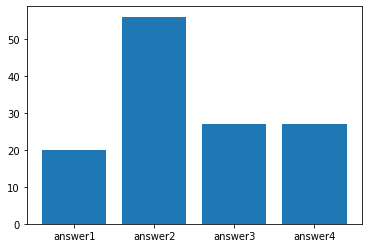

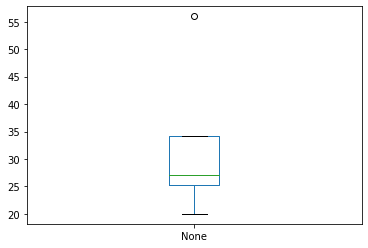

------------
Classification-2-1-7


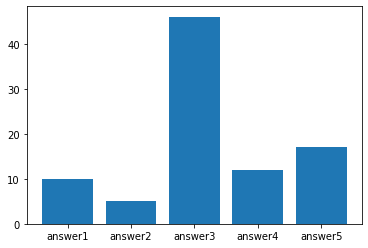

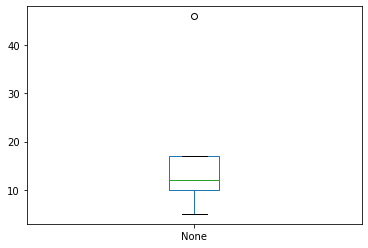

------------
Classification-2-1-6


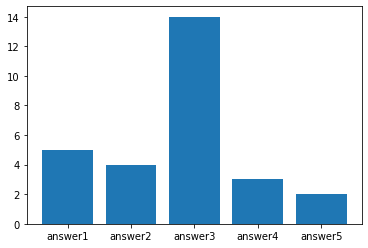

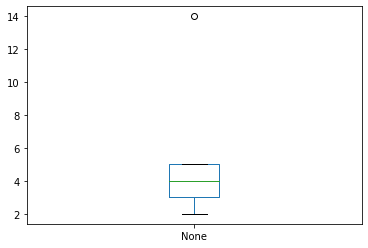

------------


In [78]:
for taskId in multipleChoice[multipleChoice["numberFalseAttempts"] >2*multipleChoice["numberHints"]+1].value_counts("taskId").index.tolist():
    task_i = multipleChoice[multipleChoice["taskId"] == taskId]
    sampleSolution_i = list(task_i["sampleSolution"][0:1])[0]

    with_false_attempts = task_i[task_i["falseAttempts"] == task_i["falseAttempts"]]
    totalFalseAttempts = [elem for elem in with_false_attempts["falseAttempts"]]
    
    nr_all_tasks = np.array([len(task_i) for answer in sampleSolution_i])
    nr_errors_in_false_attempts = np.array([0 for answer in sampleSolution_i])
    for pupilFalseAttempts in totalFalseAttempts:
        for falseAttempt in pupilFalseAttempts:
            nr_errors_in_false_attempts += np.array([a != f for a,f in zip(sampleSolution_i,falseAttempt)]).astype(int)
    
    print(taskId)
    
    labels = ["answer" + str(i) for i in range(1, len(sampleSolution_i)+1)]
    plt.bar(labels, nr_errors_in_false_attempts)
    plt.show()
    
    pd.Series(nr_errors_in_false_attempts).plot(kind="box")
    plt.show()
    
    print("------------")

In [ ]:
# alle antworten nach anzahlen fehler
for taskId in multipleChoice:
    

#### Gibt es eine Aufgabe, bei der die durchschnittliche Anzahl an Fehlern ein Ausreißer ist für Aufgaben mit gleich vielen hints?

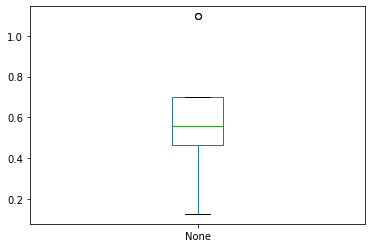

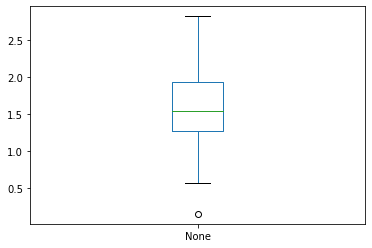

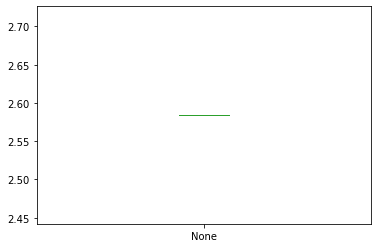

In [14]:
mean_errors_nohint = []
mean_errors_onehint = []
mean_errors_twohints = []

for taskId in multipleChoice["taskId"].unique():
    if(multipleChoice[multipleChoice["taskId"] == taskId]["numberHints"].unique()[0] != multipleChoice[multipleChoice["taskId"] == taskId]["numberHints"].unique()[0]):
        mean_errors_nohint.append(np.mean(multipleChoice[multipleChoice["taskId"] == taskId]["numberFalseAttempts"]))
    elif(multipleChoice[multipleChoice["taskId"] == taskId]["numberHints"].unique()[0] == 1.0):
        mean_errors_onehint.append(np.mean(multipleChoice[multipleChoice["taskId"] == taskId]["numberFalseAttempts"]))
    elif(multipleChoice[multipleChoice["taskId"] == taskId]["numberHints"].unique()[0] == 2.0):
        mean_errors_twohints.append(np.mean(multipleChoice[multipleChoice["taskId"] == taskId]["numberFalseAttempts"]))
    else:
        print("TOO MANY HINTS")
        
pd.Series(mean_errors_nohint).plot(kind="box")
plt.show()
pd.Series(mean_errors_onehint).plot(kind="box")
plt.show()
pd.Series(mean_errors_twohints).plot(kind="box")
plt.show()

Gibt wenige Ausreißer: darunter bei one hint, darüber bei no hint

sollte bedacht werden, dass das nur relativ zur Anzahl fehler bei anderen aufgaben ist.

### Welche Antworten waren das Problem?
DAS kann eigentlich auch raus

AI-2-v2-1-1
Kannst du erkennen, wo KI überall drin steckt? Denke dabei an die Eigenschaften, die alle KI-Anwendungen verbindet. Bei Multiple-Choice Aufgaben, neben denen “Mehrfachauswahl” steht, können mehrere Antworten richtig sein. Wähle alle richtigen Antworten aus. Wenn du mal nicht weiter weißt, kannst du dir auch einen Tipp holen.

* 1. Die Startseite einer Webseite, die jedem Besucher die gleichen Inhalte anzeigt nutzt KI
* 2. Die Personalisierung einer Google-Anfrage nutzt KI
* 3. Gesichtserkennung nutzt KI
* 4. Der Newsfeed eines Social Network nutzt KI


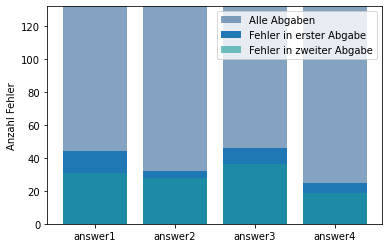

In 66.66666666666666% der Fälle wurde bei der ersten Abgabe ein Fehler gemacht
--------------------------------------------------

AI-3-v2-1-1
Was für Sachen können KI-Anwendungen?

* 1. Das Programm zur Gesichtserkennung auf deinem Handy kann auch Auto fahren
* 2. Die Anwendung, die den Facebook-Feed erstellt, kann auch Schach spielen
* 3. Eine Sprachsteuerung wie Siri oder Alexa kann auch Gesichter erkennen


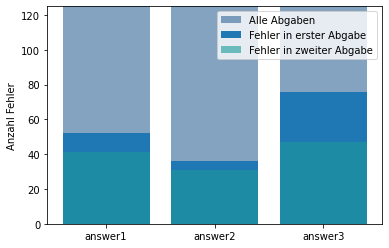

In 82.39999999999999% der Fälle wurde bei der ersten Abgabe ein Fehler gemacht
--------------------------------------------------

AI-3-v2-1-2
Welche der Aussagen über KI-Anwendungen stimmen?

* 1. Empfehlungssysteme gehören zur spezifischen KI
* 2. Eine KI aus einem Film, die eigenständige Entscheidungen trifft, mit Menschen spricht und sich am Ende gegen sie wendet, gehört zur allgemeinen KI
* 3. Programme zur Bilderkennung gehören zur allgemeinen KI


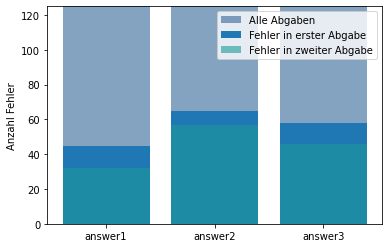

In 70.39999999999999% der Fälle wurde bei der ersten Abgabe ein Fehler gemacht
--------------------------------------------------

AI-4-v2-1-1
Was bedeuten diese Unterscheidung zwischen spezifischer und allgemeiner KI jetzt für die Intelligenz von KI-Anwendungen?

* 1. Intelligentes Verhalten in einem spezifischen Bereich muss nicht gleich allgemeine Intelligenz bedeuten
* 2. KI-Anwendungen sind allgemein intelligent
* 3. Eine KI, die sich in einem einzigen Bereich so intelligent verhält wie ein Mensch, muss allgemeine Intelligenz besitzen
* 4. KI-Anwendungen zeigen intelligentes Verhalten in einem kleinen Bereich


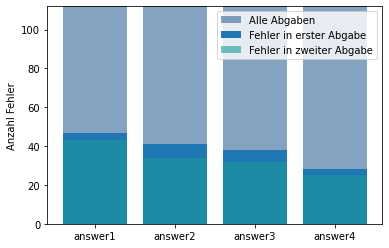

In 67.85714285714286% der Fälle wurde bei der ersten Abgabe ein Fehler gemacht
--------------------------------------------------

AI-4-v2-1-2
Lass uns noch einmal das Wichtigste wiederholen! Welche dieser Aussagen stimmen?

* 1. Heutige KI-Anwendungen gehören alle zur spezifischen KI
* 2. Eine KI, die in allen Bereichen so schlau ist wie ein Mensch, gibt es noch nicht
* 3. Spezifische KI umfasst Anwendungen, die menschenähnliche Intelligenz in einem kleinen Bereich zeigen
* 4. KI-Anwendungen lernen durch Erfahrung
* 5. Intelligentes Verhalten setzt allgemeine Intelligenz voraus
* 6. Ein Spam-Filter ist eine allgemeinen KI
* 7. KI-Anwendungen treffen eigenständige Entscheidungen


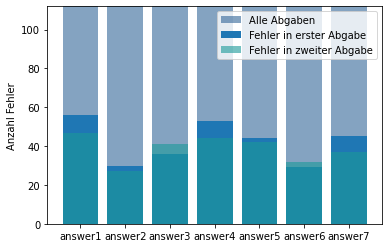

In 86.60714285714286% der Fälle wurde bei der ersten Abgabe ein Fehler gemacht
--------------------------------------------------

ML-2-1-3
Lass uns das Wichtigste nochmal wiederholen:

* 1. Die Daten, die wir für das Training benutzen, heißen Trainingsdaten
* 2. Für das Training nutzen wir Daten ohne Label
* 3. Unser Ziel ist es, einen Algorithmus zu trainieren, der für neue Bilder das richtige Label vorhersagen kann. Also zu sagen, ob ein Bild einen Hund oder eine Katze zeigt
* 4. Nach dem Training testen wir nochmal auf ein paar neuen Daten, wie gut die Vorhersagen des Algorithmus sind


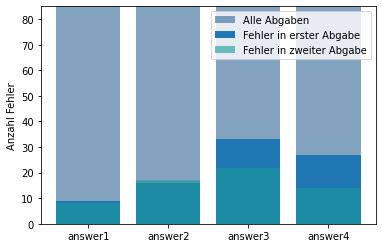

In 60.0% der Fälle wurde bei der ersten Abgabe ein Fehler gemacht
--------------------------------------------------

ML-3-1-1
Welche Aussagen stimmen?

* 1. Das überwachte und das unüberwachte Lernen unterscheiden sich zum Beispiel daran, dass wir einmal Daten mit und einmal Daten ohne Label nutzen
* 2. Beim unüberwachten Lernen wollen wir lernen, für neue Daten das richtige Label vorherzusagen
* 3. Maschinelles Lernen ist ein Teilbereich der KI
* 4. Das maschinelle Lernen beschäftigt sich mit Programmen, die selbständig in großen Datenmengen Gesetzmäßigkeiten erkennen können


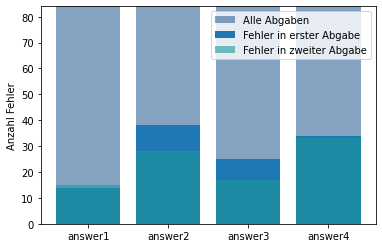

In 75.0% der Fälle wurde bei der ersten Abgabe ein Fehler gemacht
--------------------------------------------------

ML-3-1-2
Ein Empfehlungssystem für Musik, das lernt, was du für Musik magst und dann für neu erscheinende Musik voraussagt, ob du sie mögen würdest.

* 1. Unüberwachtes Lernen
* 2. Überwachtes Lernen


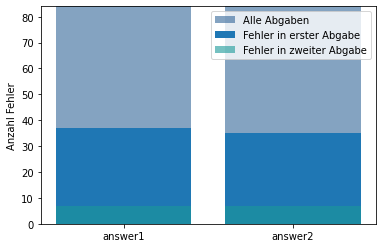

In 44.047619047619044% der Fälle wurde bei der ersten Abgabe ein Fehler gemacht
--------------------------------------------------

ML-3-1-3
Die Gesichtserkennung von deinem Handy. Anfangs musst du dein Gesicht aus verschiedenen Winkeln filmen. Anhand dieser Beispiele lernt es, dein Gesicht zu erkennen. Wenn dann irgendein Gesicht versucht, dein Handy zu entsperren, kann es voraussagen, ob es dein Gesicht ist oder nicht.

* 1. Unüberwachtes Lernen
* 2. Überwachtes Lernen


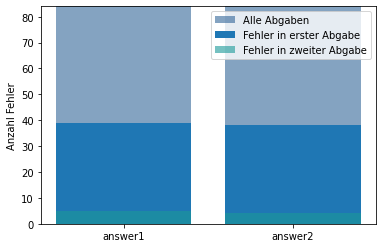

In 46.42857142857143% der Fälle wurde bei der ersten Abgabe ein Fehler gemacht
--------------------------------------------------

ML-3-1-4
Wenn wir Youtuber nach der Anzahl ihrer Follower und der Themen ihrer Videos gruppieren.

* 1. Unüberwachtes Lernen
* 2. Überwachtes Lernen


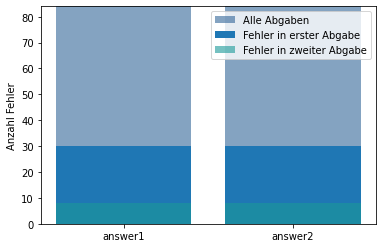

In 35.714285714285715% der Fälle wurde bei der ersten Abgabe ein Fehler gemacht
--------------------------------------------------

Clustering-1-1-1
Was war unüberwachtes Lernen noch gleich?

* 1. Beim unüberwachten Lernen geht es darum, Struktur in den Daten zu finden
* 2. Beim unüberwachten Lernen wollen wir die richtigen Label für neue Daten vorhersagen
* 3. Beim unüberwachten Lernen hat man keine Label für die Daten
* 4. Beim unüberwachten Lernen nutzt man Daten mit Label


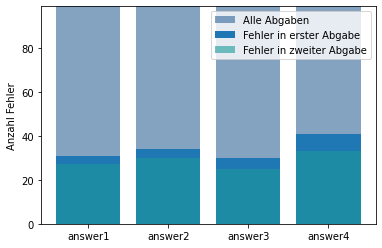

In 72.72727272727273% der Fälle wurde bei der ersten Abgabe ein Fehler gemacht
--------------------------------------------------

Clustering-1-1-2
Welche Aussagen über die anderen beiden Cluster stimmen?

* 1. Die Youtuber im blauen Cluster laden öfter Videos hoch
* 2. Die Youtuber im roten Cluster laden öfter Videos hoch


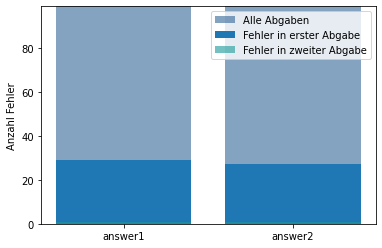

In 29.292929292929294% der Fälle wurde bei der ersten Abgabe ein Fehler gemacht
--------------------------------------------------

Classification-1-1-1
Welche Aussagen stimmen?

* 1. Einen Algorithmus zu trainieren, der Bildern mit Hunden das Label “Hund” gibt, wäre ein Fall für überwachtes Lernen
* 2. Beim überwachten Lernen versucht man Struktur in Daten zu finden
* 3. Beim überwachten Lernen braucht man Daten ohne Label


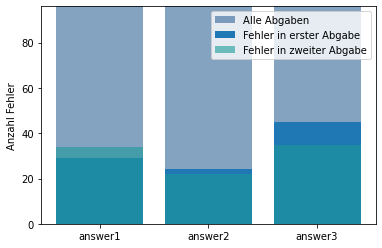

In 68.75% der Fälle wurde bei der ersten Abgabe ein Fehler gemacht
--------------------------------------------------

Classification-2-1-6
Wer hat den ähnlichsten Filmgeschmack zu Alex?

* 1. Josi
* 2. Mahmud
* 3. Isa
* 4. Paul
* 5. Anna


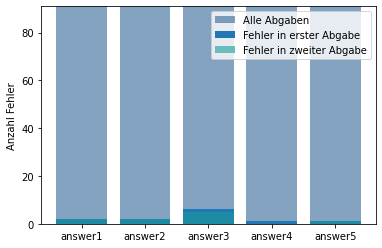

In 6.593406593406594% der Fälle wurde bei der ersten Abgabe ein Fehler gemacht
--------------------------------------------------

Classification-2-1-7
Welchen Film kannst du Alex guten Gewissens empfehlen?

* 1. James Bond
* 2. Fluch der Karibik
* 3. Herr der Ringe
* 4. Hangover
* 5. Avengers Endgame


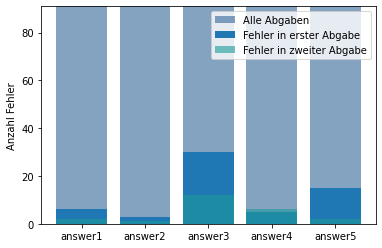

In 32.967032967032964% der Fälle wurde bei der ersten Abgabe ein Fehler gemacht
--------------------------------------------------

Classification-2-1-8
Welche Aussagen stimmen?

* 1. Ein Algorithmus, der dir basierend auf deinen Lieblingsfächern einen Beruf vorschlägt, könnte man mittels überwachtem Lernen umsetzen
* 2. Ein Algorithmus, der ähnliche Berufe gruppiert, gehört zum überwachten Lernen
* 3. Ein Algorithmus, der anhand vieler alter Fälle gelernt hat, medizinische Diagnosen zu stellen, gehört zum überwachten Lernen


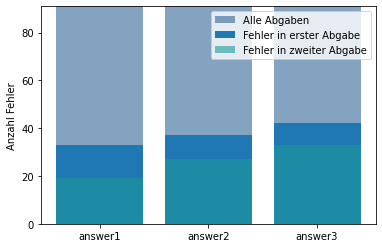

In 68.13186813186813% der Fälle wurde bei der ersten Abgabe ein Fehler gemacht
--------------------------------------------------

LimitsML-1-1
Was könnte passieren, wenn wir bei den Hundebildern nur Bilder von einer Hunderasse nutzen würden?

* 1. Der Algorithmus würde nur Hunde dieser Rasse zuverlässig als Hunde erkennen
* 2. Der Algorithmus würde immer noch alle Hunderassen als Hunde erkennen, weil es keine Katzen sind
* 3. Bei Hunden anderer Rassen ist es schwer zu sagen, ob er sie erkennen würde, aber sehr wahrscheinlich nicht so zuverlässig


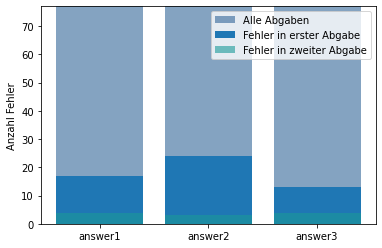

In 51.94805194805194% der Fälle wurde bei der ersten Abgabe ein Fehler gemacht
--------------------------------------------------

EvalML-1-3
Welche der Aussagen stimmen?

* 1. Eine fertige KI-Anwendung kann nicht ohne Hilfe von einem Menschen funktionieren
* 2. Derzeit gibt es sowohl Anwendungen, die zur spezifischen, als auch welche, die zur allgemeinen KI gehören
* 3. KI kann irgendwann alles besser als der Mensch
* 4. Jeder Mensch wird zukünftig eine Vielzahl verschiedener KIs in seinem Alltag nutzen
* 5. Jede KI hat allgemeine Intelligenz. Damit ist jede KI eine allgemeine KI
* 6. Ein Programm, dass so gut Schach spielen kann, wie Menschen, ist ein Beispiel für eine spezifische KI
* 7. Eine fertige KI-Anwendung kann nicht mit Erfahrung lernen, sie bleibt, wie sie ist
* 8. KI-Anwendungen zeichnen sich dadurch aus, dass sie intelligentes Verhalten zeigen, autonom funktionieren und mit Erfahrung lernen
* 9. Eine spezifische KI zeigt intelligentes Verhalten in einem kleinen Bereich


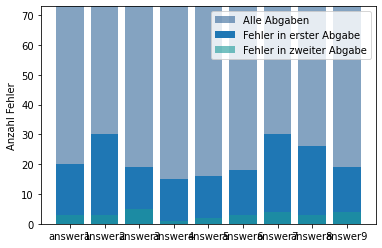

In 89.04109589041096% der Fälle wurde bei der ersten Abgabe ein Fehler gemacht
--------------------------------------------------

EvalML-1-4
Welche der folgenden Anwendungen enthalten KI-Methoden?

* 1. Ein personalisiertes Empfehlungssystem für Musik
* 2. Das Sortieren von Bildern nach Datum
* 3. Eine Nachrichtenseite, die jedem Nutzer den gleichen Inhalt präsentiert
* 4. Die Erkennung von Gegenständen auf Bildern


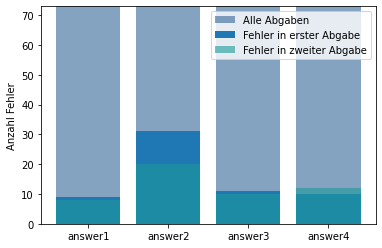

In 56.16438356164384% der Fälle wurde bei der ersten Abgabe ein Fehler gemacht
--------------------------------------------------

EvalML-1-8
Welche der Aussagen über maschinelles Lernen stimmen?

* 1. Beim überwachten Lernen nutzen wir Daten ohne Label
* 2. Clustering ist ein Beispiel für unüberwachtes Lernen
* 3. Wenn wir für Daten Label vorhersagen wollen, betreiben wir überwachtes Lernen
* 4. Beim unüberwachten Lernen versuchen wir, Strukturen in den Daten zu entdecken
* 5. Algorithmen des maschinellen Lernens können aus vorhandenen Daten selbständig lernen
* 6. Algorithmen des maschinellen Lernens benötigen oft große Mengen an Daten, damit sie gute Ergebnisse erzielen
* 7. Algorithmen des maschinellen Lernens lernen nur, was in den Daten vorhanden ist. Daher ist die Auswahl an Trainingsdaten sehr wichtig
* 8. Wenn wir für Daten Label vorhersagen wollen, betreiben wir Clustering


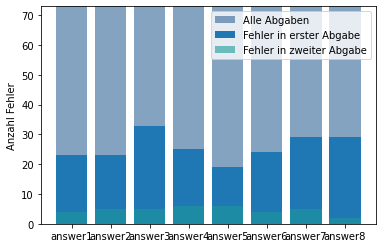

In 76.71232876712328% der Fälle wurde bei der ersten Abgabe ein Fehler gemacht
--------------------------------------------------

EvalML-1-9
Welche Art des Lernens sind folgende Aufgaben?

* 1. Eine Webseite, die für neue Rezepte vorhersagt, ob sie dir “gefallen” oder “nicht gefallen”, ist eine Aufgabe für das überwachte Lernen
* 2. Eine Webseite, die ähnliche Rezepte gruppiert, wäre eine Aufgabe für das Clustering


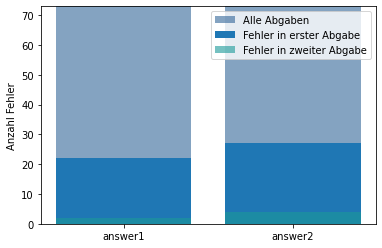

In 60.273972602739725% der Fälle wurde bei der ersten Abgabe ein Fehler gemacht
--------------------------------------------------

Impact-3-1-2
Welche Jobs sind also bedroht?

* 1. Pflegepersonal
* 2. Angestellte im Kundenservice
* 3. Angestellte bei einer Bank oder Versicherung
* 4. Wissenschaftler
* 5. LKW- und Taxifahrer
* 6. Lehrer


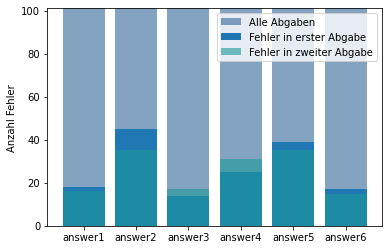

In 79.20792079207921% der Fälle wurde bei der ersten Abgabe ein Fehler gemacht
--------------------------------------------------

Impact-1-1-1
Was glaubst du, warum das Gesicht der dunkelhäutigen Frau nicht erkannt wurde?

* 1. Die Trainingsdaten, mit denen der Algorithmus gelernt hat, enthielten keine oder kaum Bilder von dunkelhäutigen Menschen
* 2. Der Algorithmus wurde falsch programmiert


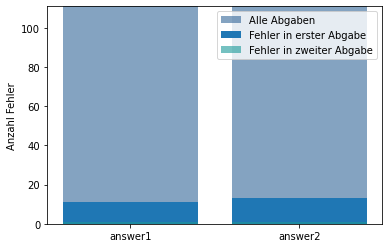

In 11.711711711711711% der Fälle wurde bei der ersten Abgabe ein Fehler gemacht
--------------------------------------------------

Impact-4-1-1
Was sind möglichen Folgen vom Einsatz von KI in der Medizin?

* 1. KI kann helfen, die richtigen Behandlungen zu empfehlen
* 2. KI kann die medizinische Versorgung günstiger machen
* 3. KI-Methoden können immer die richtige Diagnose stellen
* 4. KI kann die Erkennung von Tumoren auf Scans verbessern
* 5. KI kann helfen, bessere Diagnosen zu stellen
* 6. KI-Methoden werden Ärzte komplett ersetzen
* 7. KI kann helfen, die Behandlungen besser an jeden einzelnen Patienten anzupassen


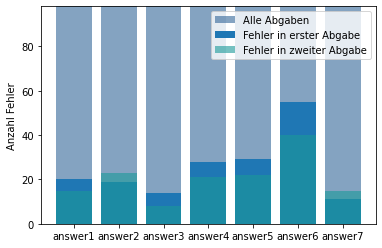

In 83.6734693877551% der Fälle wurde bei der ersten Abgabe ein Fehler gemacht
--------------------------------------------------



In [14]:
for taskId in multipleChoice["taskId"].unique():
    print(taskId)
    task_i = multipleChoice[multipleChoice["taskId"] == taskId]
    sampleSolution_i = list(task_i["sampleSolution"][0:1])[0]
    print(task_i["question"].unique()[0])
    print("")

    answers = []
    for answer in task_i["answers"]:
        for answeritem in answer:
            answers.append(answeritem["de"])
    answers_i = list(set(answers))
    for i in range(len(answers_i)):
        print("* " + str(i+1) + ". " + answers_i[i])

    with_false_attempts = task_i[task_i["falseAttempts"] == task_i["falseAttempts"]]
    without_false_attempts = task_i[task_i["falseAttempts"] != task_i["falseAttempts"]]
    first_falseAttempts_i = [elem[0] for elem in with_false_attempts["falseAttempts"]]
    # für alle false attempts: [ item for elem in with_false_attempts["falseAttempts"] for item in elem]
    second_falseAttempts_i = [elem[1] if len(elem) >1 else [] for elem in with_false_attempts["falseAttempts"]]
    
    nr_all_tasks = np.array([len(task_i) for answer in sampleSolution_i])
    nr_errors_in_first_false_attempt = np.array([0 for answer in sampleSolution_i])
    nr_errors_in_second_false_attempt = np.array([0 for answer in sampleSolution_i])
    for falseAttempt in first_falseAttempts_i:
        nr_errors_in_first_false_attempt += np.array([a != f for a,f in zip(sampleSolution_i,falseAttempt)]).astype(int)
    
    for falseAttempt in second_falseAttempts_i:
        if(len(falseAttempt)>=1):
            nr_errors_in_second_false_attempt += np.array([a != f for a,f in zip(sampleSolution_i,falseAttempt)]).astype(int)
    
    labels = ["answer" + str(i) for i in range(1, len(sampleSolution_i)+1)]
    plt.bar(labels, nr_all_tasks, color=(0.2, 0.4, 0.6, 0.6)) #0.1, 0.1, 0.1, 0.1 #0.2, 0.4, 0.6, 0.6
    plt.bar(labels, nr_errors_in_first_false_attempt)
    plt.bar(labels, nr_errors_in_second_false_attempt, color=(0.1, 0.6, 0.6, 0.6))
    plt.legend(["Alle Abgaben", "Fehler in erster Abgabe", "Fehler in zweiter Abgabe"])
    plt.ylim([0, len(task_i)])
    plt.ylabel("Anzahl Fehler")
    plt.show()
    
    print("In " + str((len(first_falseAttempts_i)/len(task_i))*100) + "% der Fälle wurde bei der ersten Abgabe ein Fehler gemacht")
    #print("so oft wurde die aufgabe gemacht: " + str(len(task_i)))
    #print("so oft wurde beim ersten abgeben etwas falsch gemacht: " + str(len(first_falseAttempts_i)))
    print("--------------------------------------------------")
    print("")

## Freitext

### Duations

<AxesSubplot:ylabel='taskId'>

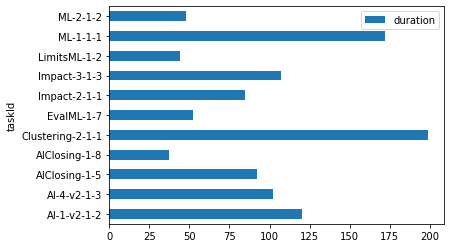

In [17]:
freetext.groupby("taskId").agg(np.median)[["duration"]].plot(kind="barh")

<AxesSubplot:>

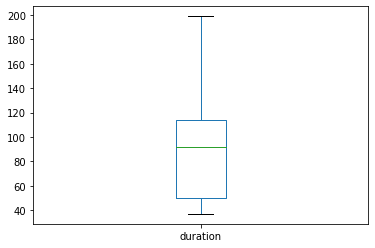

In [18]:
freetext.groupby("taskId").agg(np.median)[["duration"]].plot(kind="box")

keine Aufgabe ist formal gesehen ein ausreißer bei der Länge

Gibt es Ballungen bei Aufgaben oder SuS?

In [5]:
# bei welchen aufgaben brauchen besonders viele SuS sehr lange (sind über dem 95. duration perzentil) 
freetext[freetext["duration"] > np.percentile(freetext["duration"], 95)][["taskId"]].value_counts()

taskId          
AI-1-v2-1-2         15
ML-1-1-1            13
Clustering-2-1-1    11
AI-4-v2-1-3          9
Impact-3-1-3         3
ML-2-1-2             2
AIClosing-1-5        1
dtype: int64

In [6]:
# welche SuS brauchen besonders oft sehr lange (sind öfters über dem 95. duration perzentil) 
freetext[freetext["duration"] > np.percentile(freetext["duration"], 95)][["pupilId"]].value_counts()

pupilId          
6bBwnX2mwAp2NAwNR    4
dotjrftFetJme4iPH    4
TLqNCrX4jaYixjtv7    3
hn2oJ5p2CwPfG44wx    3
iFu7aGDqSfNbSFvoL    2
Absyuhryq96KZL2Cs    2
C2BW6tdii778v4RfL    2
Decqz7SuZcHMFsSAn    2
XKrLvRHLaM7yDisR6    2
hnSuDAuJxnggYbASM    2
zBgRiFyXPXhDqsqwb    2
j3AkifkKRR3t3NeoT    2
kdqG4fXAK64zdrqN8    2
29Lq4fguqCLhap77S    2
dfgu3qQKvYzZf7T3v    1
Z9DkQMmtiPiHtteME    1
3GGQqRsPRZK2LXnnC    1
3hiSwDCiw9HeyHg7f    1
sfmw8KQLy8LGdYmYq    1
7eqvpzMXwFGaYWHou    1
8jxQibGAdG7f9fjZj    1
rsATbrReo6odn6oXD    1
Ay6mfswm3SFcQdNJg    1
BHDJ6HWSM5MZo6YSJ    1
rdey75egbdBviYKD6    1
oX6Z8YXDvABBdmAfm    1
kNif57ypHXceM33Yk    1
MRSj5LqwWj6WSoj4E    1
PWuKnsCopAGh2sBNd    1
Pg7BFWmCtMbhidD3w    1
R8CkqGDeQXZmHxTuk    1
tFtNEGEvAWMPxNKri    1
n9zGaAFZH5uiAEoTH    1
Kd6FuRsrq6QvPrkKp    1
dtype: int64

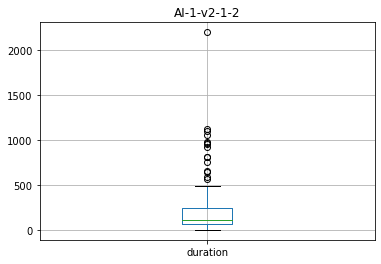

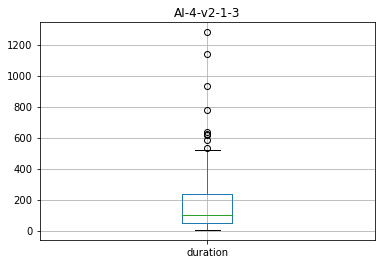

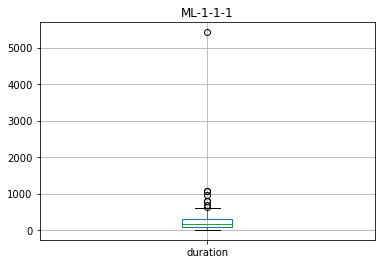

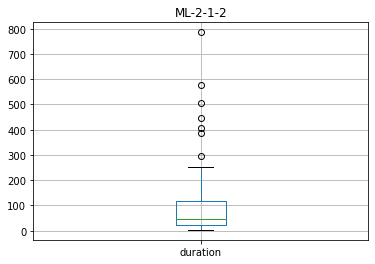

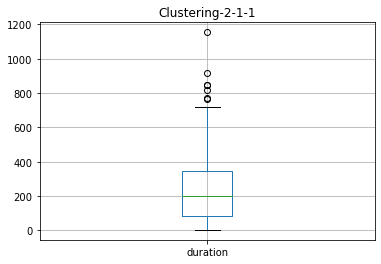

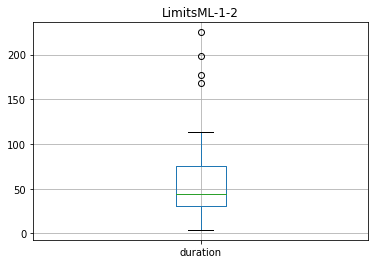

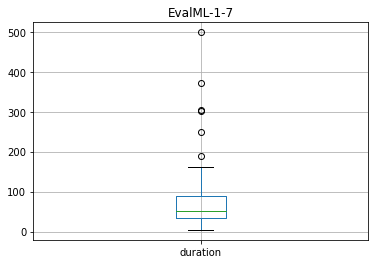

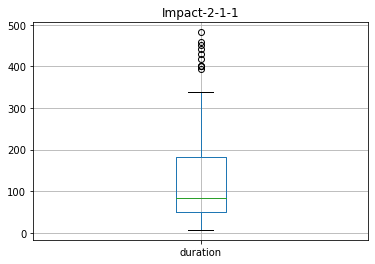

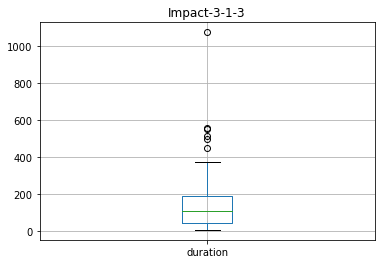

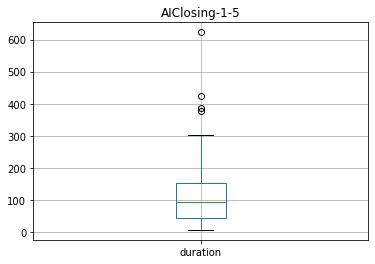

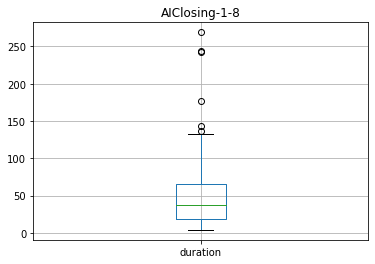

In [23]:
for taskid in freetext["taskId"].unique():
    task_i = freetext[freetext["taskId"] == taskid]
    task_i.boxplot(column=['duration'])
    plt.title(str(taskid))
    plt.show()

### Länge der Abgaben

median length of freetext antwort: 14.0
mean length of freetext antwort: 20.739776951672862
std of length of freetext antwort: 23.17456659256489
50% are between 6.0 and 28.0 words long
min number of words: 0.0
max number of words: 379.0
Das sind nur die Längen der akzeptierten Antworten


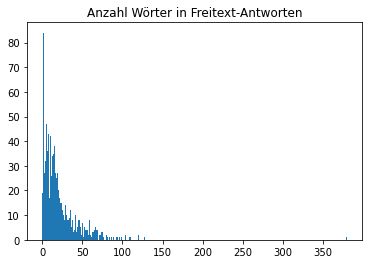

/Users/jean-philipp/Documents/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


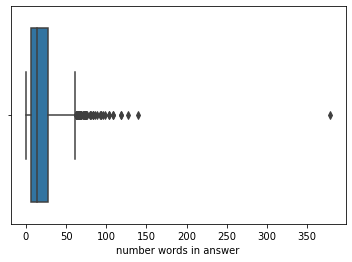

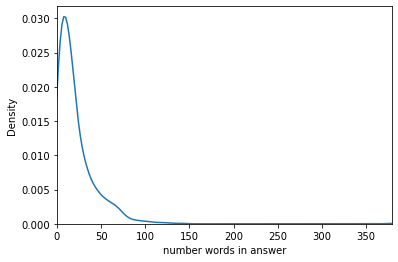

In [25]:
print("median length of freetext antwort: " + str(np.median(freetext["number words in answer"])))
print("mean length of freetext antwort: " + str(np.mean(freetext["number words in answer"])))
print("std of length of freetext antwort: " + str(np.std(freetext["number words in answer"])))

q75, q25 = np.percentile(freetext["number words in answer"], [75 ,25])
print("50% are between " + str(q25) + " and " + str(q75) + " words long")

print("min number of words: " + str(np.min(freetext["number words in answer"])))
print("max number of words: " + str(np.max(freetext["number words in answer"])))
print("Das sind nur die Längen der akzeptierten Antworten")

plt.hist(freetext["number words in answer"], bins=int(np.max(list(freetext["number words in answer"]))))
plt.title("Anzahl Wörter in Freitext-Antworten")
plt.show()

sns.boxplot(freetext["number words in answer"])
plt.show()

kde_length = sns.kdeplot(freetext["number words in answer"])
kde_length.set_xlim(left=0, right=np.max(freetext["number words in answer"]))
#kde_length.set_ylim(bottom=0, top=200);
plt.show()

In [31]:
print(str(freetext[freetext["number words in answer"]>300][["state", "taskId", "pupilId"]]))

                                                  state      taskId  \
6068  <strong>Maschinelles Lernen</strong>&nbsp;ist ...  EvalML-1-7   

                pupilId  
6068  dyTS8nrtbSffwByhm  


In [34]:
len(freetext)

1076

In [41]:

freetext[(freetext["pupilId"]=="NY9MuhKgmbJLGHcbz") & (freetext["taskId"] == "AI-1-v2-1-2")]

pupilId            classId       taskId taskSeriesId  \
5692  NY9MuhKgmbJLGHcbz  3dLAJPXXug3EMqbc5  AI-1-v2-1-2      AI-1-v2   

      duration        state evaluation         falseAttempts teacherFeedback  \
5692       104  keine anung      false  [<p>keine anung</p>]                   

     revision helpRequested   subType  \
5692     True           NaN  freetext   

                                               question  \
5692  Was ist deiner Meinung nach Künstliche Intelli...   

                                         sampleSolution  \
5692  Die Schülerinnen und Schüler (SuS) sollen besc...   

      number words in answer  numberHints  rating_content  rating_format  \
5692                     2.0          NaN             5.0            5.0   

      rating_creativity  
5692                0.0

### Kurze Antworten, die noch akzeptiert wurden

In [26]:
#was sind die kurzen antworten, die akzeptiert wurden?
freetext[(freetext["number words in answer"]<5) & (freetext["taskId"] != "AIClosing-1-8") & (freetext["taskId"] != "ML-2-1-2")& (freetext["taskId"] != "AI-1-v2-1-2")][["pupilId", "classId", "taskId", "state", "question"]]

pupilId            classId         taskId  \
254   gooproPtWeTH6dtcB  qFEyvypMn4sAwLwtc   Impact-2-1-1   
1000  jEu6xtqA4gGjdgqgm  GkQSJvPTRWsLnpyR9    AI-4-v2-1-3   
1003  jEu6xtqA4gGjdgqgm  GkQSJvPTRWsLnpyR9       ML-1-1-1   
1034  jEu6xtqA4gGjdgqgm  GkQSJvPTRWsLnpyR9  AIClosing-1-5   
1046  iHYe2TGnR9zgGZ6zh  GkQSJvPTRWsLnpyR9    AI-4-v2-1-3   
...                 ...                ...            ...   
6144  8SdsXqZ4kXoh2mEts  brSDebuCak3FfQsg6  AIClosing-1-5   
6162  Wt2cDGMkbhtxYj8ot  brSDebuCak3FfQsg6   LimitsML-1-2   
6188  Wt2cDGMkbhtxYj8ot  brSDebuCak3FfQsg6  AIClosing-1-5   
6332  hEJx5G9X7gSRJSL4y  brSDebuCak3FfQsg6     EvalML-1-7   
6351  hEJx5G9X7gSRJSL4y  brSDebuCak3FfQsg6  AIClosing-1-5   

                                 state  \
254          das Gesicht ist unscharf    
1000  kl heißt künstliche intelligenz    
1003                                 .   
1034                             .<br>   
1046                            ja<br>   
...                                ...   
6144                       Keine Sorge   
6162                               Ja    
6188                  Du wirst sterben   
6332                                KI   
6351                     schwierig<br>   

                                               question  
254   Was für Probleme könnten durch den Einsatz von...  
1000  Jetzt weißt du schon mehr über KI. Sag nochmal...  
1003  Kannst du einen Algorithmus schreiben, der Hun...  
1034  Du siehst also, dass die Erwartungen der Mensc...  
1046  Jetzt weißt du schon mehr über KI. Sag nochmal...  
...                                                 ...  
6144  Du siehst also, dass die Erwartungen der Mensc...  
6162  Was würde passieren, wenn wir alle Bilder von ...  
6188  Du siehst also, dass die Erwartungen der Mensc...  
6332  Beschreib noch einmal in eigenen Worten, was m...  
6351  Du siehst also, dass die Erwartungen der Mensc...  

[120 rows x 5 columns]

Erst noch die Antworten auf Fragen rausnehmen, zu denen SuS noch nichts wissen müssen.
Scheinen wenige SuS zu sein, von denen die Antworten trotzdem akzeptiert wurden.

vllt musste ein account hochgespielt werden

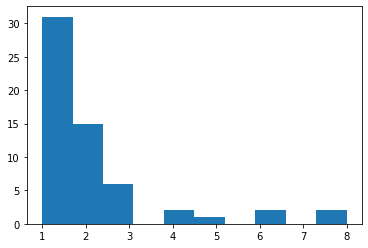

In [28]:
plt.hist(freetext[(freetext["number words in answer"]<5) & (freetext["taskId"] != "AIClosing-1-8")& (freetext["taskId"] != "ML-2-1-2")& (freetext["taskId"] != "AI-1-v2-1-2")]["pupilId"].value_counts())
plt.show()

In [29]:
# kleiner als IQR25
freetext[(freetext["number words in answer"]<9) & (freetext["taskId"] != "AIClosing-1-8")& (freetext["taskId"] != "ML-2-1-2")& (freetext["taskId"] != "AI-1-v2-1-2")][["pupilId", "classId", "taskId", "state", "question"]]

pupilId            classId            taskId  \
188   jRT6yzZ2ip5ab5ZFM  qFEyvypMn4sAwLwtc      Impact-2-1-1   
234   gooproPtWeTH6dtcB  qFEyvypMn4sAwLwtc  Clustering-2-1-1   
244   gooproPtWeTH6dtcB  qFEyvypMn4sAwLwtc      LimitsML-1-2   
251   gooproPtWeTH6dtcB  qFEyvypMn4sAwLwtc        EvalML-1-7   
254   gooproPtWeTH6dtcB  qFEyvypMn4sAwLwtc      Impact-2-1-1   
...                 ...                ...               ...   
6332  hEJx5G9X7gSRJSL4y  brSDebuCak3FfQsg6        EvalML-1-7   
6351  hEJx5G9X7gSRJSL4y  brSDebuCak3FfQsg6     AIClosing-1-5   
6375  SxzRMptJmyZPpiHxb  brSDebuCak3FfQsg6      LimitsML-1-2   
6382  SxzRMptJmyZPpiHxb  brSDebuCak3FfQsg6        EvalML-1-7   
6401  SxzRMptJmyZPpiHxb  brSDebuCak3FfQsg6     AIClosing-1-5   

                                                  state  \
188               Man könnte damit verbrechen fälschen    
234      <span style="color: rgb(51, 51, 51);">⠀</span>   
244      <span style="color: rgb(51, 51, 51);">⠀</span>   
251   <span style="color: rgb(51, 51, 51);">⠀</span>...   
254                           das Gesicht ist unscharf    
...                                                 ...   
6332                                                 KI   
6351                                      schwierig<br>   
6375  Das Programm würde alle Seehunde als Hunde erk...   
6382  Maschinelles Lernen, ist lernen was Maschinenb...   
6401          Benutzt du Alexa, da hast du die Antwort.   

                                               question  
188   Was für Probleme könnten durch den Einsatz von...  
234   Schau dir die Mittelpunkte der Cluster genau a...  
244   Was würde passieren, wenn wir alle Bilder von ...  
251   Beschreib noch einmal in eigenen Worten, was m...  
254   Was für Probleme könnten durch den Einsatz von...  
...                                                 ...  
6332  Beschreib noch einmal in eigenen Worten, was m...  
6351  Du siehst also, dass die Erwartungen der Mensc...  
6375  Was würde passieren, wenn wir alle Bilder von ...  
6382  Beschreib noch einmal in eigenen Worten, was m...  
6401  Du siehst also, dass die Erwartungen der Mensc...  

[231 rows x 5 columns]

<AxesSubplot:>

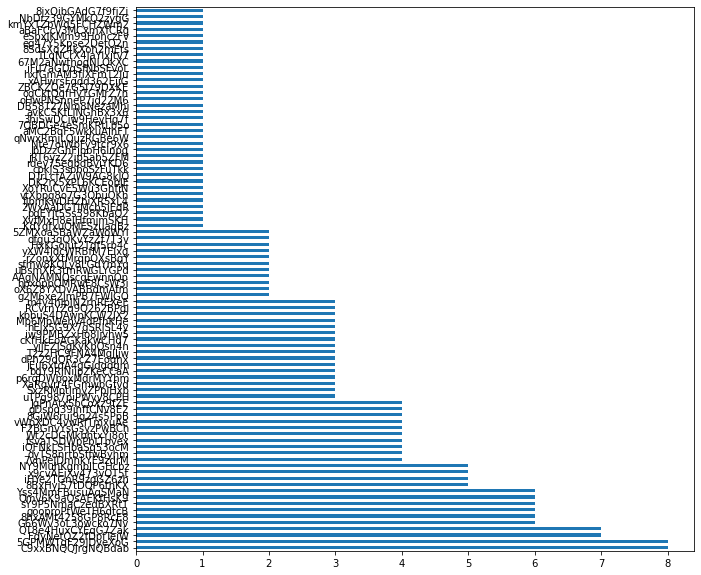

In [30]:
freetext[(freetext["number words in answer"]<9) & (freetext["taskId"] != "AIClosing-1-8")& (freetext["taskId"] != "ML-2-1-2")& (freetext["taskId"] != "AI-1-v2-1-2")]["pupilId"].value_counts().plot(kind='barh', figsize=(10,10))

### Welche Antworten wurden nicht akzeptiert?

In [35]:
print(len(freetext[(freetext["evaluation"] == "false")]))
print(len(freetext[(freetext["evaluation"] == "correct")]))

64
712


Lehrkräfte geben kaum Aufgaben zurück

### Wurden Antworten mehrfach zurück gegeben?

(array([54.,  0.,  7.,  0.,  2.,  0.,  0.,  0.,  0.,  1.]),
 array([1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. , 5.5, 6. ]),
 <BarContainer object of 10 artists>)

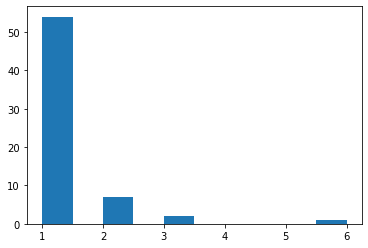

In [36]:
number_revisions = []

for i, task in freetext[freetext["evaluation"] == "false"].iterrows():
    number_revisions.append(len(task["falseAttempts"]))
    #print(len(task["falseAttempts"]))
    #if(len(task["falseAttempts"])>5):
    #    print(task["falseAttempts"])
    
plt.hist(number_revisions)

### Teacher Feedback

In [37]:
freetext["teacherFeedback"].value_counts()

                                                                                              719
Du brauchst die Antworten nicht neu abgeben, wenn du nichts änderst.                            5
0 Punkte                                                                                        3
Nein, es ist ewas anderes gemeint.                                                              1
Sehr allgemein formuliert :)                                                                    1
                                                                                             ... 
Du brauchst die Antworten nicht neu abgeben, nur wenn du etwas geändert hast                    1
ja oder den Seehund als Hund erkennen.                                                          1
Nicht nur für Menschen mit Behinderung. Gibt ja auch Alexa u.ä.\n                               1
Als Fernziel gut beschrieben, geht aber noch nicht auf das ein, was wir heute schon nutzen      1
der wedelnde Schwanz

### Ratings

content


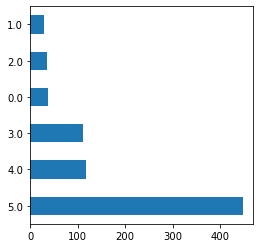

5.0    447
4.0    117
3.0    111
0.0     38
2.0     35
1.0     28
Name: rating_content, dtype: int64
format


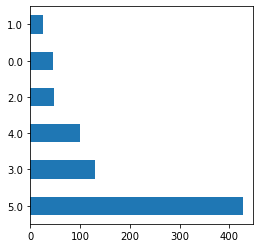

5.0    427
3.0    130
4.0    100
2.0     48
0.0     45
1.0     26
Name: rating_format, dtype: int64
creativity


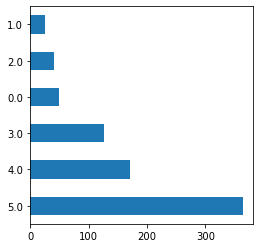

5.0    364
4.0    171
3.0    126
0.0     50
2.0     40
1.0     25
Name: rating_creativity, dtype: int64


In [51]:
#.plot(kind='barh', figsize=(10,10))

print("content")
freetext["rating_content"].value_counts().plot(kind='barh', figsize=(4,4))
plt.show()
print(freetext["rating_content"].value_counts())
print("format")
freetext["rating_format"].value_counts().plot(kind='barh', figsize=(4,4))
plt.show()
print(freetext["rating_format"].value_counts())
print("creativity")
freetext["rating_creativity"].value_counts().plot(kind='barh', figsize=(4,4))
plt.show()
print(freetext["rating_creativity"].value_counts())

IQR75 Content Rating: 5.0
Median Content Rating: 5.0
IQR25 Content Rating: 3.0
Mean Content Rating: 4.038659793814433
Std Content Rating: 1.4164170922101649

IQR75 format Rating: 5.0
Median format Rating: 5.0
IQR25 format Rating: 3.0
Mean format Rating: 3.926546391752577
Std format Rating: 1.4795919019450705

IQR75 creativity Rating: 5.0
Median creativity Rating: 4.0
IQR25 creativity Rating: 3.0
Mean creativity Rating: 3.8492268041237114
Std creativity Rating: 1.4614282733149804



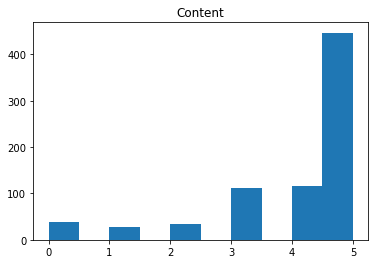

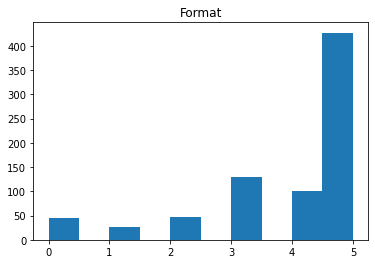

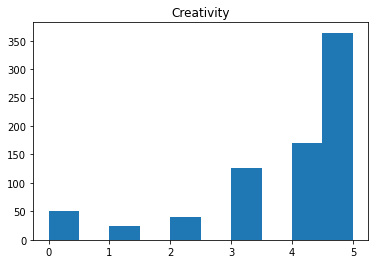

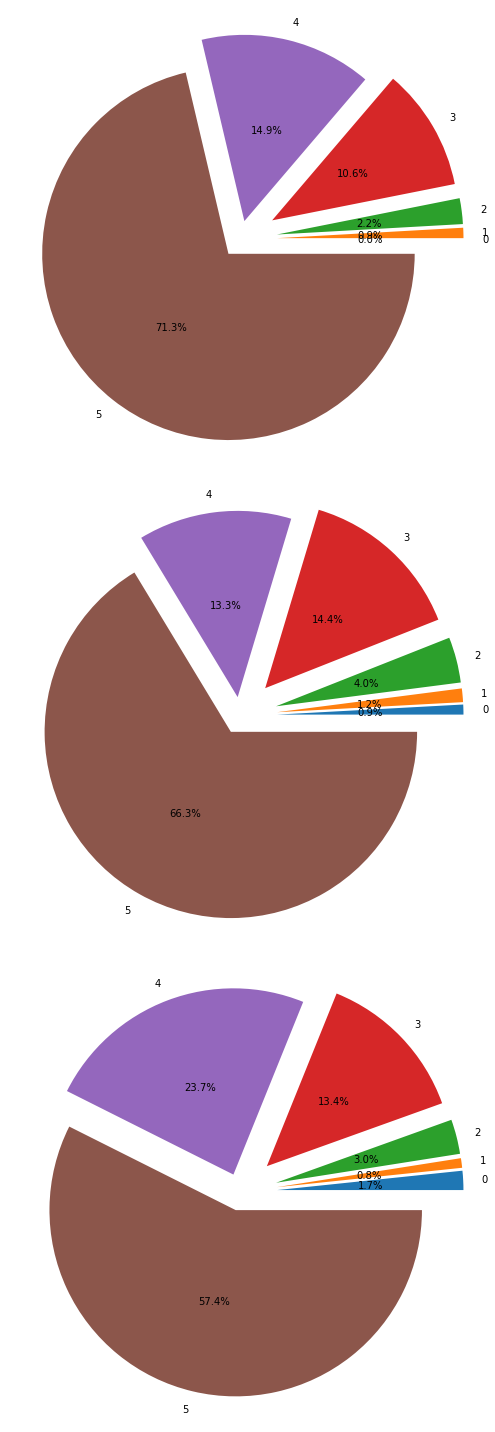

In [54]:
print("IQR75 Content Rating: " + str(np.percentile(freetext[freetext["evaluation"] != "pending"]["rating_content"], 75)))
print("Median Content Rating: " + str(np.nanmedian(freetext["rating_content"])))
print("IQR25 Content Rating: " + str(np.percentile(freetext[freetext["evaluation"] != "pending"]["rating_content"], 25)))
print("Mean Content Rating: " + str(np.mean(freetext["rating_content"])))
print("Std Content Rating: " + str(np.std(freetext["rating_content"])))
print("")

print("IQR75 format Rating: " + str(np.percentile(freetext[freetext["evaluation"] != "pending"]["rating_format"], 75)))
print("Median format Rating: " + str(np.nanmedian(freetext["rating_format"])))
print("IQR25 format Rating: " + str(np.percentile(freetext[freetext["evaluation"] != "pending"]["rating_format"], 25)))
print("Mean format Rating: " + str(np.mean(freetext["rating_format"])))
print("Std format Rating: " + str(np.std(freetext["rating_format"])))
print("")

print("IQR75 creativity Rating: " + str(np.percentile(freetext[freetext["evaluation"] != "pending"]["rating_creativity"], 75)))
print("Median creativity Rating: " + str(np.nanmedian(freetext["rating_creativity"])))
print("IQR25 creativity Rating: " + str(np.percentile(freetext[freetext["evaluation"] != "pending"]["rating_creativity"], 25)))
print("Mean creativity Rating: " + str(np.mean(freetext["rating_creativity"])))
print("Std creativity Rating: " + str(np.std(freetext["rating_creativity"])))
print("")
# TODO: der median muss hier noch falsch sein, der ist 4.0, obwohl es 5 sind


plt.hist(freetext["rating_content"])
plt.title("Content")
plt.show()
plt.hist(freetext["rating_format"])
plt.title("Format")
plt.show()
plt.hist(freetext["rating_creativity"])
plt.title("Creativity")
plt.show()


#boxplots bringen eig nichts!
#sns.boxplot(freetext[freetext["evaluation"] != "pending"]["rating_content"])
#plt.show()
#sns.boxplot(freetext[freetext["evaluation"] != "pending"]["rating_format"])
#plt.show()
#sns.boxplot(freetext[freetext["evaluation"] != "pending"]["rating_creativity"])
#plt.show()


# Pie charts
content_data = freetext[freetext["evaluation"] != "pending"].groupby("rating_content")["rating_content"].sum()
format_data = freetext[freetext["evaluation"] != "pending"].groupby("rating_format")["rating_content"].sum()
creativity_data = freetext[freetext["evaluation"] != "pending"].groupby("rating_creativity")["rating_content"].sum()
labels = ["0", "1", "2", "3", "4", "5"]
#content_labels = freetext[freetext["evaluation"] != "pending"]["rating_content"].unique()

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=[10,20])

ax1.pie(x=content_data, autopct="%.1f%%", explode = (0.2, 0.2, 0.2, 0.2, 0.1, 0.1), labels=labels, pctdistance=0.5)
ax2.pie(x=format_data, autopct="%.1f%%", explode = (0.2, 0.2, 0.2, 0.2, 0.1, 0.1), labels=labels, pctdistance=0.5)
ax3.pie(x=creativity_data, autopct="%.1f%%", explode = (0.2, 0.2, 0.2, 0.2, 0.1, 0.1), labels=labels, pctdistance=0.5)
plt.tight_layout()
plt.show()

#### Welche Antworten haben besonders lange gebraucht?

In [38]:
# Welche Antworten haben besonders lange gebraucht?
freetext[freetext["duration"] > 700][["pupilId", "classId", "taskId", "duration", "state", "number words in answer"]]

pupilId            classId            taskId  duration  \
67    Z9DkQMmtiPiHtteME  qFEyvypMn4sAwLwtc       AI-1-v2-1-2       920   
137   Kd6FuRsrq6QvPrkKp  qFEyvypMn4sAwLwtc       AI-1-v2-1-2       979   
511   7eqvpzMXwFGaYWHou  qFEyvypMn4sAwLwtc       AI-1-v2-1-2       958   
522   dotjrftFetJme4iPH  qFEyvypMn4sAwLwtc       AI-1-v2-1-2      1063   
547   dotjrftFetJme4iPH  qFEyvypMn4sAwLwtc  Clustering-2-1-1      1154   
557   TLqNCrX4jaYixjtv7  qFEyvypMn4sAwLwtc       AI-1-v2-1-2      1125   
564   TLqNCrX4jaYixjtv7  qFEyvypMn4sAwLwtc       AI-4-v2-1-3       778   
603   hn2oJ5p2CwPfG44wx  qFEyvypMn4sAwLwtc       AI-1-v2-1-2       818   
618   hn2oJ5p2CwPfG44wx  qFEyvypMn4sAwLwtc          ML-2-1-2       786   
628   hn2oJ5p2CwPfG44wx  qFEyvypMn4sAwLwtc  Clustering-2-1-1       770   
657   kdqG4fXAK64zdrqN8  qFEyvypMn4sAwLwtc       AI-1-v2-1-2      1100   
718   Absyuhryq96KZL2Cs  qFEyvypMn4sAwLwtc       AI-4-v2-1-3      1280   
721   Absyuhryq96KZL2Cs  qFEyvypMn4sAwLwtc          ML-1-1-1      1060   
753   XKrLvRHLaM7yDisR6  qFEyvypMn4sAwLwtc       AI-1-v2-1-2       811   
763   XKrLvRHLaM7yDisR6  qFEyvypMn4sAwLwtc          ML-1-1-1       793   
783   C2BW6tdii778v4RfL  qFEyvypMn4sAwLwtc       AI-4-v2-1-3      1141   
786   C2BW6tdii778v4RfL  qFEyvypMn4sAwLwtc          ML-1-1-1      1060   
895   6bBwnX2mwAp2NAwNR  qFEyvypMn4sAwLwtc       AI-1-v2-1-2       968   
902   6bBwnX2mwAp2NAwNR  qFEyvypMn4sAwLwtc       AI-4-v2-1-3       932   
920   6bBwnX2mwAp2NAwNR  qFEyvypMn4sAwLwtc  Clustering-2-1-1       845   
1670  Decqz7SuZcHMFsSAn  hZ9Hi9DLZSm5JMbNm       AI-1-v2-1-2       760   
1712  tFtNEGEvAWMPxNKri  hZ9Hi9DLZSm5JMbNm       AI-1-v2-1-2      2197   
1952  iFu7aGDqSfNbSFvoL  NCm8NNbAmNsur5S33          ML-1-1-1       786   
2265  rdey75egbdBviYKD6  NCm8NNbAmNsur5S33  Clustering-2-1-1       820   
2554  zBgRiFyXPXhDqsqwb  NCm8NNbAmNsur5S33          ML-1-1-1       972   
2712  n9zGaAFZH5uiAEoTH  hZ9Hi9DLZSm5JMbNm          ML-1-1-1      5419   
2940  sfmw8KQLy8LGdYmYq  NCm8NNbAmNsur5S33      Impact-3-1-3      1076   
3306  hnSuDAuJxnggYbASM  Fj6vLBZ78KswTxcPt  Clustering-2-1-1       720   
5125  oX6Z8YXDvABBdmAfm  3dLAJPXXug3EMqbc5  Clustering-2-1-1       849   
5567  dfgu3qQKvYzZf7T3v  3dLAJPXXug3EMqbc5  Clustering-2-1-1       767   
6424  3GGQqRsPRZK2LXnnC  brSDebuCak3FfQsg6  Clustering-2-1-1       914   

                                                  state  \
67    <span style="background-color: rgb(248, 246, 2...   
137   Künstliche Intelligenz heißt, dass ein Roboter...   
511   <span style="background-color: rgb(232, 234, 2...   
522   Meiner Meinung nach, künstliche Intelligenz is...   
547   Die Clusternummer 1 wäre für die Make-Up-Marke...   
557   Künstliche Intelligenz ist wenn Programme durc...   
564   Es gibt spezifische KI und die Vorstellung von...   
603   Bei Künstlichen Intelligenzen wird durch das D...   
618   Maschinelles Lernen wird auch "deep learning" ...   
628   Das Beauty, Vlogs repräsentiert am ehesten ein...   
657   Künstliche Intelligenz sorgt für die Digitalis...   
718   - KI wird inn der Zukunft in autos sein<ul><li...   
721   <h3>-“Es ist ein Hund, wenn es vier Pfoten hat...   
753   Künstliche Intelligenz (KI) ist ein weitreiche...   
763   <pre class="ql-syntax" spellcheck="false">Es i...   
783   <span style="color: rgb(32, 33, 36);">Die KI i...   
786   es ist ein Hund, wenn es  4 Pfoten hat. es ist...   
895   Künstliche Intelligenz bedeutet, dass ein Robo...   
902   KI (Künstliche Intelligenz) unterscheidet man ...   
920   Das 1. Cluster repräsentiert am Besten eine Ma...   
1670  Bisher weiß ich, dass künstliche Intelligenzen...   
1712  Künstliche Intilligenz bedeutet, dass Maschine...   
1952                                               Fell   
2265  Ich denke Cluster 1 repräsentiert am Besten ei...   
2554  Es ist ein Hund wenn er zwei Augen und ein Mun...   
2712  Es ist ein Hund : \twenn es Fell hat \twenn es...   
2940             die menschliche arbeit verbessert sic

In [59]:
# sind die langsamen schüler auch die, die nicht weit gekommen sind?
slow_freetext_pupils = freetext[freetext["duration"] > 700]["pupilId"].unique()

pupil_performance_df[pupil_performance_df.index.isin(slow_freetext_pupils)]

nr_tasks_per_pupil  total_duration in minutes  \
pupilId                                                            
Z9DkQMmtiPiHtteME                   4                  25.950000   
Kd6FuRsrq6QvPrkKp                   6                  37.383333   
7eqvpzMXwFGaYWHou                  11                  43.800000   
dotjrftFetJme4iPH                  35                 117.250000   
TLqNCrX4jaYixjtv7                  46                 124.000000   
hn2oJ5p2CwPfG44wx                  54                 123.000000   
kdqG4fXAK64zdrqN8                  54                 122.783333   
Absyuhryq96KZL2Cs                  15                  63.150000   
XKrLvRHLaM7yDisR6                  23                  91.550000   
C2BW6tdii778v4RfL                  35                  84.816667   
6bBwnX2mwAp2NAwNR                  35                 114.550000   
Decqz7SuZcHMFsSAn                  42                  73.716667   
tFtNEGEvAWMPxNKri                   3                  56.350000   
iFu7aGDqSfNbSFvoL                  54                 116.916667   
rdey75egbdBviYKD6                  66                 100.916667   
zBgRiFyXPXhDqsqwb                  66                 178.483333   
n9zGaAFZH5uiAEoTH                  42                1395.083333   
sfmw8KQLy8LGdYmYq                  31                  71.133333   
hnSuDAuJxnggYbASM                  66                 102.233333   
oX6Z8YXDvABBdmAfm                  35                  38.100000   
dfgu3qQKvYzZf7T3v                  55                  37.700000   
3GGQqRsPRZK2LXnnC                  13                  21.550000   

                   average duration per task in minutes  AI-1-v2-1-1  \
pupilId                                                                
Z9DkQMmtiPiHtteME                              6.487500         43.0   
Kd6FuRsrq6QvPrkKp                              6.230556         78.0   
7eqvpzMXwFGaYWHou                              3.981818         69.0   
dotjrftFetJme4iPH                              3.350000         76.0   
TLqNCrX4jaYixjtv7                              2.695652         51.0   
hn2oJ5p2CwPfG44wx                              2.277778         71.0   
kdqG4fXAK64zdrqN8                              2.273765         51.0   
Absyuhryq96KZL2Cs                              4.210000         89.0   
XKrLvRHLaM7yDisR6                              3.980435        100.0   
C2BW6tdii778v4RfL                              2.423333         48.0   
6bBwnX2mwAp2NAwNR                              3.272857         77.0   
Decqz7SuZcHMFsSAn                              1.755159         52.0   
tFtNEGEvAWMPxNKri                             18.783333         87.0   
iFu7aGDqSfNbSFvoL                              2.165123         20.0   
rdey75egbdBviYKD6                              1.529040         46.0   
zBgRiFyXPXhDqsqwb                              2.704293          1.0   
n9zGaAFZH5uiAEoTH                             33.216270         74.0   
sfmw8KQLy8LGdYmYq                              2.294624         52.0   
hnSuDAuJxnggYbASM                              1.548990        100.0   
oX6Z8YXDvABBdmAfm                              1.088571          NaN   
dfgu3qQKvYzZf7T3v                              0.685455        100.0   
3GGQqRsPRZK2LXnnC                              1.657692          NaN   

                   AI-4-v2-1-4  EvalML-1-1  ML-2-1-1  EvalML-1-5  AI-4-v2-1-5  \
pupilId                                                                         
Z9DkQMmtiPiHtteME          NaN         NaN       NaN         NaN          NaN   
Kd6FuRsrq6QvPrkKp          NaN         NaN       NaN         NaN          NaN   
7eqvpzMXwFGaYWHou         53.0         NaN       NaN         NaN         43.0   
dotjrftFetJme4iPH         49.0         NaN      54.0         NaN         88.0   
TLqNCrX4jaYixjtv7         61.0        66.0      53.0        75.0        100.0   
hn2oJ5p2CwPfG44wx         99.0        79.0      77.0       100.0        100.0   
kdqG4fXAK

### Korrelationen

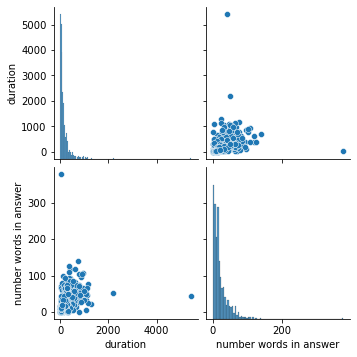

In [60]:
sns.pairplot(freetext[["duration", 'number words in answer']])

In [61]:
# correlation mit kategorischen daten für ["duration", 'number words in answer', "rating_content", 'rating_format', 'rating_creativity']
rho1, p1 = scipy.stats.spearmanr(freetext[freetext["evaluation"] != "pending"]['duration'], freetext[freetext["evaluation"] != "pending"]['rating_content'])
rho2, p2 = scipy.stats.spearmanr(freetext[freetext["evaluation"] != "pending"]['duration'], freetext[freetext["evaluation"] != "pending"]['rating_format'])
rho3, p3 = scipy.stats.spearmanr(freetext[freetext["evaluation"] != "pending"]['duration'], freetext[freetext["evaluation"] != "pending"]['rating_creativity'])
rho4, p4 = scipy.stats.spearmanr(freetext[freetext["evaluation"] != "pending"]['number words in answer'], freetext[freetext["evaluation"] != "pending"]['rating_content'])
rho5, p5 = scipy.stats.spearmanr(freetext[freetext["evaluation"] != "pending"]['number words in answer'], freetext[freetext["evaluation"] != "pending"]['rating_format'])
rho6, p6 = scipy.stats.spearmanr(freetext[freetext["evaluation"] != "pending"]['number words in answer'], freetext[freetext["evaluation"] != "pending"]['rating_creativity'])

print("spearman coeff duration+content: " + str(rho1) + " p-value: " + str(p1))
print("spearman coeff duration+format: " + str(rho2) + " p-value: " + str(p2))
print("spearman coeff duration+creativity: " + str(rho3) + " p-value: " + str(p3))
print("spearman coeff answerlength+content: " + str(rho4) + " p-value: " + str(p4))
print("spearman coeff answerlength+format: " + str(rho5) + " p-value: " + str(p5))
print("spearman coeff answerlength+creativity: " + str(rho6) + " p-value: " + str(p6))

#unter 0.05 ist signifikant
# für coefficients nochmal nachschauen, ab wann wie stark

spearman coeff duration+content: 0.14299658916976743 p-value: 6.39977752291694e-05
spearman coeff duration+format: 0.21884997514677554 p-value: 7.207291153240434e-10
spearman coeff duration+creativity: 0.1515283330874791 p-value: 2.2473218737866514e-05
spearman coeff answerlength+content: 0.18043391434827355 p-value: 4.197199094494226e-07
spearman coeff answerlength+format: 0.21606971037226652 p-value: 1.1922695494625929e-09
spearman coeff answerlength+creativity: 0.1622257468317255 p-value: 5.574417589003719e-06


In [62]:
rho7, p7 = scipy.stats.spearmanr(freetext[freetext["evaluation"] != "pending"]['rating_content'], freetext[freetext["evaluation"] != "pending"]['rating_format'])
rho8, p8 = scipy.stats.spearmanr(freetext[freetext["evaluation"] != "pending"]['rating_content'], freetext[freetext["evaluation"] != "pending"]['rating_creativity'])
rho9, p9 = scipy.stats.spearmanr(freetext[freetext["evaluation"] != "pending"]['rating_format'], freetext[freetext["evaluation"] != "pending"]['rating_creativity'])

print("spearman coeff content+format: " + str(rho7) + " p-value: " + str(p7))
print("spearman coeff content+creat: " + str(rho8) + " p-value: " + str(p8))
print("spearman coeff format+creat: " + str(rho9) + " p-value: " + str(p9))

spearman coeff content+format: 0.7943208024160042 p-value: 1.0498208974944576e-169
spearman coeff content+creat: 0.8036703207302276 p-value: 1.1760641973214571e-176
spearman coeff format+creat: 0.8328421798428062 p-value: 5.200614894080213e-201


In [64]:
freetext[["duration", 'number words in answer', "rating_content", 'rating_format', 'rating_creativity']].corr()

duration  number words in answer  rating_content  \
duration                1.000000                0.400572        0.115512   
number words in answer  0.400572                1.000000        0.231713   
rating_content          0.115512                0.231713        1.000000   
rating_format           0.142027                0.238346        0.856067   
rating_creativity       0.139137                0.231135        0.857568   

                        rating_format  rating_creativity  
duration                     0.142027           0.139137  
number words in answer       0.238346           0.231135  
rating_content               0.856067           0.857568  
rating_format                1.000000           0.897761  
rating_creativity            0.897761           1.000000

<AxesSubplot:>

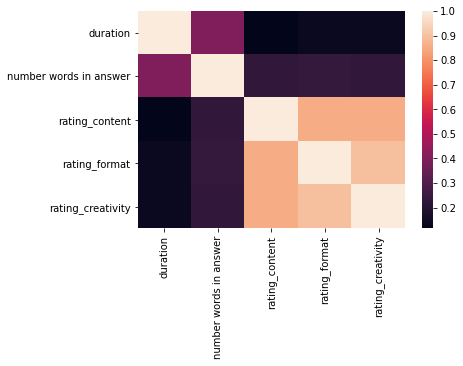

In [65]:
sns.heatmap(freetext[["duration", 'number words in answer', "rating_content", 'rating_format', 'rating_creativity']].corr())

# Wie weit sind die SuS im Paket gekommen

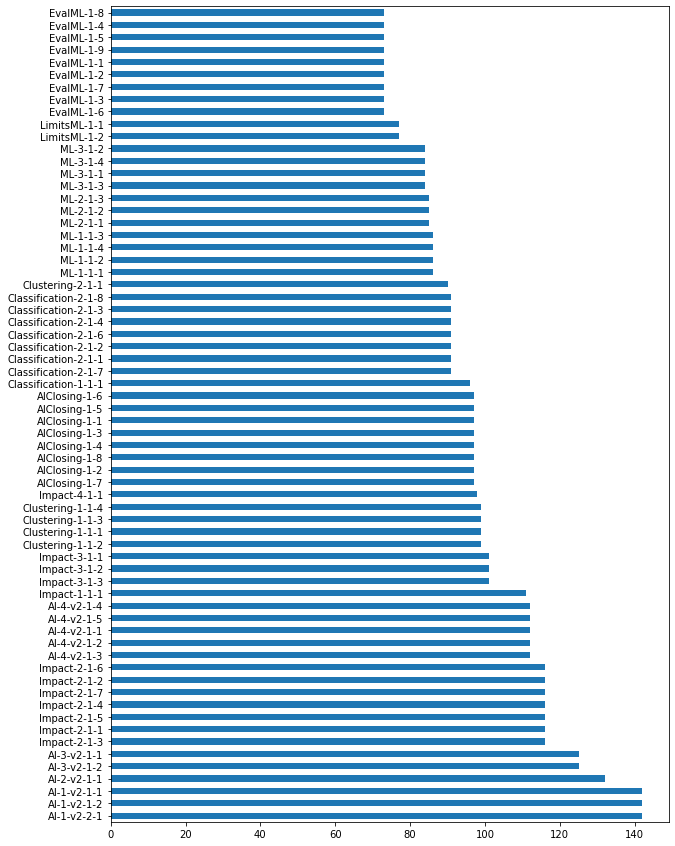

In [5]:
# Wie viele SuS haben die jeweilige Aufgabe gelöst?
df["taskId"].value_counts().plot(kind='barh', figsize=(10,15))
plt.show()

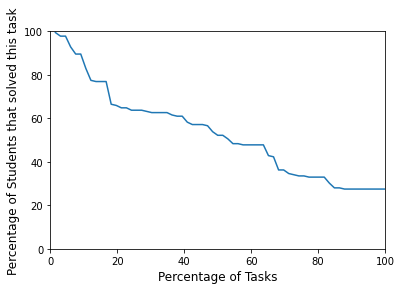

In [85]:
nr_all_tasks = len(df["taskId"].unique())

sorted_nr_tasks_per_pupil = np.sort(pupil_performance_df["nr_tasks_per_pupil"])

# Number of students with number of tasks
number_pupils_with_this_number_of_tasks = []
for i in range(nr_all_tasks):
    at_least_this_number = 0
    for number in sorted_nr_tasks_per_pupil:
        if number >= i+1:
            at_least_this_number += 1
    number_pupils_with_this_number_of_tasks.append(at_least_this_number) #anzahl zahlen mit mehr

# percentage of students with each percentage of tasks
task_percentage = [i * (100/nr_all_tasks) for i in range(1,nr_all_tasks+1)]
pupil_percentages = [i * (100/len(df["pupilId"].unique())) for i in number_pupils_with_this_number_of_tasks]


# PLOTTING
#fig, (ax1, ax2) = plt.subplots(nrows=2,ncols=1,figsize=(10,20))

#ax1 = plt.subplot(211)
#ax1.plot(range(1,nr_all_tasks+1), number_pupils_with_this_number_of_tasks)
#ax1.set_xlabel( "Numbers of Tasks" , size = 12 )
#ax1.set_ylabel( "Numbers of Students that solved this task" , size = 12 )
#ax1.set_xlim([0, nr_all_tasks])
#ax1.set_ylim([0, len(sorted_nr_tasks_per_pupil)])

#ax2 = plt.subplot(212)
ax2 = plt.subplot(111)
ax2.plot(task_percentage, pupil_percentages)
ax2.set_xlabel( "Percentage of Tasks" , size = 12 )
ax2.set_ylabel( "Percentage of Students that solved this task" , size = 12 )
ax2.set_xlim([0, 100])
ax2.set_ylim([0, 100])

plt.show()

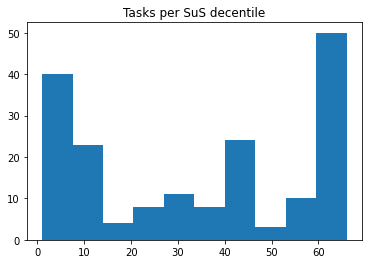

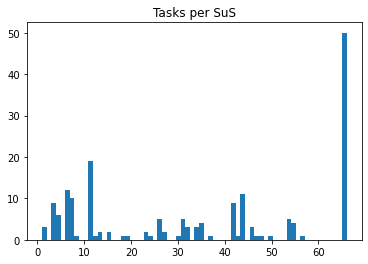

In [82]:
# anzahl tasks per pupil
#plt.hist(pupil_performance_df["nr_tasks_per_pupil"], bins=4)
#plt.title("Tasks per SuS quartiles")
#plt.show()

plt.hist(pupil_performance_df["nr_tasks_per_pupil"], bins=10)
plt.title("Tasks per SuS decentile")
plt.show()

plt.hist(pupil_performance_df["nr_tasks_per_pupil"], bins=np.max(pupil_performance_df["nr_tasks_per_pupil"]))
plt.title("Tasks per SuS")
plt.show()

# Durations

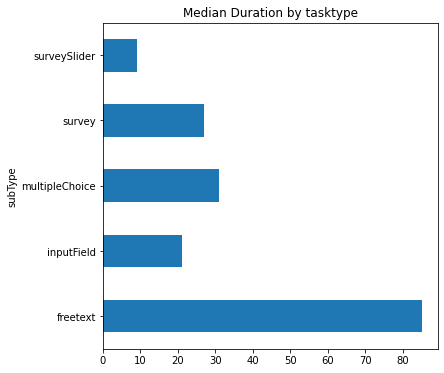

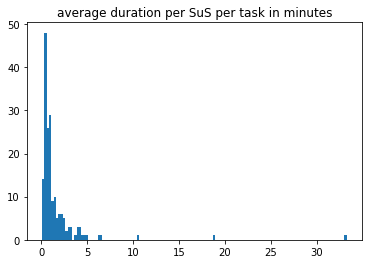

In [72]:
# All durations
#df.boxplot(column=['duration'])
#plt.title("all durations")
#plt.show()

# Per Subtype
#df.groupby("subType")["duration"].mean().plot(kind='barh', figsize=(6,6))
#plt.title("Mean Duration by tasktype")
#plt.show()

df.groupby("subType")["duration"].median().plot(kind='barh', figsize=(6,6))
plt.title("Median Duration by tasktype")
plt.show()

# Per Student
plt.hist(pupil_performance_df["average duration per task in minutes"], bins=int(np.max(pupil_performance_df["average duration per task in minutes"])/0.25))
plt.title("average duration per SuS per task in minutes")
plt.show()

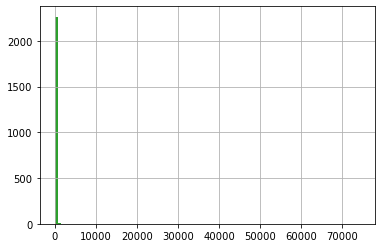

In [73]:
df.groupby("subType")["duration"].hist(bins=100)
plt.show()
# TODO: vllt als 3d histogram? https://matplotlib.org/stable/gallery/mplot3d/hist3d.html

#for subType in df.groupby("subType"):
    #print(subType["duration"])
    #subType["duration"].hist()
    #plt.show()
    
#groupby("taskId")
#groupby("pupilId")

# Hints taken

In [79]:
nr_no_hints = 0
nr_one_hint = 0
nr_two_hints = 0
nr_tasks_with_hints = len(df[df["hints"] == df["hints"]])

for index, task in df[df["hints"] == df["hints"]].iterrows():
    if task["hintsTaken"] ==1:
        nr_one_hint +=1
    elif task["hintsTaken"] ==2:
        nr_two_hints +=1
    else:
        nr_no_hints +=1

print("von " + str(nr_tasks_with_hints) + " gemachten aufgaben wurde:")
print(str(nr_no_hints) + " kein hint angefragt. In Prozent: " + str((nr_no_hints/nr_tasks_with_hints)*100))
print(str(nr_one_hint) + " ein hint angefragt. In Prozent: " + str((nr_one_hint/nr_tasks_with_hints)*100))
print(str(nr_two_hints) + " zwei hints angefragt. In Prozent: " + str((nr_two_hints/nr_tasks_with_hints)*100))


von 1713 gemachten aufgaben wurde:
536 kein hint angefragt. In Prozent: 31.290134267367193
1113 ein hint angefragt. In Prozent: 64.97373029772329
64 zwei hints angefragt. In Prozent: 3.7361354349095155


In [80]:
# nach aufgabentyp?!

nr_no_hints_mc = 0
nr_one_hint_mc = 0
nr_two_hints_mc = 0
nr_tasks_with_hints_mc = len(df[(df["hints"] == df["hints"]) & (df["subType"] == "multipleChoice")])

for index, task in df[(df["hints"] == df["hints"]) & (df["subType"] == "multipleChoice")].iterrows():
    if task["hintsTaken"] ==1:
        nr_one_hint_mc +=1
    elif task["hintsTaken"] ==2:
        nr_two_hints_mc +=1
    else:
        nr_no_hints_mc +=1

print("von " + str(nr_tasks_with_hints_mc) + " gemachten MC aufgaben wurde:")
print(str(nr_no_hints_mc) + " kein hint angefragt. In Prozent: " + str((nr_no_hints_mc/nr_tasks_with_hints_mc)*100))
print(str(nr_one_hint_mc) + " ein hint angefragt. In Prozent: " + str((nr_one_hint_mc/nr_tasks_with_hints_mc)*100))
print(str(nr_two_hints_mc) + " kein hint angefragt. In Prozent: " + str((nr_two_hints_mc/nr_tasks_with_hints_mc)*100))


von 1515 gemachten MC aufgaben wurde:
462 kein hint angefragt. In Prozent: 30.495049504950494
989 ein hint angefragt. In Prozent: 65.28052805280528
64 kein hint angefragt. In Prozent: 4.224422442244224


#### werden hints direkt genommen oder erst versucht, die aufgaben zu lösen?

In [81]:
hints_directly_taken = 0
hints_not_directly_taken = 0

for index, task in df[df["hints"] == df["hints"]].iterrows():
    #hints taken = 1 und len(falseattempts) = 0
    # hints taken >=1 und false attempts >= 0
    
    if((task["hintsTaken"] == task["hintsTaken"]) & (task["falseAttempts"]!=task["falseAttempts"])):
        hints_directly_taken += 1
    elif((task["hintsTaken"] == task["hintsTaken"]) & (task["falseAttempts"]==task["falseAttempts"])):
        hints_not_directly_taken +=1
            
print("in so vielen fällen wurde ein hint angefragt, ohne es vorher versucht zu haben: " + str(hints_directly_taken))
print("in so vielen fällen wurde entweder der hint erst nach einem falschen versuch angefragt oder direkt angefragt ohne zu helfen: " + str(hints_not_directly_taken))

in so vielen fällen wurde ein hint angefragt, ohne es vorher versucht zu haben: 52
in so vielen fällen wurde entweder der hint erst nach einem falschen versuch angefragt oder direkt angefragt ohne zu helfen: 1125


In [83]:
# Das sind die Fälle, bei denen direkt ein hint angefragt wurde:
df[(df["hintsTaken"] == df["hintsTaken"]) & (df["falseAttempts"]!=df["falseAttempts"])]

pupilId            classId                taskId  \
139   Kd6FuRsrq6QvPrkKp  qFEyvypMn4sAwLwtc           AI-2-v2-1-1   
140   Kd6FuRsrq6QvPrkKp  qFEyvypMn4sAwLwtc           AI-3-v2-1-1   
350   ZTvPk2i77LDC8pFmu  qFEyvypMn4sAwLwtc           AI-4-v2-1-1   
368   ZTvPk2i77LDC8pFmu  qFEyvypMn4sAwLwtc      Clustering-1-1-3   
444   bniRycMi5bwrXjvGy  qFEyvypMn4sAwLwtc  Classification-2-1-8   
513   7eqvpzMXwFGaYWHou  qFEyvypMn4sAwLwtc           AI-2-v2-1-1   
559   TLqNCrX4jaYixjtv7  qFEyvypMn4sAwLwtc           AI-2-v2-1-1   
560   TLqNCrX4jaYixjtv7  qFEyvypMn4sAwLwtc           AI-3-v2-1-1   
606   hn2oJ5p2CwPfG44wx  qFEyvypMn4sAwLwtc           AI-3-v2-1-1   
607   hn2oJ5p2CwPfG44wx  qFEyvypMn4sAwLwtc           AI-3-v2-1-2   
608   hn2oJ5p2CwPfG44wx  qFEyvypMn4sAwLwtc           AI-4-v2-1-1   
627   hn2oJ5p2CwPfG44wx  qFEyvypMn4sAwLwtc      Clustering-1-1-4   
642   hn2oJ5p2CwPfG44wx  qFEyvypMn4sAwLwtc            EvalML-1-4   
898   6bBwnX2mwAp2NAwNR  qFEyvypMn4sAwLwtc           AI-3-v2-1-1   
900   6bBwnX2mwAp2NAwNR  qFEyvypMn4sAwLwtc           AI-4-v2-1-1   
918   6bBwnX2mwAp2NAwNR  qFEyvypMn4sAwLwtc      Clustering-1-1-3   
933   aiaYpPdYWJKb2hs7J  qFEyvypMn4sAwLwtc           AI-3-v2-1-1   
934   aiaYpPdYWJKb2hs7J  qFEyvypMn4sAwLwtc           AI-3-v2-1-2   
946   aiaYpPdYWJKb2hs7J  qFEyvypMn4sAwLwtc              ML-2-1-3   
1174  hovj8Sfjv8G9Q2YxH  GkQSJvPTRWsLnpyR9           AI-3-v2-1-1   
1642  N62PxuFACsR6DuvBc  hZ9Hi9DLZSm5JMbNm           AI-3-v2-1-1   
1881  X3JDYSzxpuDpoRjdJ  NCm8NNbAmNsur5S33           AI-4-v2-1-1   
2190  x9cvAEjXv473yQT5t  NCm8NNbAmNsur5S33              ML-2-1-3   
2272  rdey75egbdBviYKD6  NCm8NNbAmNsur5S33  Classification-2-1-7   
2446  8BxHyj57tDQP6thKX  NCm8NNbAmNsur5S33              ML-3-1-1   
3040  yXW4JdcWRBfM7Eixg  2xefmoTfmYkhhAZYp          Impact-3-1-2   
3153  Fkzmz9rTdkQXSmE2E  Rv7Wf522ZgQhs5LdX           AI-2-v2-1-1   
3171  HicSWk5kkvcAz4H8w  Rv7Wf522ZgQhs5LdX           AI-2-v2-1-1   
3199  Q9a6JY4zvQQ9qA2Ms  Rv7Wf522ZgQhs5LdX           AI-3-v2-1-2   
3207  mYtL2SNZ77fdTf8ps  Rv7Wf522ZgQhs5LdX           AI-3-v2-1-1   
3208  mYtL2SNZ77fdTf8ps  Rv7Wf522ZgQhs5LdX           AI-3-v2-1-2   
3209  mYtL2SNZ77fdTf8ps  Rv7Wf522ZgQhs5LdX           AI-4-v2-1-1   
3443  Mp6MpWeny4dPfhKHe  Fj6vLBZ78KswTxcPt              ML-3-1-1   
3452  Mp6MpWeny4dPfhKHe  Fj6vLBZ78KswTxcPt  Classification-1-1-1   
3509  FefCz3MmxDeohgDKC  Fj6vLBZ78KswTxcPt              ML-3-1-1   
3562  C9xxBNQQJrgNQBdab  Fj6vLBZ78KswTxcPt           AI-3-v2-1-2   
3563  C9xxBNQQJrgNQBdab  Fj6vLBZ78KswTxcPt           AI-4-v2-1-1   
3564  C9xxBNQQJrgNQBdab  Fj6vLBZ78KswTxcPt           AI-4-v2-1-2   
3579  C9xxBNQQJrgNQBdab  Fj6vLBZ78KswTxcPt      Clustering-1-1-1   
3584  C9xxBNQQJrgNQBdab  Fj6vLBZ78KswTxcPt  Classification-1-1-1   
3590  C9xxBNQQJrgNQBdab  Fj6vLBZ78KswTxcPt  Classification-2-1-7   
3641  SEMp8X5pihAWmtkkB  Fj6vLBZ78KswTxcPt              ML-3-1-1   
3759  QT8e4HuxCYEqG7Zak  Fj6vLBZ78KswTxcPt           AI-3-v2-1-1   
3788  QT8e4HuxCYEqG7Zak  Fj6vLBZ78KswTxcPt  Classification-2-1-7   
3838  G66Wv3oL3owcko7Nv  Fj6vLBZ78KswTxcPt              ML-2-1-3   
3878  G66Wv3oL3owcko7Nv  Fj6vLBZ78KswTxcPt          Impact-4-1-1   
3920  FdyNetQZ2fDpfTejW  Fj6vLBZ78KswTxcPt  Classification-2-1-7   
4305  aMC2BqF5wkkuAJnFT  SwfuMxSGoy4aKziD8           AI-3-v2-1-1   
5222  cpkJS3soboSzFuTkk  3dLAJPXXug3EMqbc5      Clustering-1-1-1   
5225  cpkJS3soboSzFuTkk  3dLAJPXXug3EMqbc5      Clustering-1-1-4   
5877  5ZMXoaSBaWZaWoWYi  3dLAJPXXug3EMqbc5  Classification-2-1-7   
6432  3GGQqRsPRZK2LXnnC  brSDebuCak3FfQsg6  Classification-2-1-8   

          taskSeriesId  duration  \
139            AI-2-v2       379   
140            AI-3-v2       256   
350            AI-4-v2        37   
368       Clustering-1       194   
444   Classification-2        49   
513            AI-2-v2       362   
559            AI-2-v2       212   
560            AI-3-v2       198   
606            AI-3-v2        76   
607            AI-3-v2       281   
608            

#### Gibt es eine besondere Häufung der hints?
#### bei Schülern?

<AxesSubplot:>

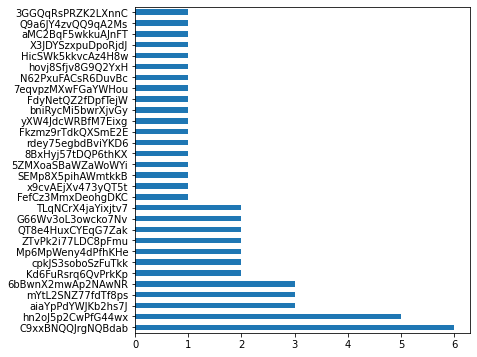

In [84]:
df[(df["hintsTaken"] == df["hintsTaken"]) & (df["falseAttempts"]!=df["falseAttempts"])]["pupilId"].value_counts().plot(kind='barh', figsize=(6,6))

#### Bei Aufgaben?

<AxesSubplot:>

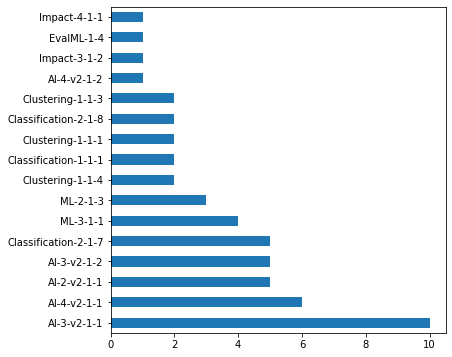

In [96]:
df[(df["hintsTaken"] == df["hintsTaken"]) & (df["falseAttempts"]!=df["falseAttempts"])]["taskId"].value_counts().plot(kind='barh', figsize=(6,6))

In [14]:
df[(df["hintsTaken"] == df["hintsTaken"]) & (df["falseAttempts"]!=df["falseAttempts"])][["taskId", "pupilId"]].value_counts()

taskId                pupilId          
ML-2-1-3              aiaYpPdYWJKb2hs7J    1
EvalML-1-4            hn2oJ5p2CwPfG44wx    1
AI-2-v2-1-1           Kd6FuRsrq6QvPrkKp    1
                      TLqNCrX4jaYixjtv7    1
AI-3-v2-1-1           6bBwnX2mwAp2NAwNR    1
                      Kd6FuRsrq6QvPrkKp    1
                      TLqNCrX4jaYixjtv7    1
                      aiaYpPdYWJKb2hs7J    1
                      hn2oJ5p2CwPfG44wx    1
                      hovj8Sfjv8G9Q2YxH    1
AI-3-v2-1-2           aiaYpPdYWJKb2hs7J    1
                      hn2oJ5p2CwPfG44wx    1
AI-4-v2-1-1           6bBwnX2mwAp2NAwNR    1
                      ZTvPk2i77LDC8pFmu    1
                      hn2oJ5p2CwPfG44wx    1
Classification-2-1-8  bniRycMi5bwrXjvGy    1
Clustering-1-1-3      6bBwnX2mwAp2NAwNR    1
                      ZTvPk2i77LDC8pFmu    1
Clustering-1-1-4      hn2oJ5p2CwPfG44wx    1
AI-2-v2-1-1           7eqvpzMXwFGaYWHou    1
dtype: int64

In [15]:
#df[(df["hintsTaken"] == df["hintsTaken"]) & (df["falseAttempts"]!=df["falseAttempts"])][["pupilId", "taskId", "question"]].value_counts()

Es scheint eine leichte Häufung zu geben, sowohl bei SuS, als auch bei Aufgaben

Aufgaben:
* va AI-3-v2-1-1

#### Helfen hints? --> gibt es viele fälle, in denen hints angefragt wurden, die aufgabe aber trotzdem nicht erledigt wurde?

In [97]:
hints_helped = 0
hints_not_helped = 0


for index, task in df[df["hints"] == df["hints"]].iterrows():
    # hints taken, false attempts, aber eval richtig
    if((task["hintsTaken"] == task["hintsTaken"]) & (task["falseAttempts"]==task["falseAttempts"]) & (task["evaluation"] == "correct")):
        hints_helped += 1
    # vs hints taken, false attempts, aber eval nicht correct
    elif((task["hintsTaken"] == task["hintsTaken"]) & (task["falseAttempts"]==task["falseAttempts"])& (task["evaluation"] == "false")):
        hints_not_helped +=1
            
print("nr cases where hints where taken and eval is correct --> they helped: " + str(hints_helped))
print("nr cases where hints where taken and eval is false --> didnt help: " + str(hints_not_helped))
print("percent of cases where hints helped: " + str(hints_helped/(hints_not_helped+hints_helped)))

nr cases where hints where taken and eval is correct --> they helped: 340
nr cases where hints where taken and eval is false --> didnt help: 785
percent of cases where hints helped: 0.3022222222222222


#### --> Our hints dont seem to help
#### Gibt es ballungen, wo sie besonders wenig geholfen haben?

In [20]:
df[(df["hintsTaken"] == df["hintsTaken"]) & (df["falseAttempts"]==df["falseAttempts"])& (df["evaluation"] == "false")].head()

pupilId            classId                taskId  \
156  6bBwnX2mwAp2NAwNR  qFEyvypMn4sAwLwtc              ML-3-1-1   
180  ZTvPk2i77LDC8pFmu  qFEyvypMn4sAwLwtc           AI-4-v2-1-2   
257  rsATbrReo6odn6oXD  qFEyvypMn4sAwLwtc              ML-3-1-1   
271  rsATbrReo6odn6oXD  qFEyvypMn4sAwLwtc  Classification-2-1-7   
272  rsATbrReo6odn6oXD  qFEyvypMn4sAwLwtc  Classification-2-1-8   

         taskSeriesId  duration                                         state  \
156              ML-3       293                     [True, True, True, False]   
180           AI-4-v2       234  [True, True, False, True, True, False, True]   
257              ML-3       422                     [True, True, True, False]   
271  Classification-2       106            [False, False, True, False, False]   
272  Classification-2        56                           [True, False, True]   

            subType evaluation  \
156  multipleChoice      false   
180  multipleChoice      false   
257  multipleChoice      false   
271  multipleChoice      false   
272  multipleChoice      false   

                                         falseAttempts hintsTaken  ...  \
156                       [[True, False, True, False]]          1  ...   
180  [[True, False, False, False, True, False, True...          1  ...   
257  [[False, False, False, False], [False, False, ...          1  ...   
271  [[False, False, False, False, True], [False, F...          1  ...   
272          [[True, True, True], [True, True, False]]          1  ...   

                                               answers minLabel maxLabel  \
156  [{'de': 'Maschinelles Lernen ist ein Teilberei...      NaN      NaN   
180  [{'de': 'KI-Anwendungen treffen eigenständige ...      NaN      NaN   
257  [{'de': 'Maschinelles Lernen ist ein Teilberei...      NaN      NaN   
271  [{'de': 'James Bond', 'en-US': 'James Bond'}, ...      NaN      NaN   
272  [{'de': 'Ein Algorithmus, der dir basierend au...      NaN      NaN   

                                                 hints  \
156               Lies die Antworten ganz genau durch.   
180                     Lies die Antworten ganz genau.   
257               Lies die Antworten ganz genau durch.   
271          Welchen Film hat Mahmud zuletzt geschaut?   
272  Denk daran, dass wir beim überwachten Lernen L...   

                                   sampleSolution number words in answer  \
156                     [True, True, True, False]                    NaN   
180  [True, True, False, True, True, False, True]                    NaN   
257                     [True, True, True, False]                    NaN   
271            [False, False, True, False, False]                    NaN   
272                           [True, False, True]                    NaN   

    numberFalseAttempts rating_content  rating_format  rating_creativity  
156                 NaN            NaN            NaN                NaN  
180                 NaN            NaN            NaN                NaN  
257                 NaN            NaN            NaN                NaN  
271                 NaN            NaN            NaN                NaN  
272                 NaN            NaN            NaN                NaN  

[5 rows x 23 columns]

In [21]:
df[(df["hintsTaken"] == df["hintsTaken"]) & (df["falseAttempts"]==df["falseAttempts"])& (df["evaluation"] == "false")][["taskId", "subType"]].value_counts()

taskId                subType       
AI-4-v2-1-2           multipleChoice    18
AI-3-v2-1-1           multipleChoice    16
Impact-4-1-1          multipleChoice    13
ML-3-1-1              multipleChoice    12
AI-3-v2-1-2           multipleChoice    12
AI-2-v2-1-1           multipleChoice    12
Clustering-1-1-1      multipleChoice     9
AI-4-v2-1-1           multipleChoice     9
Clustering-1-1-3      inputField         8
ML-2-1-3              multipleChoice     8
Clustering-1-1-4      inputField         8
Impact-3-1-2          multipleChoice     8
Classification-2-1-8  multipleChoice     8
Classification-2-1-7  multipleChoice     7
Classification-1-1-1  multipleChoice     6
EvalML-1-4            multipleChoice     4
Classification-2-1-6  multipleChoice     3
dtype: int64

Hints besonders schlecht bei:
* AI-4-v2-1-2             18
* AI-3-v2-1-1             16
* Impact-4-1-1            13
* AI-2-v2-1-1             12
* AI-3-v2-1-2             12
* ML-3-1-1                12

#### Bei MC (meiste hints) werden die Antworten bei der zweiten falschen Abgabe besser!
Die hints scheinen also zu helfen, oder ein genaueres Nachlesen scheint gut zu sein

# Revisions

In [88]:
nr_accepted_revisions = 0
nr_unaccepted_revisions = 0

for pupil in pupils:
    #print(pupil.keys())
    if("revisions" in pupil.keys()):
        if (pupil["revisions"]):
            if (pupil["revisions"][0]["accepted"]):
                nr_accepted_revisions +=1
            else:
                nr_unaccepted_revisions += 1

print("nr accepted: " + str(nr_accepted_revisions) + " nr unaccepted: " + str(nr_unaccepted_revisions))

nr accepted: 82 nr unaccepted: 946


das feld kann sehr temporär sein, accepted kan sich zB ändern, wenn es bearbeitet wurde, dh das ist nicht, was es scheint --> lieber schauen, wo es mehr false attempts gab, als hints

In [89]:
len(df[df["numberFalseAttempts"] > df["numberHints"]])

869

In [90]:
df[df['falseAttempts'].str.len() > df["hints"].str.len()]

pupilId            classId                taskId  \
88    sqBXKssFvS8pFYAMv  qFEyvypMn4sAwLwtc              ML-3-1-1   
94    sqBXKssFvS8pFYAMv  qFEyvypMn4sAwLwtc      Clustering-1-1-3   
124   sqBXKssFvS8pFYAMv  qFEyvypMn4sAwLwtc          Impact-3-1-2   
147   jRT6yzZ2ip5ab5ZFM  qFEyvypMn4sAwLwtc           AI-3-v2-1-2   
149   jRT6yzZ2ip5ab5ZFM  qFEyvypMn4sAwLwtc           AI-4-v2-1-2   
...                 ...                ...                   ...   
6396  SxzRMptJmyZPpiHxb  brSDebuCak3FfQsg6          Impact-4-1-1   
6405  jRPy8viwg2wNkRHok  brSDebuCak3FfQsg6      Clustering-1-1-1   
6410  jRPy8viwg2wNkRHok  brSDebuCak3FfQsg6  Classification-1-1-1   
6417  jRPy8viwg2wNkRHok  brSDebuCak3FfQsg6  Classification-2-1-8   
6420  3GGQqRsPRZK2LXnnC  brSDebuCak3FfQsg6      Clustering-1-1-1   

          taskSeriesId  duration  \
88                ML-3        57   
94        Clustering-1        61   
124           Impact-3        41   
147            AI-3-v2        59   
149            AI-4-v2       152   
...                ...       ...   
6396          Impact-4        24   
6405      Clustering-1        45   
6410  Classification-1       115   
6417  Classification-2        62   
6420      Clustering-1        29   

                                             state evaluation  \
88                       [True, True, True, False]    correct   
94                                               8    correct   
124        [False, True, False, True, True, False]    correct   
147                            [True, False, True]    correct   
149   [True, True, False, True, True, False, True]      false   
...                                            ...        ...   
6396  [True, False, True, True, True, True, False]      false   
6405                    [False, False, True, True]      false   
6410                          [False, True, False]      false   
6417                           [True, False, True]      false   
6420                    [False, False, True, True]      false   

                                          falseAttempts hintsTaken rating  \
88    [[True, True, True, True], [True, True, True, ...          1    NaN   
94                                               [3, 3]          1    NaN   
124   [[False, True, False, True, False, False], [Fa...          2    NaN   
147        [[False, False, True], [False, True, False]]          1    NaN   
149   [[False, True, True, False, False, True, True]...          1    NaN   
...                                                 ...        ...    ...   
6396  [[True, False, True, True, False, True, False]...          1    NaN   
6405  [[True, True, False, False], [False, False, Tr...          1    NaN   
6410         [[True, True, False], [True, True, False]]          1    NaN   
6417         [[True, True, True], [True, False, False]]          1    NaN   
6420  [[False, False, True, False], [False, False, T...          1    NaN   

      ... minLabel maxLabel  \
88    ...      NaN      NaN   
94    ...      NaN      NaN   
124   ...      NaN      NaN   
147   ...      NaN      NaN   
149   ...      NaN      NaN   
...   ...      ...      ...   
6396  ...      NaN      NaN   
6405  ...      NaN      NaN   
6410  ...      NaN      NaN   
6417  ...      NaN      NaN   
6420  ...      NaN      NaN   

                                                  hints  \
88    [{'de': 'Lies die Antworten ganz genau durch.'...   
94    [{'de': 'In welchem Cluster sind die beliebtes...   
124   [{'de': 'Kaum betroffen sind soziale Jobs und ...   
147   [{'de': 'Welche Anwendung kann nur eine Sache ...   
149   [{'de': 'Lies die Antworten ganz genau.', 'en-...   
...                                                 ...   
6396  [{'de': 'Denk auch an alles, was du schon über...   
6405  [{'de': 'Hier geht es nicht um überwachtes Ler...   
6410  [{'de': 'Lies die Antworten ganz genau.', 'en-...   
6417  [{'de': 'Denk daran, dass wir beim überwachten...   
6420  [{'de': 'Hier geht es nicht um ü

In [91]:
len(df[df['falseAttempts'].str.len() > df["hints"].str.len()])

869

In [92]:
revisions = df[df["numberFalseAttempts"] > df["numberHints"]][['pupilId', 'classId', 'taskId', 'taskSeriesId',
                                                               'subType', 'question', 'answers','hints', 'sampleSolution',
                                                               'duration', 'state','evaluation', 'falseAttempts', 
                                                               'hintsTaken','numberFalseAttempts', 'numberHints']]
revisions

pupilId            classId                taskId  \
88    sqBXKssFvS8pFYAMv  qFEyvypMn4sAwLwtc              ML-3-1-1   
94    sqBXKssFvS8pFYAMv  qFEyvypMn4sAwLwtc      Clustering-1-1-3   
124   sqBXKssFvS8pFYAMv  qFEyvypMn4sAwLwtc          Impact-3-1-2   
147   jRT6yzZ2ip5ab5ZFM  qFEyvypMn4sAwLwtc           AI-3-v2-1-2   
149   jRT6yzZ2ip5ab5ZFM  qFEyvypMn4sAwLwtc           AI-4-v2-1-2   
...                 ...                ...                   ...   
6396  SxzRMptJmyZPpiHxb  brSDebuCak3FfQsg6          Impact-4-1-1   
6405  jRPy8viwg2wNkRHok  brSDebuCak3FfQsg6      Clustering-1-1-1   
6410  jRPy8viwg2wNkRHok  brSDebuCak3FfQsg6  Classification-1-1-1   
6417  jRPy8viwg2wNkRHok  brSDebuCak3FfQsg6  Classification-2-1-8   
6420  3GGQqRsPRZK2LXnnC  brSDebuCak3FfQsg6      Clustering-1-1-1   

          taskSeriesId         subType  \
88                ML-3  multipleChoice   
94        Clustering-1      inputField   
124           Impact-3  multipleChoice   
147            AI-3-v2  multipleChoice   
149            AI-4-v2  multipleChoice   
...                ...             ...   
6396          Impact-4  multipleChoice   
6405      Clustering-1  multipleChoice   
6410  Classification-1  multipleChoice   
6417  Classification-2  multipleChoice   
6420      Clustering-1  multipleChoice   

                                               question  \
88                             Welche Aussagen stimmen?   
94    Wie viele Youtuber sind sowohl sehr aktiv als ...   
124                      Welche Jobs sind also bedroht?   
147    Welche der Aussagen über KI-Anwendungen stimmen?   
149   Lass uns noch einmal das Wichtigste wiederhole...   
...                                                 ...   
6396  Was sind möglichen Folgen vom Einsatz von KI i...   
6405          Was war unüberwachtes Lernen noch gleich?   
6410                           Welche Aussagen stimmen?   
6417                           Welche Aussagen stimmen?   
6420          Was war unüberwachtes Lernen noch gleich?   

                                                answers  \
88    [{'de': 'Maschinelles Lernen ist ein Teilberei...   
94                                                  NaN   
124   [{'de': 'Pflegepersonal', 'en-US': 'Care giver...   
147   [{'de': 'Empfehlungssysteme gehören zur spezif...   
149   [{'de': 'KI-Anwendungen treffen eigenständige ...   
...                                                 ...   
6396  [{'de': 'KI kann die Erkennung von Tumoren auf...   
6405  [{'de': 'Beim unüberwachten Lernen nutzt man D...   
6410  [{'de': 'Beim überwachten Lernen braucht man D...   
6417  [{'de': 'Ein Algorithmus, der dir basierend au...   
6420  [{'de': 'Beim unüberwachten Lernen nutzt man D...   

                                                  hints  \
88    [{'de': 'Lies die Antworten ganz genau durch.'...   
94    [{'de': 'In welchem Cluster sind die beliebtes...   
124   [{'de': 'Kaum betroffen sind soziale Jobs und ...   
147   [{'de': 'Welche Anwendung kann nur eine Sache ...   
149   [{'de': 'Lies die Antworten ganz genau.', 'en-...   
...                                                 ...   
6396  [{'de': 'Denk auch an alles, was du schon über...   
6405  [{'de': 'Hier geht es nicht um überwachtes Ler...   
6410  [{'de': 'Lies die Antworten ganz genau.', 'en-...   
6417  [{'de': 'Denk daran, dass wir beim überwachten...   
6420  [{'de': 'Hier geht es nicht um überwachtes Ler...   

                                    sampleSolution  duration  \
88                       [True, True, True, False]        57   
94                                               8        61   
124        [False, True, False, True, True, False]        41   
147                            [True, False, True]        59   
149   [True, True, False, True, True, False, True]       152   
...                                            ...       ...   
6396  [True, False, True, True, True, True, False]        24   
6405                    [False, False, True, True]     

### Do revisions work?

In [93]:
revisions["evaluation"].value_counts()["false"]/(revisions["evaluation"].value_counts()["correct"]+revisions["evaluation"].value_counts()["false"])


0.8423475258918297

<AxesSubplot:>

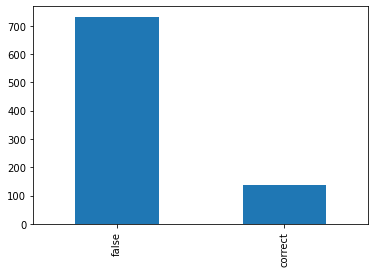

In [94]:
revisions["evaluation"].value_counts().plot(kind="bar")

<AxesSubplot:>

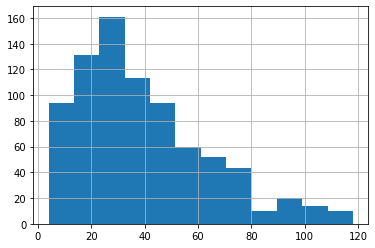

In [95]:
revisions[revisions["duration"]<120]["duration"].hist(bins=12)

## Hilfeanfragen

In [86]:
for classroom in classrooms:
    if(classroom["helpRequests"]):
        print(classroom["helpRequests"][0]["taskSeriesId"])
        print(classroom["helpRequests"][0]["question"])
        for message in classroom["helpRequests"][0]["chat"]["messages"]:
            if(message["message"] != "joinedChat"):
                print(message["message"])
        print("")

AlgorithmicAlltag-1
gggggggggggggggggggg

Algorithmic-1
Wie geht das hier?

If-3
wir haben irgendwo einen Fehler gemacht aber wir leider es nicht wissen...:(?

Algorithmic-2-v2
Keine Ahnung

AlgorithmicAlltag-2-v2
Das ist zu kompliziert...
tut mir Leid

Algorithmic-1-v2
veVDA`WSfasfasfaff
penis
gigh

Algorithmic-1-v2
Hilfe wie geht das?
hey

AI-2-v2
Need help here
Auf jeden Fall benutzt die Gesichtserkennung KI!

Algorithmic-3-v2
Wie geht das hier?

LoopsVergleich-2-v2
hilfe ich komme nicht weiter kann mir jemnd helfen?

ML-1
sollen wir nur schreiben z.B. es ist gr0ß oder ähnliches. Oder ein wirklicher Algo. mit irgendwelchen Befehlen?
Ersteres. Keinen richtigen Code, sondern auf Deutsch Kriterien wie die Pfoten formulieren
einfach die Eigenschaften erklären, z.B. Es ist ein Hund, wenn er Schlappohren hat
.)
:)

Impact-3
qwertyuiopasdfghjkl

Impact-3
qwertyuiopasdfghjkl

Algorithmic-1-v2
wie geht das hier?

Algorithmic-1-v2
I do not get it. How does this work?
take the blocks to the le

# Chat

In [87]:
print(chat_df["sentBy"].value_counts())
print()
# Wie nutzen Lehrer der Chat?
print(chat_df[chat_df["sentBy"] != "auto"]["message"])
# Hier sind auch noch unsere Nachrichten drinne, glaube ich?! Und lehrer nachrichten!

# Nutzen SuS den Chat?
print("\nmessages by SuS")
chat_df[np.where(chat_df["sentBy"].isin(set(df["pupilId"])), True, False)]


auto                 1256
koEujp8jk3kB5cmoB      47
sWm4d454H7CgZk7xP      26
eFfWFEEHYrGie6TWY      15
espYk5j5ea8zXxqNS       8
BKg2LYDFeoxC652Tp       4
cuXigYgm7Cdc6SAoP       4
7639RG4Dz3u9ZMuoQ       4
vPkj9gw4uYahqDz2b       2
n4MiFn7zqTd63RCgB       2
pgTXF7bp6BHWisjqq       2
rQZZF3NfngcsPTscW       1
mMwEKiemTDbBQmwEd       1
GHpnNu3Yss7Qz8Tm4       1
7mCgkqWPY47kQwFDM       1
ogzLirpSCEwwkkedt       1
zhsgngt45AFqncwAm       1
5Z7jJgPhJQwgugLrc       1
NK4FKNPBsqHFGY5Ji       1
wxkuvgoD5tbZyvyFy       1
FZTuuyvpvJBGhnCgk       1
LqYHGoaRCmEvWufis       1
Name: sentBy, dtype: int64

0       Hier könnt ihr euch individuell aber auch mir ...
10      Hier könnt ihr euch individuell aber auch mir ...
12      Hier könnt ihr euch individuell aber auch mir ...
24      Hier könnt ihr euch individuell aber auch mir ...
26      Hier könnt ihr euch individuell aber auch mir ...
                              ...                        
789                                 Hätte ja sein kö

Empty DataFrame
Columns: [0, sentBy, message, request]
Index: []

# Verwendete Methoden

## Wilcoxon signed-rank test

the signed-rank test is designed for paired comparisons on non-normal data. 

The Wilcoxon signed-rank test tests the null hypothesis that two related paired samples come from the same distribution. In particular, it tests whether the distribution of the differences x - y is symmetric about zero. It is a non-parametric version of the paired T-test.

To compute an effect size for the signed-rank test, one can use the rank-biserial correlation. If the test statistic W is reported, the rank correlation r is equal to the test statistic W divided by the total rank sum S, or r = W/S. [8] Using the above example, the test statistic is W = 9. The sample size of 9 has a total rank sum of S = (1 + 2 + 3 + 4 + 5 + 6 + 7 + 8 + 9) = 45. Hence, the rank correlation is 9/45, so r = 0.20. 

## Mann-Whitney-U test

The preferred non-parametric method for unpaired samples is the Mann-Whitney non parametric hypothesis test or Mann-Whitney test (it is also called as Wilcoxon Rank Sum Test or the Mann Whitney Wilcoxon Test) and thus the non parametric solution to evaluating two independent datasets comparable to the Student’s T test.

Mann-Whitney test is a non-parametric test that is to compare two sample means that may come from the same population, and used to test whether two sample means are equal or not. 

Null Hypotheses H0: Two populations are equal

https://sixsigmastudyguide.com/mann-whitney-non-parametric-hypothesis-test/

## Cohen's d --> Effektstärke
Ähnlich wie beim p-Wert, der angibt, wie hoch die Wahrscheinlichkeit ist, dass ein Ergebnis durch Zufall zustande kam, ist Cohens d ein Maß, das angibt, wie die Stärke eines Treatments oder eines Phänomens ist. Die Effektstärke wird üblicherweise berechnet, wenn statistische Signifikanz erreicht wurde.

interpretation results:
* 0,2-0.5 	Klein
* 0,5-0.8 	Mittel
* größer 0,8 	Stark

Bei nichtsignifikanz muss es nicht berechnet werden!

Note that, for small sample size (< 50), the Cohen’s d tends to over-inflate results. There exists a Hedge’s Corrected version of the Cohen’s d (Hedges and Olkin 1985), which reduces effect sizes for small samples by a few percentage points. The correction is introduced by multiplying the usual value of d by (N-3)/(N-2.25) (for unpaired t-test) and by (n1-2)/(n1-1.25) for paired t-test; where N is the total size of the two groups being compared (N = n1 + n2).


The Welch test is a variant of t-test used when the equality of variance can’t be assumed. The effect size can be computed by dividing the mean difference between the groups by the “averaged” standard deviation.

Cohen’s d formula:

\[
d = \frac{m_A - m_B}{\sqrt{(Var_1 + Var_2)/2}}
\]

where,
* \(m_A\) and \(m_B\) represent the mean value of the group A and B, respectively.
* \(Var_1\) and \(Var_2\) are the variance of the two groups.


## paired T-Test

In [73]:
# dann trotzdem t-test machen, weil ich genügend SuS haben werde
(t_stat0_05, p0_05) = stats.ttest_rel(pupil_performance_df.dropna(subset=["AI-1-v2-1-1", "EvalML-1-1"])["AI-4-v2-1-4"], pupil_performance_df.dropna(subset=["AI-1-v2-1-1", "EvalML-1-1"])["AI-1-v2-1-1"])
(t_stat05_1, p05_1) = stats.ttest_rel(pupil_performance_df.dropna(subset=["AI-1-v2-1-1", "EvalML-1-1"])["EvalML-1-1"], pupil_performance_df.dropna(subset=["AI-1-v2-1-1", "EvalML-1-1"])["AI-4-v2-1-4"])
(t_stat0_1, p0_1) = stats.ttest_rel(pupil_performance_df.dropna(subset=["AI-1-v2-1-1", "EvalML-1-1"])["EvalML-1-1"], pupil_performance_df.dropna(subset=["AI-1-v2-1-1", "EvalML-1-1"])["AI-1-v2-1-1"])

print(t_stat0_05, p0_05)
print(t_stat05_1, p05_1)
print(t_stat0_1, p0_1)

2.9525670234171146 0.009881733755346747
-2.457500582414377 0.026645707133842324
0.46741342885340026 0.6469221833851113


Ergebnis:
* T0-05: Sicher, dass gelernt wurde
* T05-1: Sicher, dass nichts gelernt wurde
* t0-1: keine SIgnifikanz

#### t- Manuell und logisch

In [21]:
# 1. zweiten Wert vom ersten subtrahieren, um gepaarte Differenzen zu erhalten --> schon gemacht

# 2. mittelwert und std für differenzen verechnen
mean0_05 = np.mean(differences_0_05)
std0_05 = np.std(differences_0_05)
mean05_1 = np.mean(differences_05_1)
std05_1 = np.std(differences_05_1)
mean0_1 = np.mean(differences_0_1)
std0_1 = np.std(differences_0_1)

# 3. Standardfehler berechnen
ste0_05 = std0_05/np.sqrt(len(differences_0_05))
ste05_1 = std05_1/np.sqrt(len(differences_0_05))
ste0_1 = std0_1/np.sqrt(len(differences_0_1))

# 4. Den Mittelwert der gepaarten Differenzen durch den Standardfehler teilen:
prüfgröße0_05 = mean0_05/ste0_05
prüfgröße05_1 = mean05_1/ste05_1
prüfgröße0_1 = mean0_1/ste0_1
print(prüfgröße0_05)
print(prüfgröße05_1)
print(prüfgröße0_1)

2.0596699514747843
-3.589409344187835
0.48274251353144654


wir schauen, welche signifikanz wir wollen (95%) und vergleichen den nötigen wert mit unserem:
--> t-value bei 95% 1.753. Messung-0-05 größer, 05-1 negativ aber größer und 0-1 kleiner

testen, ob jeweils beide ergebnisse von der gleichen verteilung kommen, mit nullhypothese: kommt von der gleichen
* T0 zu T0.5  --> sicher, dass sie gelernt haben
* T0.5 zu T1 --> sicher, dass sie weniger wissen, als vorher
* T0 zu T1 --> nicht sicher, dass sie was gelernt haben

bedenken:
* erste einschätzung muss nicht richtig sein. wobei eine klasse schon etwas gemacht zu haben scheint
* trotzdem hat erster teil einen effekt. der zweite zu ML hat keinen mehr. außerdem primacy und recency bedenken!

## Korrelation selbsteinschätzungen und Ratings

Ordinale Werte bei Ratings --> use Spearman rho and/or Kendall Tau
* Spearman's rho can be understood as a rank-based version of Pearson's correlation coefficient. Assumptions:
  * The Spearman correlation itself only assumes that both variables are at least ordinal variables. This excludes all but nominal variables.
  * The statistical significance test for a Spearman correlation assumes independent observations or -precisely- independent and identically distributed variables.
* Like Spearman's rho, Kendall's tau measures the degree of a monotone relationship between variables. Roughly speaking, Kendall's tau distinguishes itself from Spearman's rho by stronger penalization of non-sequential (in context of the ranked variables) dislocations.

In [115]:
pupil_performance_df[["AI-1-v2-1-1", 'AI-4-v2-1-4', 'EvalML-1-1']].corr()

AI-1-v2-1-1  AI-4-v2-1-4  EvalML-1-1
AI-1-v2-1-1     1.000000     0.348581    0.349789
AI-4-v2-1-4     0.348581     1.000000    0.483606
EvalML-1-1      0.349789     0.483606    1.000000

In [116]:
pupil_performance_df[["AI-1-v2-1-1", 'AI-4-v2-1-4', 'EvalML-1-1']].corr(method='spearman')

AI-1-v2-1-1  AI-4-v2-1-4  EvalML-1-1
AI-1-v2-1-1     1.000000     0.393998     0.40233
AI-4-v2-1-4     0.393998     1.000000     0.52424
EvalML-1-1      0.402330     0.524240     1.00000

In [37]:
print(stats.spearmanr(pupil_performance_df[["AI-1-v2-1-1", "AI-1-v2-1-2_rating_content"]]))
print(stats.spearmanr(pupil_performance_df.dropna(subset=["AI-4-v2-1-4", "AI-4-v2-1-3_rating_content"])[["AI-4-v2-1-4", "AI-4-v2-1-3_rating_content"]]))

# Returns:
# correlation: Spearman correlation matrix or correlation coefficient
# pvalue: two-sided p-value for a hypothesis test whose null hypothesis is that two sets of data are uncorrelated

SpearmanrResult(correlation=-0.1303687090731695, pvalue=0.42266343052381106)
SpearmanrResult(correlation=0.13258968290067855, pvalue=0.48489047949594666)


Results:
* gibt eine leichte bis moderate Korrelation zwischen selbsteinsch bei T0 und den späteren Zeitpunkten (0.38 bzw 0.42). Stärkster zusammenhang zwischen t1 und t0.5 (0.52)
* zwischen der selbsteinschätzung und dem content_rating beim ersten gibt es kaum zusammenhang (-0.130)
* zwischen der selbsteinschätzung und dem content_rating beim letzten gibt es kaum zusammenhang (0.132)

p-values:
* ca 0.5 --> data is likely with a true null --> cant reject null hypothesis that observed difference in the sample does not reflect a true difference between populations